# 50.039 Theory and Practice of Deep Learning | Coding Homework 3 - Fully Connected Network Exercise
## Joel Huang, 1002530

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules as modules
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import Dataset, DataLoader

import numpy as np

In [2]:
def get_data_loaders(batch_size, directory):
    train_data = FashionMNIST(directory, train=True, transform=transforms.ToTensor())
    test_data = FashionMNIST(directory, transform=transforms.ToTensor())

    train_data_loader = torch.utils.data.DataLoader(train_data,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    num_workers=4)
    test_data_loader = torch.utils.data.DataLoader(test_data,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4)
    return train_data_loader, test_data_loader

# Model
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100,10)
        
    def forward(self, x):
        x = x.view(16, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item()) 
    return np.average(train_losses)
            
def test(model, device, test_loader):
    """
    Use this as validation (wrong, but for the purposes of this exercise it is ok)
    """
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss
    
DATA_DIRECTORY = 'data/'
use_cuda = 1

batch_size = 16
num_epochs = 10
learning_rate = 1e-2

train_loader, test_loader = get_data_loaders(batch_size, DATA_DIRECTORY)

device = torch.device("cuda" if use_cuda else "cpu")
model = FCN().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    train_losses.append(train(model, device, train_loader, optimizer, epoch))
    test_losses.append(test(model, device, test_loader))

torch.save(model.state_dict(),"mnist_fcn.pt")

/home/joel/anaconda2/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.281379
Train Epoch: 1 [16/60000 (0%)]	Loss: 2.297140
Train Epoch: 1 [32/60000 (0%)]	Loss: 2.298382
Train Epoch: 1 [48/60000 (0%)]	Loss: 2.276740
Train Epoch: 1 [64/60000 (0%)]	Loss: 2.282208
Train Epoch: 1 [80/60000 (0%)]	Loss: 2.325192
Train Epoch: 1 [96/60000 (0%)]	Loss: 2.301369
Train Epoch: 1 [112/60000 (0%)]	Loss: 2.301515
Train Epoch: 1 [128/60000 (0%)]	Loss: 2.289035
Train Epoch: 1 [144/60000 (0%)]	Loss: 2.282849
Train Epoch: 1 [160/60000 (0%)]	Loss: 2.291680
Train Epoch: 1 [176/60000 (0%)]	Loss: 2.280046
Train Epoch: 1 [192/60000 (0%)]	Loss: 2.287131
Train Epoch: 1 [208/60000 (0%)]	Loss: 2.285224
Train Epoch: 1 [224/60000 (0%)]	Loss: 2.331207
Train Epoch: 1 [240/60000 (0%)]	Loss: 2.283378
Train Epoch: 1 [256/60000 (0%)]	Loss: 2.302974
Train Epoch: 1 [272/60000 (0%)]	Loss: 2.303866
Train Epoch: 1 [288/60000 (0%)]	Loss: 2.291607
Train Epoch: 1 [304/60000 (1%)]	Loss: 2.286416
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.274975
Train Epoch: 1 [336/6

Train Epoch: 1 [2912/60000 (5%)]	Loss: 1.980945
Train Epoch: 1 [2928/60000 (5%)]	Loss: 2.019570
Train Epoch: 1 [2944/60000 (5%)]	Loss: 2.075296
Train Epoch: 1 [2960/60000 (5%)]	Loss: 2.078197
Train Epoch: 1 [2976/60000 (5%)]	Loss: 2.021502
Train Epoch: 1 [2992/60000 (5%)]	Loss: 2.009626
Train Epoch: 1 [3008/60000 (5%)]	Loss: 2.006369
Train Epoch: 1 [3024/60000 (5%)]	Loss: 2.020920
Train Epoch: 1 [3040/60000 (5%)]	Loss: 1.970692
Train Epoch: 1 [3056/60000 (5%)]	Loss: 1.967938
Train Epoch: 1 [3072/60000 (5%)]	Loss: 2.044713
Train Epoch: 1 [3088/60000 (5%)]	Loss: 1.980268
Train Epoch: 1 [3104/60000 (5%)]	Loss: 2.020941
Train Epoch: 1 [3120/60000 (5%)]	Loss: 1.916729
Train Epoch: 1 [3136/60000 (5%)]	Loss: 1.951786
Train Epoch: 1 [3152/60000 (5%)]	Loss: 2.055099
Train Epoch: 1 [3168/60000 (5%)]	Loss: 1.939510
Train Epoch: 1 [3184/60000 (5%)]	Loss: 2.051881
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.063776
Train Epoch: 1 [3216/60000 (5%)]	Loss: 1.955960
Train Epoch: 1 [3232/60000 (5%)]	Loss: 1

Train Epoch: 1 [6288/60000 (10%)]	Loss: 1.318678
Train Epoch: 1 [6304/60000 (11%)]	Loss: 1.446096
Train Epoch: 1 [6320/60000 (11%)]	Loss: 1.414279
Train Epoch: 1 [6336/60000 (11%)]	Loss: 1.488433
Train Epoch: 1 [6352/60000 (11%)]	Loss: 1.366207
Train Epoch: 1 [6368/60000 (11%)]	Loss: 1.281197
Train Epoch: 1 [6384/60000 (11%)]	Loss: 1.405316
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.127952
Train Epoch: 1 [6416/60000 (11%)]	Loss: 1.164635
Train Epoch: 1 [6432/60000 (11%)]	Loss: 1.507806
Train Epoch: 1 [6448/60000 (11%)]	Loss: 1.361725
Train Epoch: 1 [6464/60000 (11%)]	Loss: 1.282421
Train Epoch: 1 [6480/60000 (11%)]	Loss: 1.127093
Train Epoch: 1 [6496/60000 (11%)]	Loss: 1.308750
Train Epoch: 1 [6512/60000 (11%)]	Loss: 1.189030
Train Epoch: 1 [6528/60000 (11%)]	Loss: 1.124795
Train Epoch: 1 [6544/60000 (11%)]	Loss: 1.451176
Train Epoch: 1 [6560/60000 (11%)]	Loss: 1.403223
Train Epoch: 1 [6576/60000 (11%)]	Loss: 1.185887
Train Epoch: 1 [6592/60000 (11%)]	Loss: 1.293641
Train Epoch: 1 [6608

Train Epoch: 1 [9760/60000 (16%)]	Loss: 1.079448
Train Epoch: 1 [9776/60000 (16%)]	Loss: 0.757656
Train Epoch: 1 [9792/60000 (16%)]	Loss: 0.940965
Train Epoch: 1 [9808/60000 (16%)]	Loss: 0.848307
Train Epoch: 1 [9824/60000 (16%)]	Loss: 1.047374
Train Epoch: 1 [9840/60000 (16%)]	Loss: 0.778564
Train Epoch: 1 [9856/60000 (16%)]	Loss: 1.067676
Train Epoch: 1 [9872/60000 (16%)]	Loss: 1.055460
Train Epoch: 1 [9888/60000 (16%)]	Loss: 0.788196
Train Epoch: 1 [9904/60000 (17%)]	Loss: 1.048210
Train Epoch: 1 [9920/60000 (17%)]	Loss: 0.935243
Train Epoch: 1 [9936/60000 (17%)]	Loss: 1.057421
Train Epoch: 1 [9952/60000 (17%)]	Loss: 0.913834
Train Epoch: 1 [9968/60000 (17%)]	Loss: 0.893052
Train Epoch: 1 [9984/60000 (17%)]	Loss: 1.233698
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.988039
Train Epoch: 1 [10016/60000 (17%)]	Loss: 1.120955
Train Epoch: 1 [10032/60000 (17%)]	Loss: 0.960335
Train Epoch: 1 [10048/60000 (17%)]	Loss: 0.905311
Train Epoch: 1 [10064/60000 (17%)]	Loss: 1.467986
Train Epoch: 1 

Train Epoch: 1 [12976/60000 (22%)]	Loss: 0.717638
Train Epoch: 1 [12992/60000 (22%)]	Loss: 1.082193
Train Epoch: 1 [13008/60000 (22%)]	Loss: 0.612735
Train Epoch: 1 [13024/60000 (22%)]	Loss: 0.896897
Train Epoch: 1 [13040/60000 (22%)]	Loss: 1.156449
Train Epoch: 1 [13056/60000 (22%)]	Loss: 1.091071
Train Epoch: 1 [13072/60000 (22%)]	Loss: 0.696876
Train Epoch: 1 [13088/60000 (22%)]	Loss: 0.615168
Train Epoch: 1 [13104/60000 (22%)]	Loss: 0.842606
Train Epoch: 1 [13120/60000 (22%)]	Loss: 1.058447
Train Epoch: 1 [13136/60000 (22%)]	Loss: 1.024750
Train Epoch: 1 [13152/60000 (22%)]	Loss: 0.799891
Train Epoch: 1 [13168/60000 (22%)]	Loss: 0.752473
Train Epoch: 1 [13184/60000 (22%)]	Loss: 0.898693
Train Epoch: 1 [13200/60000 (22%)]	Loss: 0.984188
Train Epoch: 1 [13216/60000 (22%)]	Loss: 0.717937
Train Epoch: 1 [13232/60000 (22%)]	Loss: 0.939211
Train Epoch: 1 [13248/60000 (22%)]	Loss: 0.883540
Train Epoch: 1 [13264/60000 (22%)]	Loss: 1.351056
Train Epoch: 1 [13280/60000 (22%)]	Loss: 1.022735


Train Epoch: 1 [15808/60000 (26%)]	Loss: 0.996715
Train Epoch: 1 [15824/60000 (26%)]	Loss: 0.872613
Train Epoch: 1 [15840/60000 (26%)]	Loss: 0.869995
Train Epoch: 1 [15856/60000 (26%)]	Loss: 1.020675
Train Epoch: 1 [15872/60000 (26%)]	Loss: 0.600583
Train Epoch: 1 [15888/60000 (26%)]	Loss: 0.544410
Train Epoch: 1 [15904/60000 (27%)]	Loss: 0.609168
Train Epoch: 1 [15920/60000 (27%)]	Loss: 0.585500
Train Epoch: 1 [15936/60000 (27%)]	Loss: 0.951855
Train Epoch: 1 [15952/60000 (27%)]	Loss: 0.612785
Train Epoch: 1 [15968/60000 (27%)]	Loss: 1.200840
Train Epoch: 1 [15984/60000 (27%)]	Loss: 0.554915
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.172803
Train Epoch: 1 [16016/60000 (27%)]	Loss: 0.696425
Train Epoch: 1 [16032/60000 (27%)]	Loss: 0.940588
Train Epoch: 1 [16048/60000 (27%)]	Loss: 0.926805
Train Epoch: 1 [16064/60000 (27%)]	Loss: 0.935389
Train Epoch: 1 [16080/60000 (27%)]	Loss: 0.677989
Train Epoch: 1 [16096/60000 (27%)]	Loss: 0.564473
Train Epoch: 1 [16112/60000 (27%)]	Loss: 0.778449


Train Epoch: 1 [18928/60000 (32%)]	Loss: 0.595411
Train Epoch: 1 [18944/60000 (32%)]	Loss: 0.532583
Train Epoch: 1 [18960/60000 (32%)]	Loss: 0.687050
Train Epoch: 1 [18976/60000 (32%)]	Loss: 0.677867
Train Epoch: 1 [18992/60000 (32%)]	Loss: 0.575022
Train Epoch: 1 [19008/60000 (32%)]	Loss: 0.550817
Train Epoch: 1 [19024/60000 (32%)]	Loss: 0.647892
Train Epoch: 1 [19040/60000 (32%)]	Loss: 0.582204
Train Epoch: 1 [19056/60000 (32%)]	Loss: 0.658245
Train Epoch: 1 [19072/60000 (32%)]	Loss: 0.512579
Train Epoch: 1 [19088/60000 (32%)]	Loss: 0.586863
Train Epoch: 1 [19104/60000 (32%)]	Loss: 0.968598
Train Epoch: 1 [19120/60000 (32%)]	Loss: 1.058825
Train Epoch: 1 [19136/60000 (32%)]	Loss: 0.466952
Train Epoch: 1 [19152/60000 (32%)]	Loss: 0.773369
Train Epoch: 1 [19168/60000 (32%)]	Loss: 0.953004
Train Epoch: 1 [19184/60000 (32%)]	Loss: 0.687246
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.683385
Train Epoch: 1 [19216/60000 (32%)]	Loss: 0.601687
Train Epoch: 1 [19232/60000 (32%)]	Loss: 0.640479


Train Epoch: 1 [21680/60000 (36%)]	Loss: 0.851794
Train Epoch: 1 [21696/60000 (36%)]	Loss: 0.606447
Train Epoch: 1 [21712/60000 (36%)]	Loss: 0.817655
Train Epoch: 1 [21728/60000 (36%)]	Loss: 0.760694
Train Epoch: 1 [21744/60000 (36%)]	Loss: 0.863281
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.928777
Train Epoch: 1 [21776/60000 (36%)]	Loss: 0.948082
Train Epoch: 1 [21792/60000 (36%)]	Loss: 0.609366
Train Epoch: 1 [21808/60000 (36%)]	Loss: 0.791500
Train Epoch: 1 [21824/60000 (36%)]	Loss: 0.650224
Train Epoch: 1 [21840/60000 (36%)]	Loss: 0.598225
Train Epoch: 1 [21856/60000 (36%)]	Loss: 0.531988
Train Epoch: 1 [21872/60000 (36%)]	Loss: 0.618046
Train Epoch: 1 [21888/60000 (36%)]	Loss: 0.908266
Train Epoch: 1 [21904/60000 (37%)]	Loss: 0.690099
Train Epoch: 1 [21920/60000 (37%)]	Loss: 0.588302
Train Epoch: 1 [21936/60000 (37%)]	Loss: 0.736077
Train Epoch: 1 [21952/60000 (37%)]	Loss: 0.783927
Train Epoch: 1 [21968/60000 (37%)]	Loss: 0.826535
Train Epoch: 1 [21984/60000 (37%)]	Loss: 0.721356


Train Epoch: 1 [24624/60000 (41%)]	Loss: 0.732237
Train Epoch: 1 [24640/60000 (41%)]	Loss: 0.657875
Train Epoch: 1 [24656/60000 (41%)]	Loss: 0.798066
Train Epoch: 1 [24672/60000 (41%)]	Loss: 0.808656
Train Epoch: 1 [24688/60000 (41%)]	Loss: 0.820806
Train Epoch: 1 [24704/60000 (41%)]	Loss: 0.992460
Train Epoch: 1 [24720/60000 (41%)]	Loss: 0.498156
Train Epoch: 1 [24736/60000 (41%)]	Loss: 0.620580
Train Epoch: 1 [24752/60000 (41%)]	Loss: 0.621831
Train Epoch: 1 [24768/60000 (41%)]	Loss: 0.616878
Train Epoch: 1 [24784/60000 (41%)]	Loss: 1.063526
Train Epoch: 1 [24800/60000 (41%)]	Loss: 0.842807
Train Epoch: 1 [24816/60000 (41%)]	Loss: 0.380527
Train Epoch: 1 [24832/60000 (41%)]	Loss: 0.802703
Train Epoch: 1 [24848/60000 (41%)]	Loss: 0.965660
Train Epoch: 1 [24864/60000 (41%)]	Loss: 0.425322
Train Epoch: 1 [24880/60000 (41%)]	Loss: 0.673872
Train Epoch: 1 [24896/60000 (41%)]	Loss: 0.802830
Train Epoch: 1 [24912/60000 (42%)]	Loss: 0.678461
Train Epoch: 1 [24928/60000 (42%)]	Loss: 0.496251


Train Epoch: 1 [27344/60000 (46%)]	Loss: 1.129896
Train Epoch: 1 [27360/60000 (46%)]	Loss: 0.650918
Train Epoch: 1 [27376/60000 (46%)]	Loss: 0.989104
Train Epoch: 1 [27392/60000 (46%)]	Loss: 0.730593
Train Epoch: 1 [27408/60000 (46%)]	Loss: 0.766868
Train Epoch: 1 [27424/60000 (46%)]	Loss: 0.403999
Train Epoch: 1 [27440/60000 (46%)]	Loss: 0.727908
Train Epoch: 1 [27456/60000 (46%)]	Loss: 0.915364
Train Epoch: 1 [27472/60000 (46%)]	Loss: 0.845582
Train Epoch: 1 [27488/60000 (46%)]	Loss: 0.771871
Train Epoch: 1 [27504/60000 (46%)]	Loss: 0.763559
Train Epoch: 1 [27520/60000 (46%)]	Loss: 1.046943
Train Epoch: 1 [27536/60000 (46%)]	Loss: 0.724834
Train Epoch: 1 [27552/60000 (46%)]	Loss: 0.627593
Train Epoch: 1 [27568/60000 (46%)]	Loss: 0.618657
Train Epoch: 1 [27584/60000 (46%)]	Loss: 1.042155
Train Epoch: 1 [27600/60000 (46%)]	Loss: 0.545733
Train Epoch: 1 [27616/60000 (46%)]	Loss: 0.511255
Train Epoch: 1 [27632/60000 (46%)]	Loss: 0.632056
Train Epoch: 1 [27648/60000 (46%)]	Loss: 0.794259


Train Epoch: 1 [30624/60000 (51%)]	Loss: 0.744250
Train Epoch: 1 [30640/60000 (51%)]	Loss: 0.656093
Train Epoch: 1 [30656/60000 (51%)]	Loss: 0.679018
Train Epoch: 1 [30672/60000 (51%)]	Loss: 0.789132
Train Epoch: 1 [30688/60000 (51%)]	Loss: 0.473740
Train Epoch: 1 [30704/60000 (51%)]	Loss: 0.824423
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.356236
Train Epoch: 1 [30736/60000 (51%)]	Loss: 0.733023
Train Epoch: 1 [30752/60000 (51%)]	Loss: 0.673950
Train Epoch: 1 [30768/60000 (51%)]	Loss: 0.436304
Train Epoch: 1 [30784/60000 (51%)]	Loss: 1.129708
Train Epoch: 1 [30800/60000 (51%)]	Loss: 0.367758
Train Epoch: 1 [30816/60000 (51%)]	Loss: 0.669424
Train Epoch: 1 [30832/60000 (51%)]	Loss: 0.639260
Train Epoch: 1 [30848/60000 (51%)]	Loss: 0.950693
Train Epoch: 1 [30864/60000 (51%)]	Loss: 0.459385
Train Epoch: 1 [30880/60000 (51%)]	Loss: 0.498187
Train Epoch: 1 [30896/60000 (51%)]	Loss: 1.122699
Train Epoch: 1 [30912/60000 (52%)]	Loss: 0.340909
Train Epoch: 1 [30928/60000 (52%)]	Loss: 0.338817


Train Epoch: 1 [33360/60000 (56%)]	Loss: 0.570274
Train Epoch: 1 [33376/60000 (56%)]	Loss: 0.466137
Train Epoch: 1 [33392/60000 (56%)]	Loss: 0.499419
Train Epoch: 1 [33408/60000 (56%)]	Loss: 0.531456
Train Epoch: 1 [33424/60000 (56%)]	Loss: 0.961803
Train Epoch: 1 [33440/60000 (56%)]	Loss: 0.658304
Train Epoch: 1 [33456/60000 (56%)]	Loss: 1.121562
Train Epoch: 1 [33472/60000 (56%)]	Loss: 0.560682
Train Epoch: 1 [33488/60000 (56%)]	Loss: 0.867650
Train Epoch: 1 [33504/60000 (56%)]	Loss: 0.509424
Train Epoch: 1 [33520/60000 (56%)]	Loss: 0.719133
Train Epoch: 1 [33536/60000 (56%)]	Loss: 0.601682
Train Epoch: 1 [33552/60000 (56%)]	Loss: 0.368183
Train Epoch: 1 [33568/60000 (56%)]	Loss: 0.879425
Train Epoch: 1 [33584/60000 (56%)]	Loss: 0.385394
Train Epoch: 1 [33600/60000 (56%)]	Loss: 0.264069
Train Epoch: 1 [33616/60000 (56%)]	Loss: 0.454507
Train Epoch: 1 [33632/60000 (56%)]	Loss: 0.723434
Train Epoch: 1 [33648/60000 (56%)]	Loss: 0.846850
Train Epoch: 1 [33664/60000 (56%)]	Loss: 0.517055


Train Epoch: 1 [36336/60000 (61%)]	Loss: 0.522857
Train Epoch: 1 [36352/60000 (61%)]	Loss: 0.844733
Train Epoch: 1 [36368/60000 (61%)]	Loss: 0.521333
Train Epoch: 1 [36384/60000 (61%)]	Loss: 0.815072
Train Epoch: 1 [36400/60000 (61%)]	Loss: 0.689833
Train Epoch: 1 [36416/60000 (61%)]	Loss: 0.553700
Train Epoch: 1 [36432/60000 (61%)]	Loss: 0.324871
Train Epoch: 1 [36448/60000 (61%)]	Loss: 0.730952
Train Epoch: 1 [36464/60000 (61%)]	Loss: 0.454873
Train Epoch: 1 [36480/60000 (61%)]	Loss: 0.482377
Train Epoch: 1 [36496/60000 (61%)]	Loss: 0.753087
Train Epoch: 1 [36512/60000 (61%)]	Loss: 0.936517
Train Epoch: 1 [36528/60000 (61%)]	Loss: 0.355071
Train Epoch: 1 [36544/60000 (61%)]	Loss: 0.464492
Train Epoch: 1 [36560/60000 (61%)]	Loss: 0.650371
Train Epoch: 1 [36576/60000 (61%)]	Loss: 0.342983
Train Epoch: 1 [36592/60000 (61%)]	Loss: 0.411899
Train Epoch: 1 [36608/60000 (61%)]	Loss: 0.534051
Train Epoch: 1 [36624/60000 (61%)]	Loss: 0.368334
Train Epoch: 1 [36640/60000 (61%)]	Loss: 0.460579


Train Epoch: 1 [39136/60000 (65%)]	Loss: 0.744072
Train Epoch: 1 [39152/60000 (65%)]	Loss: 0.804592
Train Epoch: 1 [39168/60000 (65%)]	Loss: 0.696427
Train Epoch: 1 [39184/60000 (65%)]	Loss: 0.467804
Train Epoch: 1 [39200/60000 (65%)]	Loss: 0.400501
Train Epoch: 1 [39216/60000 (65%)]	Loss: 0.771225
Train Epoch: 1 [39232/60000 (65%)]	Loss: 0.760705
Train Epoch: 1 [39248/60000 (65%)]	Loss: 0.534835
Train Epoch: 1 [39264/60000 (65%)]	Loss: 0.683625
Train Epoch: 1 [39280/60000 (65%)]	Loss: 0.354476
Train Epoch: 1 [39296/60000 (65%)]	Loss: 0.520619
Train Epoch: 1 [39312/60000 (66%)]	Loss: 0.732166
Train Epoch: 1 [39328/60000 (66%)]	Loss: 0.498345
Train Epoch: 1 [39344/60000 (66%)]	Loss: 0.498123
Train Epoch: 1 [39360/60000 (66%)]	Loss: 0.891290
Train Epoch: 1 [39376/60000 (66%)]	Loss: 0.310375
Train Epoch: 1 [39392/60000 (66%)]	Loss: 0.618616
Train Epoch: 1 [39408/60000 (66%)]	Loss: 0.604847
Train Epoch: 1 [39424/60000 (66%)]	Loss: 0.514073
Train Epoch: 1 [39440/60000 (66%)]	Loss: 0.490622


Train Epoch: 1 [42320/60000 (71%)]	Loss: 0.172901
Train Epoch: 1 [42336/60000 (71%)]	Loss: 1.303227
Train Epoch: 1 [42352/60000 (71%)]	Loss: 0.480277
Train Epoch: 1 [42368/60000 (71%)]	Loss: 0.755227
Train Epoch: 1 [42384/60000 (71%)]	Loss: 0.468044
Train Epoch: 1 [42400/60000 (71%)]	Loss: 1.026407
Train Epoch: 1 [42416/60000 (71%)]	Loss: 0.850787
Train Epoch: 1 [42432/60000 (71%)]	Loss: 0.473786
Train Epoch: 1 [42448/60000 (71%)]	Loss: 0.816126
Train Epoch: 1 [42464/60000 (71%)]	Loss: 0.598575
Train Epoch: 1 [42480/60000 (71%)]	Loss: 0.394417
Train Epoch: 1 [42496/60000 (71%)]	Loss: 0.627545
Train Epoch: 1 [42512/60000 (71%)]	Loss: 0.593585
Train Epoch: 1 [42528/60000 (71%)]	Loss: 0.447495
Train Epoch: 1 [42544/60000 (71%)]	Loss: 0.397091
Train Epoch: 1 [42560/60000 (71%)]	Loss: 0.858104
Train Epoch: 1 [42576/60000 (71%)]	Loss: 0.449869
Train Epoch: 1 [42592/60000 (71%)]	Loss: 0.269441
Train Epoch: 1 [42608/60000 (71%)]	Loss: 0.782872
Train Epoch: 1 [42624/60000 (71%)]	Loss: 0.797582


Train Epoch: 1 [45200/60000 (75%)]	Loss: 0.368541
Train Epoch: 1 [45216/60000 (75%)]	Loss: 0.416440
Train Epoch: 1 [45232/60000 (75%)]	Loss: 0.472723
Train Epoch: 1 [45248/60000 (75%)]	Loss: 0.625538
Train Epoch: 1 [45264/60000 (75%)]	Loss: 0.460525
Train Epoch: 1 [45280/60000 (75%)]	Loss: 0.708635
Train Epoch: 1 [45296/60000 (75%)]	Loss: 0.562709
Train Epoch: 1 [45312/60000 (76%)]	Loss: 0.227801
Train Epoch: 1 [45328/60000 (76%)]	Loss: 0.623026
Train Epoch: 1 [45344/60000 (76%)]	Loss: 0.558203
Train Epoch: 1 [45360/60000 (76%)]	Loss: 0.673503
Train Epoch: 1 [45376/60000 (76%)]	Loss: 0.296268
Train Epoch: 1 [45392/60000 (76%)]	Loss: 0.661285
Train Epoch: 1 [45408/60000 (76%)]	Loss: 0.481798
Train Epoch: 1 [45424/60000 (76%)]	Loss: 0.934867
Train Epoch: 1 [45440/60000 (76%)]	Loss: 0.816480
Train Epoch: 1 [45456/60000 (76%)]	Loss: 0.385509
Train Epoch: 1 [45472/60000 (76%)]	Loss: 1.310698
Train Epoch: 1 [45488/60000 (76%)]	Loss: 0.221841
Train Epoch: 1 [45504/60000 (76%)]	Loss: 0.275798


Train Epoch: 1 [47936/60000 (80%)]	Loss: 0.488812
Train Epoch: 1 [47952/60000 (80%)]	Loss: 0.494444
Train Epoch: 1 [47968/60000 (80%)]	Loss: 1.042878
Train Epoch: 1 [47984/60000 (80%)]	Loss: 0.453555
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.461019
Train Epoch: 1 [48016/60000 (80%)]	Loss: 0.691938
Train Epoch: 1 [48032/60000 (80%)]	Loss: 0.652210
Train Epoch: 1 [48048/60000 (80%)]	Loss: 0.559022
Train Epoch: 1 [48064/60000 (80%)]	Loss: 0.334323
Train Epoch: 1 [48080/60000 (80%)]	Loss: 0.702604
Train Epoch: 1 [48096/60000 (80%)]	Loss: 0.708532
Train Epoch: 1 [48112/60000 (80%)]	Loss: 0.501754
Train Epoch: 1 [48128/60000 (80%)]	Loss: 0.682638
Train Epoch: 1 [48144/60000 (80%)]	Loss: 0.719115
Train Epoch: 1 [48160/60000 (80%)]	Loss: 0.391630
Train Epoch: 1 [48176/60000 (80%)]	Loss: 0.891199
Train Epoch: 1 [48192/60000 (80%)]	Loss: 0.463756
Train Epoch: 1 [48208/60000 (80%)]	Loss: 0.408674
Train Epoch: 1 [48224/60000 (80%)]	Loss: 0.197829
Train Epoch: 1 [48240/60000 (80%)]	Loss: 0.783961


Train Epoch: 1 [51056/60000 (85%)]	Loss: 0.416631
Train Epoch: 1 [51072/60000 (85%)]	Loss: 0.379333
Train Epoch: 1 [51088/60000 (85%)]	Loss: 0.564076
Train Epoch: 1 [51104/60000 (85%)]	Loss: 0.896454
Train Epoch: 1 [51120/60000 (85%)]	Loss: 0.234130
Train Epoch: 1 [51136/60000 (85%)]	Loss: 0.667147
Train Epoch: 1 [51152/60000 (85%)]	Loss: 0.548781
Train Epoch: 1 [51168/60000 (85%)]	Loss: 0.660307
Train Epoch: 1 [51184/60000 (85%)]	Loss: 0.495952
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.245340
Train Epoch: 1 [51216/60000 (85%)]	Loss: 0.507062
Train Epoch: 1 [51232/60000 (85%)]	Loss: 0.457336
Train Epoch: 1 [51248/60000 (85%)]	Loss: 0.569359
Train Epoch: 1 [51264/60000 (85%)]	Loss: 0.576756
Train Epoch: 1 [51280/60000 (85%)]	Loss: 0.422644
Train Epoch: 1 [51296/60000 (85%)]	Loss: 0.616559
Train Epoch: 1 [51312/60000 (86%)]	Loss: 0.627442
Train Epoch: 1 [51328/60000 (86%)]	Loss: 1.164376
Train Epoch: 1 [51344/60000 (86%)]	Loss: 0.659139
Train Epoch: 1 [51360/60000 (86%)]	Loss: 0.446318


Train Epoch: 1 [54304/60000 (91%)]	Loss: 0.723716
Train Epoch: 1 [54320/60000 (91%)]	Loss: 0.536225
Train Epoch: 1 [54336/60000 (91%)]	Loss: 0.379751
Train Epoch: 1 [54352/60000 (91%)]	Loss: 0.655211
Train Epoch: 1 [54368/60000 (91%)]	Loss: 0.436499
Train Epoch: 1 [54384/60000 (91%)]	Loss: 0.469622
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.445104
Train Epoch: 1 [54416/60000 (91%)]	Loss: 0.368477
Train Epoch: 1 [54432/60000 (91%)]	Loss: 0.570615
Train Epoch: 1 [54448/60000 (91%)]	Loss: 0.726598
Train Epoch: 1 [54464/60000 (91%)]	Loss: 0.653109
Train Epoch: 1 [54480/60000 (91%)]	Loss: 0.535278
Train Epoch: 1 [54496/60000 (91%)]	Loss: 1.207900
Train Epoch: 1 [54512/60000 (91%)]	Loss: 0.717676
Train Epoch: 1 [54528/60000 (91%)]	Loss: 0.520892
Train Epoch: 1 [54544/60000 (91%)]	Loss: 0.547896
Train Epoch: 1 [54560/60000 (91%)]	Loss: 0.476789
Train Epoch: 1 [54576/60000 (91%)]	Loss: 0.657305
Train Epoch: 1 [54592/60000 (91%)]	Loss: 0.496252
Train Epoch: 1 [54608/60000 (91%)]	Loss: 0.305674


Train Epoch: 1 [57056/60000 (95%)]	Loss: 1.124011
Train Epoch: 1 [57072/60000 (95%)]	Loss: 0.350586
Train Epoch: 1 [57088/60000 (95%)]	Loss: 0.346281
Train Epoch: 1 [57104/60000 (95%)]	Loss: 0.359207
Train Epoch: 1 [57120/60000 (95%)]	Loss: 0.446228
Train Epoch: 1 [57136/60000 (95%)]	Loss: 0.655519
Train Epoch: 1 [57152/60000 (95%)]	Loss: 0.561283
Train Epoch: 1 [57168/60000 (95%)]	Loss: 0.531414
Train Epoch: 1 [57184/60000 (95%)]	Loss: 0.435017
Train Epoch: 1 [57200/60000 (95%)]	Loss: 0.845796
Train Epoch: 1 [57216/60000 (95%)]	Loss: 0.376684
Train Epoch: 1 [57232/60000 (95%)]	Loss: 0.221243
Train Epoch: 1 [57248/60000 (95%)]	Loss: 0.450276
Train Epoch: 1 [57264/60000 (95%)]	Loss: 0.310637
Train Epoch: 1 [57280/60000 (95%)]	Loss: 0.624813
Train Epoch: 1 [57296/60000 (95%)]	Loss: 0.652702
Train Epoch: 1 [57312/60000 (96%)]	Loss: 0.588683
Train Epoch: 1 [57328/60000 (96%)]	Loss: 0.579378
Train Epoch: 1 [57344/60000 (96%)]	Loss: 0.476992
Train Epoch: 1 [57360/60000 (96%)]	Loss: 0.478642


Train Epoch: 1 [59760/60000 (100%)]	Loss: 0.255422
Train Epoch: 1 [59776/60000 (100%)]	Loss: 0.134030
Train Epoch: 1 [59792/60000 (100%)]	Loss: 0.634024
Train Epoch: 1 [59808/60000 (100%)]	Loss: 0.699661
Train Epoch: 1 [59824/60000 (100%)]	Loss: 0.638944
Train Epoch: 1 [59840/60000 (100%)]	Loss: 0.373197
Train Epoch: 1 [59856/60000 (100%)]	Loss: 0.406426
Train Epoch: 1 [59872/60000 (100%)]	Loss: 0.502284
Train Epoch: 1 [59888/60000 (100%)]	Loss: 0.423781
Train Epoch: 1 [59904/60000 (100%)]	Loss: 0.953939
Train Epoch: 1 [59920/60000 (100%)]	Loss: 0.470509
Train Epoch: 1 [59936/60000 (100%)]	Loss: 0.410444
Train Epoch: 1 [59952/60000 (100%)]	Loss: 1.079778
Train Epoch: 1 [59968/60000 (100%)]	Loss: 0.267297
Train Epoch: 1 [59984/60000 (100%)]	Loss: 0.626498

Test set: Average loss: 0.5132, Accuracy: 49431/60000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.329417
Train Epoch: 2 [16/60000 (0%)]	Loss: 0.376809
Train Epoch: 2 [32/60000 (0%)]	Loss: 0.705015
Train Epoch: 2 [48/60000 (0%)]	Loss:

Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.850214
Train Epoch: 2 [2576/60000 (4%)]	Loss: 0.320625
Train Epoch: 2 [2592/60000 (4%)]	Loss: 0.587838
Train Epoch: 2 [2608/60000 (4%)]	Loss: 0.248323
Train Epoch: 2 [2624/60000 (4%)]	Loss: 0.962342
Train Epoch: 2 [2640/60000 (4%)]	Loss: 0.600017
Train Epoch: 2 [2656/60000 (4%)]	Loss: 0.397712
Train Epoch: 2 [2672/60000 (4%)]	Loss: 0.329989
Train Epoch: 2 [2688/60000 (4%)]	Loss: 0.403856
Train Epoch: 2 [2704/60000 (5%)]	Loss: 0.289612
Train Epoch: 2 [2720/60000 (5%)]	Loss: 0.382320
Train Epoch: 2 [2736/60000 (5%)]	Loss: 0.380112
Train Epoch: 2 [2752/60000 (5%)]	Loss: 0.585153
Train Epoch: 2 [2768/60000 (5%)]	Loss: 0.436940
Train Epoch: 2 [2784/60000 (5%)]	Loss: 0.187110
Train Epoch: 2 [2800/60000 (5%)]	Loss: 0.519555
Train Epoch: 2 [2816/60000 (5%)]	Loss: 0.664629
Train Epoch: 2 [2832/60000 (5%)]	Loss: 1.168818
Train Epoch: 2 [2848/60000 (5%)]	Loss: 0.305007
Train Epoch: 2 [2864/60000 (5%)]	Loss: 0.625734
Train Epoch: 2 [2880/60000 (5%)]	Loss: 0

Train Epoch: 2 [5680/60000 (9%)]	Loss: 0.601064
Train Epoch: 2 [5696/60000 (9%)]	Loss: 0.515685
Train Epoch: 2 [5712/60000 (10%)]	Loss: 0.827957
Train Epoch: 2 [5728/60000 (10%)]	Loss: 0.944837
Train Epoch: 2 [5744/60000 (10%)]	Loss: 0.377825
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.495563
Train Epoch: 2 [5776/60000 (10%)]	Loss: 0.250787
Train Epoch: 2 [5792/60000 (10%)]	Loss: 0.263550
Train Epoch: 2 [5808/60000 (10%)]	Loss: 0.765819
Train Epoch: 2 [5824/60000 (10%)]	Loss: 1.081130
Train Epoch: 2 [5840/60000 (10%)]	Loss: 0.326011
Train Epoch: 2 [5856/60000 (10%)]	Loss: 0.488901
Train Epoch: 2 [5872/60000 (10%)]	Loss: 0.418769
Train Epoch: 2 [5888/60000 (10%)]	Loss: 0.354910
Train Epoch: 2 [5904/60000 (10%)]	Loss: 0.702948
Train Epoch: 2 [5920/60000 (10%)]	Loss: 0.507903
Train Epoch: 2 [5936/60000 (10%)]	Loss: 0.689516
Train Epoch: 2 [5952/60000 (10%)]	Loss: 0.450480
Train Epoch: 2 [5968/60000 (10%)]	Loss: 0.808230
Train Epoch: 2 [5984/60000 (10%)]	Loss: 0.954704
Train Epoch: 2 [6000/6

Train Epoch: 2 [8400/60000 (14%)]	Loss: 0.658607
Train Epoch: 2 [8416/60000 (14%)]	Loss: 0.494468
Train Epoch: 2 [8432/60000 (14%)]	Loss: 0.477767
Train Epoch: 2 [8448/60000 (14%)]	Loss: 0.580155
Train Epoch: 2 [8464/60000 (14%)]	Loss: 0.376760
Train Epoch: 2 [8480/60000 (14%)]	Loss: 0.604753
Train Epoch: 2 [8496/60000 (14%)]	Loss: 0.465128
Train Epoch: 2 [8512/60000 (14%)]	Loss: 0.712990
Train Epoch: 2 [8528/60000 (14%)]	Loss: 0.898414
Train Epoch: 2 [8544/60000 (14%)]	Loss: 0.234113
Train Epoch: 2 [8560/60000 (14%)]	Loss: 0.373966
Train Epoch: 2 [8576/60000 (14%)]	Loss: 0.672610
Train Epoch: 2 [8592/60000 (14%)]	Loss: 0.384999
Train Epoch: 2 [8608/60000 (14%)]	Loss: 0.281669
Train Epoch: 2 [8624/60000 (14%)]	Loss: 0.382056
Train Epoch: 2 [8640/60000 (14%)]	Loss: 0.542685
Train Epoch: 2 [8656/60000 (14%)]	Loss: 0.370819
Train Epoch: 2 [8672/60000 (14%)]	Loss: 0.363371
Train Epoch: 2 [8688/60000 (14%)]	Loss: 0.863309
Train Epoch: 2 [8704/60000 (15%)]	Loss: 0.551936
Train Epoch: 2 [8720

Train Epoch: 2 [11376/60000 (19%)]	Loss: 0.708117
Train Epoch: 2 [11392/60000 (19%)]	Loss: 0.848921
Train Epoch: 2 [11408/60000 (19%)]	Loss: 0.714372
Train Epoch: 2 [11424/60000 (19%)]	Loss: 0.721873
Train Epoch: 2 [11440/60000 (19%)]	Loss: 1.235481
Train Epoch: 2 [11456/60000 (19%)]	Loss: 0.451537
Train Epoch: 2 [11472/60000 (19%)]	Loss: 0.339966
Train Epoch: 2 [11488/60000 (19%)]	Loss: 0.505717
Train Epoch: 2 [11504/60000 (19%)]	Loss: 0.511347
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.719905
Train Epoch: 2 [11536/60000 (19%)]	Loss: 0.260983
Train Epoch: 2 [11552/60000 (19%)]	Loss: 0.446518
Train Epoch: 2 [11568/60000 (19%)]	Loss: 0.394361
Train Epoch: 2 [11584/60000 (19%)]	Loss: 0.559500
Train Epoch: 2 [11600/60000 (19%)]	Loss: 0.555066
Train Epoch: 2 [11616/60000 (19%)]	Loss: 0.480510
Train Epoch: 2 [11632/60000 (19%)]	Loss: 0.576650
Train Epoch: 2 [11648/60000 (19%)]	Loss: 0.405356
Train Epoch: 2 [11664/60000 (19%)]	Loss: 0.897873
Train Epoch: 2 [11680/60000 (19%)]	Loss: 0.340066


Train Epoch: 2 [14032/60000 (23%)]	Loss: 0.528779
Train Epoch: 2 [14048/60000 (23%)]	Loss: 0.459577
Train Epoch: 2 [14064/60000 (23%)]	Loss: 0.732465
Train Epoch: 2 [14080/60000 (23%)]	Loss: 0.516973
Train Epoch: 2 [14096/60000 (23%)]	Loss: 0.400429
Train Epoch: 2 [14112/60000 (24%)]	Loss: 0.394587
Train Epoch: 2 [14128/60000 (24%)]	Loss: 0.580141
Train Epoch: 2 [14144/60000 (24%)]	Loss: 0.465528
Train Epoch: 2 [14160/60000 (24%)]	Loss: 0.370623
Train Epoch: 2 [14176/60000 (24%)]	Loss: 0.479556
Train Epoch: 2 [14192/60000 (24%)]	Loss: 0.451887
Train Epoch: 2 [14208/60000 (24%)]	Loss: 0.735203
Train Epoch: 2 [14224/60000 (24%)]	Loss: 0.201301
Train Epoch: 2 [14240/60000 (24%)]	Loss: 0.352100
Train Epoch: 2 [14256/60000 (24%)]	Loss: 0.218074
Train Epoch: 2 [14272/60000 (24%)]	Loss: 0.676560
Train Epoch: 2 [14288/60000 (24%)]	Loss: 0.598603
Train Epoch: 2 [14304/60000 (24%)]	Loss: 0.256069
Train Epoch: 2 [14320/60000 (24%)]	Loss: 0.424120
Train Epoch: 2 [14336/60000 (24%)]	Loss: 0.221069


Train Epoch: 2 [16656/60000 (28%)]	Loss: 0.517033
Train Epoch: 2 [16672/60000 (28%)]	Loss: 0.451043
Train Epoch: 2 [16688/60000 (28%)]	Loss: 0.530940
Train Epoch: 2 [16704/60000 (28%)]	Loss: 1.213926
Train Epoch: 2 [16720/60000 (28%)]	Loss: 0.584654
Train Epoch: 2 [16736/60000 (28%)]	Loss: 0.620284
Train Epoch: 2 [16752/60000 (28%)]	Loss: 0.362755
Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.420957
Train Epoch: 2 [16784/60000 (28%)]	Loss: 0.404096
Train Epoch: 2 [16800/60000 (28%)]	Loss: 0.576331
Train Epoch: 2 [16816/60000 (28%)]	Loss: 0.260997
Train Epoch: 2 [16832/60000 (28%)]	Loss: 0.607221
Train Epoch: 2 [16848/60000 (28%)]	Loss: 0.145144
Train Epoch: 2 [16864/60000 (28%)]	Loss: 0.569564
Train Epoch: 2 [16880/60000 (28%)]	Loss: 0.496925
Train Epoch: 2 [16896/60000 (28%)]	Loss: 0.410173
Train Epoch: 2 [16912/60000 (28%)]	Loss: 0.428755
Train Epoch: 2 [16928/60000 (28%)]	Loss: 0.583628
Train Epoch: 2 [16944/60000 (28%)]	Loss: 0.691398
Train Epoch: 2 [16960/60000 (28%)]	Loss: 0.388369


Train Epoch: 2 [19536/60000 (33%)]	Loss: 0.348108
Train Epoch: 2 [19552/60000 (33%)]	Loss: 0.690333
Train Epoch: 2 [19568/60000 (33%)]	Loss: 0.435940
Train Epoch: 2 [19584/60000 (33%)]	Loss: 0.388645
Train Epoch: 2 [19600/60000 (33%)]	Loss: 0.534618
Train Epoch: 2 [19616/60000 (33%)]	Loss: 0.495437
Train Epoch: 2 [19632/60000 (33%)]	Loss: 0.791456
Train Epoch: 2 [19648/60000 (33%)]	Loss: 0.191701
Train Epoch: 2 [19664/60000 (33%)]	Loss: 0.454192
Train Epoch: 2 [19680/60000 (33%)]	Loss: 0.684245
Train Epoch: 2 [19696/60000 (33%)]	Loss: 0.828065
Train Epoch: 2 [19712/60000 (33%)]	Loss: 0.519392
Train Epoch: 2 [19728/60000 (33%)]	Loss: 0.353730
Train Epoch: 2 [19744/60000 (33%)]	Loss: 0.722905
Train Epoch: 2 [19760/60000 (33%)]	Loss: 0.527093
Train Epoch: 2 [19776/60000 (33%)]	Loss: 0.672675
Train Epoch: 2 [19792/60000 (33%)]	Loss: 0.409461
Train Epoch: 2 [19808/60000 (33%)]	Loss: 0.548003
Train Epoch: 2 [19824/60000 (33%)]	Loss: 0.335963
Train Epoch: 2 [19840/60000 (33%)]	Loss: 0.154385


Train Epoch: 2 [22496/60000 (37%)]	Loss: 0.341591
Train Epoch: 2 [22512/60000 (38%)]	Loss: 0.473258
Train Epoch: 2 [22528/60000 (38%)]	Loss: 0.439540
Train Epoch: 2 [22544/60000 (38%)]	Loss: 0.874620
Train Epoch: 2 [22560/60000 (38%)]	Loss: 0.348959
Train Epoch: 2 [22576/60000 (38%)]	Loss: 0.706509
Train Epoch: 2 [22592/60000 (38%)]	Loss: 0.336008
Train Epoch: 2 [22608/60000 (38%)]	Loss: 0.806215
Train Epoch: 2 [22624/60000 (38%)]	Loss: 0.750388
Train Epoch: 2 [22640/60000 (38%)]	Loss: 0.311783
Train Epoch: 2 [22656/60000 (38%)]	Loss: 0.699718
Train Epoch: 2 [22672/60000 (38%)]	Loss: 0.240339
Train Epoch: 2 [22688/60000 (38%)]	Loss: 0.404693
Train Epoch: 2 [22704/60000 (38%)]	Loss: 0.725905
Train Epoch: 2 [22720/60000 (38%)]	Loss: 0.301686
Train Epoch: 2 [22736/60000 (38%)]	Loss: 0.278046
Train Epoch: 2 [22752/60000 (38%)]	Loss: 0.630015
Train Epoch: 2 [22768/60000 (38%)]	Loss: 0.578185
Train Epoch: 2 [22784/60000 (38%)]	Loss: 0.457049
Train Epoch: 2 [22800/60000 (38%)]	Loss: 1.044667


Train Epoch: 2 [25504/60000 (43%)]	Loss: 0.546939
Train Epoch: 2 [25520/60000 (43%)]	Loss: 0.785283
Train Epoch: 2 [25536/60000 (43%)]	Loss: 0.571469
Train Epoch: 2 [25552/60000 (43%)]	Loss: 0.140508
Train Epoch: 2 [25568/60000 (43%)]	Loss: 0.561006
Train Epoch: 2 [25584/60000 (43%)]	Loss: 0.354564
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.806237
Train Epoch: 2 [25616/60000 (43%)]	Loss: 0.608820
Train Epoch: 2 [25632/60000 (43%)]	Loss: 0.225457
Train Epoch: 2 [25648/60000 (43%)]	Loss: 0.387573
Train Epoch: 2 [25664/60000 (43%)]	Loss: 0.125374
Train Epoch: 2 [25680/60000 (43%)]	Loss: 0.509900
Train Epoch: 2 [25696/60000 (43%)]	Loss: 0.404831
Train Epoch: 2 [25712/60000 (43%)]	Loss: 0.287388
Train Epoch: 2 [25728/60000 (43%)]	Loss: 0.280911
Train Epoch: 2 [25744/60000 (43%)]	Loss: 0.676566
Train Epoch: 2 [25760/60000 (43%)]	Loss: 0.560995
Train Epoch: 2 [25776/60000 (43%)]	Loss: 0.435433
Train Epoch: 2 [25792/60000 (43%)]	Loss: 0.582806
Train Epoch: 2 [25808/60000 (43%)]	Loss: 0.685266


Train Epoch: 2 [28128/60000 (47%)]	Loss: 0.681930
Train Epoch: 2 [28144/60000 (47%)]	Loss: 0.300016
Train Epoch: 2 [28160/60000 (47%)]	Loss: 0.267107
Train Epoch: 2 [28176/60000 (47%)]	Loss: 0.449110
Train Epoch: 2 [28192/60000 (47%)]	Loss: 0.593907
Train Epoch: 2 [28208/60000 (47%)]	Loss: 0.878357
Train Epoch: 2 [28224/60000 (47%)]	Loss: 0.626105
Train Epoch: 2 [28240/60000 (47%)]	Loss: 0.133276
Train Epoch: 2 [28256/60000 (47%)]	Loss: 0.249242
Train Epoch: 2 [28272/60000 (47%)]	Loss: 0.233289
Train Epoch: 2 [28288/60000 (47%)]	Loss: 0.450262
Train Epoch: 2 [28304/60000 (47%)]	Loss: 0.701513
Train Epoch: 2 [28320/60000 (47%)]	Loss: 0.241465
Train Epoch: 2 [28336/60000 (47%)]	Loss: 0.608084
Train Epoch: 2 [28352/60000 (47%)]	Loss: 0.318471
Train Epoch: 2 [28368/60000 (47%)]	Loss: 0.364232
Train Epoch: 2 [28384/60000 (47%)]	Loss: 0.196119
Train Epoch: 2 [28400/60000 (47%)]	Loss: 0.438824
Train Epoch: 2 [28416/60000 (47%)]	Loss: 0.437362
Train Epoch: 2 [28432/60000 (47%)]	Loss: 0.432284


Train Epoch: 2 [30800/60000 (51%)]	Loss: 0.339051
Train Epoch: 2 [30816/60000 (51%)]	Loss: 0.661658
Train Epoch: 2 [30832/60000 (51%)]	Loss: 0.219085
Train Epoch: 2 [30848/60000 (51%)]	Loss: 0.464543
Train Epoch: 2 [30864/60000 (51%)]	Loss: 0.420213
Train Epoch: 2 [30880/60000 (51%)]	Loss: 0.708604
Train Epoch: 2 [30896/60000 (51%)]	Loss: 0.569430
Train Epoch: 2 [30912/60000 (52%)]	Loss: 0.490356
Train Epoch: 2 [30928/60000 (52%)]	Loss: 0.400505
Train Epoch: 2 [30944/60000 (52%)]	Loss: 0.881857
Train Epoch: 2 [30960/60000 (52%)]	Loss: 0.769779
Train Epoch: 2 [30976/60000 (52%)]	Loss: 0.383880
Train Epoch: 2 [30992/60000 (52%)]	Loss: 0.250935
Train Epoch: 2 [31008/60000 (52%)]	Loss: 0.398853
Train Epoch: 2 [31024/60000 (52%)]	Loss: 0.349941
Train Epoch: 2 [31040/60000 (52%)]	Loss: 0.247916
Train Epoch: 2 [31056/60000 (52%)]	Loss: 0.239515
Train Epoch: 2 [31072/60000 (52%)]	Loss: 0.286943
Train Epoch: 2 [31088/60000 (52%)]	Loss: 0.826930
Train Epoch: 2 [31104/60000 (52%)]	Loss: 0.670936


Train Epoch: 2 [33504/60000 (56%)]	Loss: 0.308034
Train Epoch: 2 [33520/60000 (56%)]	Loss: 0.441728
Train Epoch: 2 [33536/60000 (56%)]	Loss: 0.334925
Train Epoch: 2 [33552/60000 (56%)]	Loss: 0.431576
Train Epoch: 2 [33568/60000 (56%)]	Loss: 0.678084
Train Epoch: 2 [33584/60000 (56%)]	Loss: 1.012805
Train Epoch: 2 [33600/60000 (56%)]	Loss: 0.413101
Train Epoch: 2 [33616/60000 (56%)]	Loss: 0.545717
Train Epoch: 2 [33632/60000 (56%)]	Loss: 0.753536
Train Epoch: 2 [33648/60000 (56%)]	Loss: 0.909297
Train Epoch: 2 [33664/60000 (56%)]	Loss: 0.621507
Train Epoch: 2 [33680/60000 (56%)]	Loss: 0.337222
Train Epoch: 2 [33696/60000 (56%)]	Loss: 1.090804
Train Epoch: 2 [33712/60000 (56%)]	Loss: 0.509954
Train Epoch: 2 [33728/60000 (56%)]	Loss: 0.700291
Train Epoch: 2 [33744/60000 (56%)]	Loss: 0.700309
Train Epoch: 2 [33760/60000 (56%)]	Loss: 0.490671
Train Epoch: 2 [33776/60000 (56%)]	Loss: 0.300438
Train Epoch: 2 [33792/60000 (56%)]	Loss: 0.380748
Train Epoch: 2 [33808/60000 (56%)]	Loss: 0.469507


Train Epoch: 2 [36416/60000 (61%)]	Loss: 0.138827
Train Epoch: 2 [36432/60000 (61%)]	Loss: 0.493926
Train Epoch: 2 [36448/60000 (61%)]	Loss: 0.207622
Train Epoch: 2 [36464/60000 (61%)]	Loss: 0.367012
Train Epoch: 2 [36480/60000 (61%)]	Loss: 0.263920
Train Epoch: 2 [36496/60000 (61%)]	Loss: 0.641867
Train Epoch: 2 [36512/60000 (61%)]	Loss: 0.206678
Train Epoch: 2 [36528/60000 (61%)]	Loss: 0.332999
Train Epoch: 2 [36544/60000 (61%)]	Loss: 0.680651
Train Epoch: 2 [36560/60000 (61%)]	Loss: 0.288002
Train Epoch: 2 [36576/60000 (61%)]	Loss: 0.270202
Train Epoch: 2 [36592/60000 (61%)]	Loss: 0.665976
Train Epoch: 2 [36608/60000 (61%)]	Loss: 0.511015
Train Epoch: 2 [36624/60000 (61%)]	Loss: 0.643896
Train Epoch: 2 [36640/60000 (61%)]	Loss: 0.683937
Train Epoch: 2 [36656/60000 (61%)]	Loss: 0.336835
Train Epoch: 2 [36672/60000 (61%)]	Loss: 0.608820
Train Epoch: 2 [36688/60000 (61%)]	Loss: 0.836521
Train Epoch: 2 [36704/60000 (61%)]	Loss: 0.684798
Train Epoch: 2 [36720/60000 (61%)]	Loss: 0.311586


Train Epoch: 2 [39168/60000 (65%)]	Loss: 0.535206
Train Epoch: 2 [39184/60000 (65%)]	Loss: 0.433294
Train Epoch: 2 [39200/60000 (65%)]	Loss: 0.527895
Train Epoch: 2 [39216/60000 (65%)]	Loss: 0.490350
Train Epoch: 2 [39232/60000 (65%)]	Loss: 0.392451
Train Epoch: 2 [39248/60000 (65%)]	Loss: 0.843496
Train Epoch: 2 [39264/60000 (65%)]	Loss: 0.532636
Train Epoch: 2 [39280/60000 (65%)]	Loss: 0.417406
Train Epoch: 2 [39296/60000 (65%)]	Loss: 0.299150
Train Epoch: 2 [39312/60000 (66%)]	Loss: 0.257081
Train Epoch: 2 [39328/60000 (66%)]	Loss: 0.350743
Train Epoch: 2 [39344/60000 (66%)]	Loss: 1.075473
Train Epoch: 2 [39360/60000 (66%)]	Loss: 0.330150
Train Epoch: 2 [39376/60000 (66%)]	Loss: 0.281863
Train Epoch: 2 [39392/60000 (66%)]	Loss: 0.550463
Train Epoch: 2 [39408/60000 (66%)]	Loss: 0.883293
Train Epoch: 2 [39424/60000 (66%)]	Loss: 0.749195
Train Epoch: 2 [39440/60000 (66%)]	Loss: 0.307096
Train Epoch: 2 [39456/60000 (66%)]	Loss: 0.656296
Train Epoch: 2 [39472/60000 (66%)]	Loss: 0.550413


Train Epoch: 2 [42000/60000 (70%)]	Loss: 0.422178
Train Epoch: 2 [42016/60000 (70%)]	Loss: 0.469391
Train Epoch: 2 [42032/60000 (70%)]	Loss: 0.325203
Train Epoch: 2 [42048/60000 (70%)]	Loss: 0.468154
Train Epoch: 2 [42064/60000 (70%)]	Loss: 0.562158
Train Epoch: 2 [42080/60000 (70%)]	Loss: 0.460499
Train Epoch: 2 [42096/60000 (70%)]	Loss: 0.107306
Train Epoch: 2 [42112/60000 (70%)]	Loss: 1.022609
Train Epoch: 2 [42128/60000 (70%)]	Loss: 0.404685
Train Epoch: 2 [42144/60000 (70%)]	Loss: 0.539096
Train Epoch: 2 [42160/60000 (70%)]	Loss: 0.422833
Train Epoch: 2 [42176/60000 (70%)]	Loss: 0.513194
Train Epoch: 2 [42192/60000 (70%)]	Loss: 0.565683
Train Epoch: 2 [42208/60000 (70%)]	Loss: 1.098084
Train Epoch: 2 [42224/60000 (70%)]	Loss: 0.526371
Train Epoch: 2 [42240/60000 (70%)]	Loss: 1.057544
Train Epoch: 2 [42256/60000 (70%)]	Loss: 0.618714
Train Epoch: 2 [42272/60000 (70%)]	Loss: 0.325866
Train Epoch: 2 [42288/60000 (70%)]	Loss: 0.996003
Train Epoch: 2 [42304/60000 (71%)]	Loss: 0.399975


Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.359325
Train Epoch: 2 [44816/60000 (75%)]	Loss: 0.339523
Train Epoch: 2 [44832/60000 (75%)]	Loss: 0.533654
Train Epoch: 2 [44848/60000 (75%)]	Loss: 0.485975
Train Epoch: 2 [44864/60000 (75%)]	Loss: 0.595865
Train Epoch: 2 [44880/60000 (75%)]	Loss: 0.402592
Train Epoch: 2 [44896/60000 (75%)]	Loss: 0.473157
Train Epoch: 2 [44912/60000 (75%)]	Loss: 0.198019
Train Epoch: 2 [44928/60000 (75%)]	Loss: 0.669549
Train Epoch: 2 [44944/60000 (75%)]	Loss: 0.287905
Train Epoch: 2 [44960/60000 (75%)]	Loss: 0.371449
Train Epoch: 2 [44976/60000 (75%)]	Loss: 0.646825
Train Epoch: 2 [44992/60000 (75%)]	Loss: 0.616818
Train Epoch: 2 [45008/60000 (75%)]	Loss: 0.250515
Train Epoch: 2 [45024/60000 (75%)]	Loss: 0.482973
Train Epoch: 2 [45040/60000 (75%)]	Loss: 0.290756
Train Epoch: 2 [45056/60000 (75%)]	Loss: 0.273717
Train Epoch: 2 [45072/60000 (75%)]	Loss: 0.150050
Train Epoch: 2 [45088/60000 (75%)]	Loss: 0.180936
Train Epoch: 2 [45104/60000 (75%)]	Loss: 0.291047


Train Epoch: 2 [47456/60000 (79%)]	Loss: 0.528383
Train Epoch: 2 [47472/60000 (79%)]	Loss: 0.332926
Train Epoch: 2 [47488/60000 (79%)]	Loss: 0.485430
Train Epoch: 2 [47504/60000 (79%)]	Loss: 0.486074
Train Epoch: 2 [47520/60000 (79%)]	Loss: 0.394177
Train Epoch: 2 [47536/60000 (79%)]	Loss: 0.663315
Train Epoch: 2 [47552/60000 (79%)]	Loss: 0.221569
Train Epoch: 2 [47568/60000 (79%)]	Loss: 0.644740
Train Epoch: 2 [47584/60000 (79%)]	Loss: 0.617857
Train Epoch: 2 [47600/60000 (79%)]	Loss: 0.306562
Train Epoch: 2 [47616/60000 (79%)]	Loss: 0.114368
Train Epoch: 2 [47632/60000 (79%)]	Loss: 0.642346
Train Epoch: 2 [47648/60000 (79%)]	Loss: 0.226792
Train Epoch: 2 [47664/60000 (79%)]	Loss: 0.399958
Train Epoch: 2 [47680/60000 (79%)]	Loss: 0.332190
Train Epoch: 2 [47696/60000 (79%)]	Loss: 0.404482
Train Epoch: 2 [47712/60000 (80%)]	Loss: 0.307307
Train Epoch: 2 [47728/60000 (80%)]	Loss: 0.320534
Train Epoch: 2 [47744/60000 (80%)]	Loss: 0.365421
Train Epoch: 2 [47760/60000 (80%)]	Loss: 0.711145


Train Epoch: 2 [50368/60000 (84%)]	Loss: 0.414524
Train Epoch: 2 [50384/60000 (84%)]	Loss: 0.487598
Train Epoch: 2 [50400/60000 (84%)]	Loss: 1.016768
Train Epoch: 2 [50416/60000 (84%)]	Loss: 0.566361
Train Epoch: 2 [50432/60000 (84%)]	Loss: 0.774965
Train Epoch: 2 [50448/60000 (84%)]	Loss: 0.381605
Train Epoch: 2 [50464/60000 (84%)]	Loss: 0.336688
Train Epoch: 2 [50480/60000 (84%)]	Loss: 0.341097
Train Epoch: 2 [50496/60000 (84%)]	Loss: 0.542760
Train Epoch: 2 [50512/60000 (84%)]	Loss: 0.371828
Train Epoch: 2 [50528/60000 (84%)]	Loss: 0.368135
Train Epoch: 2 [50544/60000 (84%)]	Loss: 0.329649
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.559689
Train Epoch: 2 [50576/60000 (84%)]	Loss: 0.525080
Train Epoch: 2 [50592/60000 (84%)]	Loss: 0.191446
Train Epoch: 2 [50608/60000 (84%)]	Loss: 0.673859
Train Epoch: 2 [50624/60000 (84%)]	Loss: 1.132385
Train Epoch: 2 [50640/60000 (84%)]	Loss: 0.342051
Train Epoch: 2 [50656/60000 (84%)]	Loss: 0.316971
Train Epoch: 2 [50672/60000 (84%)]	Loss: 0.349251


Train Epoch: 2 [53376/60000 (89%)]	Loss: 0.477530
Train Epoch: 2 [53392/60000 (89%)]	Loss: 0.246851
Train Epoch: 2 [53408/60000 (89%)]	Loss: 0.757765
Train Epoch: 2 [53424/60000 (89%)]	Loss: 0.415516
Train Epoch: 2 [53440/60000 (89%)]	Loss: 0.415089
Train Epoch: 2 [53456/60000 (89%)]	Loss: 0.639104
Train Epoch: 2 [53472/60000 (89%)]	Loss: 0.527290
Train Epoch: 2 [53488/60000 (89%)]	Loss: 0.575584
Train Epoch: 2 [53504/60000 (89%)]	Loss: 0.366364
Train Epoch: 2 [53520/60000 (89%)]	Loss: 0.253370
Train Epoch: 2 [53536/60000 (89%)]	Loss: 0.848982
Train Epoch: 2 [53552/60000 (89%)]	Loss: 0.645618
Train Epoch: 2 [53568/60000 (89%)]	Loss: 0.608431
Train Epoch: 2 [53584/60000 (89%)]	Loss: 0.421479
Train Epoch: 2 [53600/60000 (89%)]	Loss: 0.384614
Train Epoch: 2 [53616/60000 (89%)]	Loss: 1.062975
Train Epoch: 2 [53632/60000 (89%)]	Loss: 0.500756
Train Epoch: 2 [53648/60000 (89%)]	Loss: 0.585774
Train Epoch: 2 [53664/60000 (89%)]	Loss: 0.386436
Train Epoch: 2 [53680/60000 (89%)]	Loss: 0.639380


Train Epoch: 2 [56336/60000 (94%)]	Loss: 0.767332
Train Epoch: 2 [56352/60000 (94%)]	Loss: 0.511934
Train Epoch: 2 [56368/60000 (94%)]	Loss: 0.364861
Train Epoch: 2 [56384/60000 (94%)]	Loss: 0.168588
Train Epoch: 2 [56400/60000 (94%)]	Loss: 0.449130
Train Epoch: 2 [56416/60000 (94%)]	Loss: 0.342955
Train Epoch: 2 [56432/60000 (94%)]	Loss: 0.264229
Train Epoch: 2 [56448/60000 (94%)]	Loss: 0.247929
Train Epoch: 2 [56464/60000 (94%)]	Loss: 0.106119
Train Epoch: 2 [56480/60000 (94%)]	Loss: 0.543917
Train Epoch: 2 [56496/60000 (94%)]	Loss: 1.125250
Train Epoch: 2 [56512/60000 (94%)]	Loss: 0.541034
Train Epoch: 2 [56528/60000 (94%)]	Loss: 0.828612
Train Epoch: 2 [56544/60000 (94%)]	Loss: 0.264186
Train Epoch: 2 [56560/60000 (94%)]	Loss: 0.401315
Train Epoch: 2 [56576/60000 (94%)]	Loss: 0.474894
Train Epoch: 2 [56592/60000 (94%)]	Loss: 0.758336
Train Epoch: 2 [56608/60000 (94%)]	Loss: 0.647149
Train Epoch: 2 [56624/60000 (94%)]	Loss: 0.320561
Train Epoch: 2 [56640/60000 (94%)]	Loss: 0.684972


Train Epoch: 2 [59024/60000 (98%)]	Loss: 0.761341
Train Epoch: 2 [59040/60000 (98%)]	Loss: 0.576739
Train Epoch: 2 [59056/60000 (98%)]	Loss: 0.402721
Train Epoch: 2 [59072/60000 (98%)]	Loss: 0.547366
Train Epoch: 2 [59088/60000 (98%)]	Loss: 0.333836
Train Epoch: 2 [59104/60000 (99%)]	Loss: 0.260923
Train Epoch: 2 [59120/60000 (99%)]	Loss: 0.279560
Train Epoch: 2 [59136/60000 (99%)]	Loss: 0.514334
Train Epoch: 2 [59152/60000 (99%)]	Loss: 0.444201
Train Epoch: 2 [59168/60000 (99%)]	Loss: 0.312129
Train Epoch: 2 [59184/60000 (99%)]	Loss: 0.357245
Train Epoch: 2 [59200/60000 (99%)]	Loss: 0.058409
Train Epoch: 2 [59216/60000 (99%)]	Loss: 0.168960
Train Epoch: 2 [59232/60000 (99%)]	Loss: 0.574004
Train Epoch: 2 [59248/60000 (99%)]	Loss: 0.721818
Train Epoch: 2 [59264/60000 (99%)]	Loss: 0.433298
Train Epoch: 2 [59280/60000 (99%)]	Loss: 0.542647
Train Epoch: 2 [59296/60000 (99%)]	Loss: 0.326452
Train Epoch: 2 [59312/60000 (99%)]	Loss: 0.905110
Train Epoch: 2 [59328/60000 (99%)]	Loss: 0.353133


Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.184966
Train Epoch: 3 [1936/60000 (3%)]	Loss: 0.286178
Train Epoch: 3 [1952/60000 (3%)]	Loss: 0.212961
Train Epoch: 3 [1968/60000 (3%)]	Loss: 0.466861
Train Epoch: 3 [1984/60000 (3%)]	Loss: 0.256466
Train Epoch: 3 [2000/60000 (3%)]	Loss: 0.483868
Train Epoch: 3 [2016/60000 (3%)]	Loss: 0.356651
Train Epoch: 3 [2032/60000 (3%)]	Loss: 0.619106
Train Epoch: 3 [2048/60000 (3%)]	Loss: 0.240245
Train Epoch: 3 [2064/60000 (3%)]	Loss: 0.714882
Train Epoch: 3 [2080/60000 (3%)]	Loss: 0.355057
Train Epoch: 3 [2096/60000 (3%)]	Loss: 0.446032
Train Epoch: 3 [2112/60000 (4%)]	Loss: 0.346117
Train Epoch: 3 [2128/60000 (4%)]	Loss: 0.689224
Train Epoch: 3 [2144/60000 (4%)]	Loss: 0.507080
Train Epoch: 3 [2160/60000 (4%)]	Loss: 0.307071
Train Epoch: 3 [2176/60000 (4%)]	Loss: 0.215469
Train Epoch: 3 [2192/60000 (4%)]	Loss: 0.561915
Train Epoch: 3 [2208/60000 (4%)]	Loss: 0.347225
Train Epoch: 3 [2224/60000 (4%)]	Loss: 0.491915
Train Epoch: 3 [2240/60000 (4%)]	Loss: 0

Train Epoch: 3 [5136/60000 (9%)]	Loss: 0.428719
Train Epoch: 3 [5152/60000 (9%)]	Loss: 0.567553
Train Epoch: 3 [5168/60000 (9%)]	Loss: 0.483708
Train Epoch: 3 [5184/60000 (9%)]	Loss: 0.390574
Train Epoch: 3 [5200/60000 (9%)]	Loss: 0.336493
Train Epoch: 3 [5216/60000 (9%)]	Loss: 0.420945
Train Epoch: 3 [5232/60000 (9%)]	Loss: 0.382439
Train Epoch: 3 [5248/60000 (9%)]	Loss: 0.224335
Train Epoch: 3 [5264/60000 (9%)]	Loss: 0.387047
Train Epoch: 3 [5280/60000 (9%)]	Loss: 0.441338
Train Epoch: 3 [5296/60000 (9%)]	Loss: 0.512489
Train Epoch: 3 [5312/60000 (9%)]	Loss: 0.701597
Train Epoch: 3 [5328/60000 (9%)]	Loss: 0.672482
Train Epoch: 3 [5344/60000 (9%)]	Loss: 0.339926
Train Epoch: 3 [5360/60000 (9%)]	Loss: 0.671488
Train Epoch: 3 [5376/60000 (9%)]	Loss: 0.583813
Train Epoch: 3 [5392/60000 (9%)]	Loss: 0.388820
Train Epoch: 3 [5408/60000 (9%)]	Loss: 0.400257
Train Epoch: 3 [5424/60000 (9%)]	Loss: 0.202876
Train Epoch: 3 [5440/60000 (9%)]	Loss: 0.425541
Train Epoch: 3 [5456/60000 (9%)]	Loss: 0

Train Epoch: 3 [8144/60000 (14%)]	Loss: 0.325897
Train Epoch: 3 [8160/60000 (14%)]	Loss: 0.287893
Train Epoch: 3 [8176/60000 (14%)]	Loss: 0.182693
Train Epoch: 3 [8192/60000 (14%)]	Loss: 0.675733
Train Epoch: 3 [8208/60000 (14%)]	Loss: 0.340619
Train Epoch: 3 [8224/60000 (14%)]	Loss: 0.247854
Train Epoch: 3 [8240/60000 (14%)]	Loss: 0.590052
Train Epoch: 3 [8256/60000 (14%)]	Loss: 0.832762
Train Epoch: 3 [8272/60000 (14%)]	Loss: 0.326676
Train Epoch: 3 [8288/60000 (14%)]	Loss: 0.418569
Train Epoch: 3 [8304/60000 (14%)]	Loss: 0.513462
Train Epoch: 3 [8320/60000 (14%)]	Loss: 0.512406
Train Epoch: 3 [8336/60000 (14%)]	Loss: 0.464616
Train Epoch: 3 [8352/60000 (14%)]	Loss: 0.705522
Train Epoch: 3 [8368/60000 (14%)]	Loss: 0.330441
Train Epoch: 3 [8384/60000 (14%)]	Loss: 0.399273
Train Epoch: 3 [8400/60000 (14%)]	Loss: 0.337172
Train Epoch: 3 [8416/60000 (14%)]	Loss: 0.167400
Train Epoch: 3 [8432/60000 (14%)]	Loss: 0.204978
Train Epoch: 3 [8448/60000 (14%)]	Loss: 0.486460
Train Epoch: 3 [8464

Train Epoch: 3 [10832/60000 (18%)]	Loss: 0.472024
Train Epoch: 3 [10848/60000 (18%)]	Loss: 0.254237
Train Epoch: 3 [10864/60000 (18%)]	Loss: 0.325585
Train Epoch: 3 [10880/60000 (18%)]	Loss: 0.507390
Train Epoch: 3 [10896/60000 (18%)]	Loss: 0.316814
Train Epoch: 3 [10912/60000 (18%)]	Loss: 0.335246
Train Epoch: 3 [10928/60000 (18%)]	Loss: 0.347501
Train Epoch: 3 [10944/60000 (18%)]	Loss: 0.436288
Train Epoch: 3 [10960/60000 (18%)]	Loss: 0.289829
Train Epoch: 3 [10976/60000 (18%)]	Loss: 0.348805
Train Epoch: 3 [10992/60000 (18%)]	Loss: 0.344987
Train Epoch: 3 [11008/60000 (18%)]	Loss: 0.359834
Train Epoch: 3 [11024/60000 (18%)]	Loss: 0.381856
Train Epoch: 3 [11040/60000 (18%)]	Loss: 0.466023
Train Epoch: 3 [11056/60000 (18%)]	Loss: 0.208434
Train Epoch: 3 [11072/60000 (18%)]	Loss: 0.527730
Train Epoch: 3 [11088/60000 (18%)]	Loss: 0.315968
Train Epoch: 3 [11104/60000 (19%)]	Loss: 0.203222
Train Epoch: 3 [11120/60000 (19%)]	Loss: 0.366682
Train Epoch: 3 [11136/60000 (19%)]	Loss: 0.316577


Train Epoch: 3 [13760/60000 (23%)]	Loss: 0.594640
Train Epoch: 3 [13776/60000 (23%)]	Loss: 0.596489
Train Epoch: 3 [13792/60000 (23%)]	Loss: 0.590532
Train Epoch: 3 [13808/60000 (23%)]	Loss: 0.479701
Train Epoch: 3 [13824/60000 (23%)]	Loss: 0.355160
Train Epoch: 3 [13840/60000 (23%)]	Loss: 0.691772
Train Epoch: 3 [13856/60000 (23%)]	Loss: 0.589496
Train Epoch: 3 [13872/60000 (23%)]	Loss: 0.701695
Train Epoch: 3 [13888/60000 (23%)]	Loss: 0.246959
Train Epoch: 3 [13904/60000 (23%)]	Loss: 0.325210
Train Epoch: 3 [13920/60000 (23%)]	Loss: 0.180046
Train Epoch: 3 [13936/60000 (23%)]	Loss: 0.591687
Train Epoch: 3 [13952/60000 (23%)]	Loss: 0.593406
Train Epoch: 3 [13968/60000 (23%)]	Loss: 0.219326
Train Epoch: 3 [13984/60000 (23%)]	Loss: 0.687621
Train Epoch: 3 [14000/60000 (23%)]	Loss: 0.317045
Train Epoch: 3 [14016/60000 (23%)]	Loss: 0.666777
Train Epoch: 3 [14032/60000 (23%)]	Loss: 0.416240
Train Epoch: 3 [14048/60000 (23%)]	Loss: 0.574080
Train Epoch: 3 [14064/60000 (23%)]	Loss: 0.349394


Train Epoch: 3 [16704/60000 (28%)]	Loss: 0.408600
Train Epoch: 3 [16720/60000 (28%)]	Loss: 0.547276
Train Epoch: 3 [16736/60000 (28%)]	Loss: 0.250143
Train Epoch: 3 [16752/60000 (28%)]	Loss: 0.269034
Train Epoch: 3 [16768/60000 (28%)]	Loss: 0.071936
Train Epoch: 3 [16784/60000 (28%)]	Loss: 1.253359
Train Epoch: 3 [16800/60000 (28%)]	Loss: 0.647469
Train Epoch: 3 [16816/60000 (28%)]	Loss: 0.310450
Train Epoch: 3 [16832/60000 (28%)]	Loss: 0.336973
Train Epoch: 3 [16848/60000 (28%)]	Loss: 0.369339
Train Epoch: 3 [16864/60000 (28%)]	Loss: 0.479836
Train Epoch: 3 [16880/60000 (28%)]	Loss: 0.399792
Train Epoch: 3 [16896/60000 (28%)]	Loss: 0.445657
Train Epoch: 3 [16912/60000 (28%)]	Loss: 0.290767
Train Epoch: 3 [16928/60000 (28%)]	Loss: 0.848463
Train Epoch: 3 [16944/60000 (28%)]	Loss: 0.386177
Train Epoch: 3 [16960/60000 (28%)]	Loss: 0.301163
Train Epoch: 3 [16976/60000 (28%)]	Loss: 0.713268
Train Epoch: 3 [16992/60000 (28%)]	Loss: 0.228219
Train Epoch: 3 [17008/60000 (28%)]	Loss: 0.333444


Train Epoch: 3 [19584/60000 (33%)]	Loss: 1.009776
Train Epoch: 3 [19600/60000 (33%)]	Loss: 0.187386
Train Epoch: 3 [19616/60000 (33%)]	Loss: 0.395878
Train Epoch: 3 [19632/60000 (33%)]	Loss: 0.586856
Train Epoch: 3 [19648/60000 (33%)]	Loss: 0.437702
Train Epoch: 3 [19664/60000 (33%)]	Loss: 0.260443
Train Epoch: 3 [19680/60000 (33%)]	Loss: 0.217656
Train Epoch: 3 [19696/60000 (33%)]	Loss: 0.297544
Train Epoch: 3 [19712/60000 (33%)]	Loss: 0.160242
Train Epoch: 3 [19728/60000 (33%)]	Loss: 0.939782
Train Epoch: 3 [19744/60000 (33%)]	Loss: 0.368690
Train Epoch: 3 [19760/60000 (33%)]	Loss: 0.509557
Train Epoch: 3 [19776/60000 (33%)]	Loss: 0.339660
Train Epoch: 3 [19792/60000 (33%)]	Loss: 0.434170
Train Epoch: 3 [19808/60000 (33%)]	Loss: 0.221165
Train Epoch: 3 [19824/60000 (33%)]	Loss: 0.463900
Train Epoch: 3 [19840/60000 (33%)]	Loss: 0.396145
Train Epoch: 3 [19856/60000 (33%)]	Loss: 0.883951
Train Epoch: 3 [19872/60000 (33%)]	Loss: 0.404316
Train Epoch: 3 [19888/60000 (33%)]	Loss: 0.387555


Train Epoch: 3 [22576/60000 (38%)]	Loss: 0.539339
Train Epoch: 3 [22592/60000 (38%)]	Loss: 0.672196
Train Epoch: 3 [22608/60000 (38%)]	Loss: 0.250380
Train Epoch: 3 [22624/60000 (38%)]	Loss: 0.514963
Train Epoch: 3 [22640/60000 (38%)]	Loss: 0.430906
Train Epoch: 3 [22656/60000 (38%)]	Loss: 0.371066
Train Epoch: 3 [22672/60000 (38%)]	Loss: 0.291305
Train Epoch: 3 [22688/60000 (38%)]	Loss: 0.677021
Train Epoch: 3 [22704/60000 (38%)]	Loss: 0.643956
Train Epoch: 3 [22720/60000 (38%)]	Loss: 0.125630
Train Epoch: 3 [22736/60000 (38%)]	Loss: 0.420800
Train Epoch: 3 [22752/60000 (38%)]	Loss: 1.198079
Train Epoch: 3 [22768/60000 (38%)]	Loss: 0.250952
Train Epoch: 3 [22784/60000 (38%)]	Loss: 0.932126
Train Epoch: 3 [22800/60000 (38%)]	Loss: 0.450491
Train Epoch: 3 [22816/60000 (38%)]	Loss: 1.105648
Train Epoch: 3 [22832/60000 (38%)]	Loss: 0.789384
Train Epoch: 3 [22848/60000 (38%)]	Loss: 0.282352
Train Epoch: 3 [22864/60000 (38%)]	Loss: 0.500434
Train Epoch: 3 [22880/60000 (38%)]	Loss: 0.451782


Train Epoch: 3 [25520/60000 (43%)]	Loss: 0.583468
Train Epoch: 3 [25536/60000 (43%)]	Loss: 0.503858
Train Epoch: 3 [25552/60000 (43%)]	Loss: 0.549410
Train Epoch: 3 [25568/60000 (43%)]	Loss: 0.301341
Train Epoch: 3 [25584/60000 (43%)]	Loss: 0.379235
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.236533
Train Epoch: 3 [25616/60000 (43%)]	Loss: 0.572719
Train Epoch: 3 [25632/60000 (43%)]	Loss: 0.363532
Train Epoch: 3 [25648/60000 (43%)]	Loss: 0.349144
Train Epoch: 3 [25664/60000 (43%)]	Loss: 0.429043
Train Epoch: 3 [25680/60000 (43%)]	Loss: 0.655647
Train Epoch: 3 [25696/60000 (43%)]	Loss: 0.410684
Train Epoch: 3 [25712/60000 (43%)]	Loss: 0.376478
Train Epoch: 3 [25728/60000 (43%)]	Loss: 0.230643
Train Epoch: 3 [25744/60000 (43%)]	Loss: 0.574039
Train Epoch: 3 [25760/60000 (43%)]	Loss: 0.325952
Train Epoch: 3 [25776/60000 (43%)]	Loss: 0.084359
Train Epoch: 3 [25792/60000 (43%)]	Loss: 0.517310
Train Epoch: 3 [25808/60000 (43%)]	Loss: 0.407032
Train Epoch: 3 [25824/60000 (43%)]	Loss: 0.183757


Train Epoch: 3 [28448/60000 (47%)]	Loss: 0.214339
Train Epoch: 3 [28464/60000 (47%)]	Loss: 0.300329
Train Epoch: 3 [28480/60000 (47%)]	Loss: 0.397658
Train Epoch: 3 [28496/60000 (47%)]	Loss: 0.956402
Train Epoch: 3 [28512/60000 (48%)]	Loss: 0.328905
Train Epoch: 3 [28528/60000 (48%)]	Loss: 0.186988
Train Epoch: 3 [28544/60000 (48%)]	Loss: 0.239483
Train Epoch: 3 [28560/60000 (48%)]	Loss: 0.267611
Train Epoch: 3 [28576/60000 (48%)]	Loss: 0.425514
Train Epoch: 3 [28592/60000 (48%)]	Loss: 0.558150
Train Epoch: 3 [28608/60000 (48%)]	Loss: 0.225817
Train Epoch: 3 [28624/60000 (48%)]	Loss: 0.515623
Train Epoch: 3 [28640/60000 (48%)]	Loss: 0.645029
Train Epoch: 3 [28656/60000 (48%)]	Loss: 0.634783
Train Epoch: 3 [28672/60000 (48%)]	Loss: 0.699240
Train Epoch: 3 [28688/60000 (48%)]	Loss: 0.369451
Train Epoch: 3 [28704/60000 (48%)]	Loss: 0.465490
Train Epoch: 3 [28720/60000 (48%)]	Loss: 0.224810
Train Epoch: 3 [28736/60000 (48%)]	Loss: 0.405640
Train Epoch: 3 [28752/60000 (48%)]	Loss: 0.511759


Train Epoch: 3 [31136/60000 (52%)]	Loss: 0.580234
Train Epoch: 3 [31152/60000 (52%)]	Loss: 0.684911
Train Epoch: 3 [31168/60000 (52%)]	Loss: 0.098084
Train Epoch: 3 [31184/60000 (52%)]	Loss: 0.698398
Train Epoch: 3 [31200/60000 (52%)]	Loss: 0.192793
Train Epoch: 3 [31216/60000 (52%)]	Loss: 0.161117
Train Epoch: 3 [31232/60000 (52%)]	Loss: 0.349094
Train Epoch: 3 [31248/60000 (52%)]	Loss: 0.212177
Train Epoch: 3 [31264/60000 (52%)]	Loss: 0.503569
Train Epoch: 3 [31280/60000 (52%)]	Loss: 0.389189
Train Epoch: 3 [31296/60000 (52%)]	Loss: 0.408611
Train Epoch: 3 [31312/60000 (52%)]	Loss: 0.379731
Train Epoch: 3 [31328/60000 (52%)]	Loss: 0.533140
Train Epoch: 3 [31344/60000 (52%)]	Loss: 0.452690
Train Epoch: 3 [31360/60000 (52%)]	Loss: 0.337896
Train Epoch: 3 [31376/60000 (52%)]	Loss: 0.716783
Train Epoch: 3 [31392/60000 (52%)]	Loss: 0.684483
Train Epoch: 3 [31408/60000 (52%)]	Loss: 0.469211
Train Epoch: 3 [31424/60000 (52%)]	Loss: 0.709414
Train Epoch: 3 [31440/60000 (52%)]	Loss: 0.389096


Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.421491
Train Epoch: 3 [33936/60000 (57%)]	Loss: 0.538086
Train Epoch: 3 [33952/60000 (57%)]	Loss: 0.832787
Train Epoch: 3 [33968/60000 (57%)]	Loss: 0.481781
Train Epoch: 3 [33984/60000 (57%)]	Loss: 0.232704
Train Epoch: 3 [34000/60000 (57%)]	Loss: 0.730105
Train Epoch: 3 [34016/60000 (57%)]	Loss: 0.144995
Train Epoch: 3 [34032/60000 (57%)]	Loss: 0.344407
Train Epoch: 3 [34048/60000 (57%)]	Loss: 0.362824
Train Epoch: 3 [34064/60000 (57%)]	Loss: 0.262228
Train Epoch: 3 [34080/60000 (57%)]	Loss: 0.310034
Train Epoch: 3 [34096/60000 (57%)]	Loss: 0.669192
Train Epoch: 3 [34112/60000 (57%)]	Loss: 0.287525
Train Epoch: 3 [34128/60000 (57%)]	Loss: 0.598570
Train Epoch: 3 [34144/60000 (57%)]	Loss: 0.124811
Train Epoch: 3 [34160/60000 (57%)]	Loss: 0.911090
Train Epoch: 3 [34176/60000 (57%)]	Loss: 0.289261
Train Epoch: 3 [34192/60000 (57%)]	Loss: 0.662926
Train Epoch: 3 [34208/60000 (57%)]	Loss: 0.219090
Train Epoch: 3 [34224/60000 (57%)]	Loss: 0.634161


Train Epoch: 3 [36720/60000 (61%)]	Loss: 0.538717
Train Epoch: 3 [36736/60000 (61%)]	Loss: 0.358783
Train Epoch: 3 [36752/60000 (61%)]	Loss: 0.699102
Train Epoch: 3 [36768/60000 (61%)]	Loss: 0.184742
Train Epoch: 3 [36784/60000 (61%)]	Loss: 0.395615
Train Epoch: 3 [36800/60000 (61%)]	Loss: 0.212409
Train Epoch: 3 [36816/60000 (61%)]	Loss: 0.536574
Train Epoch: 3 [36832/60000 (61%)]	Loss: 0.366694
Train Epoch: 3 [36848/60000 (61%)]	Loss: 0.566571
Train Epoch: 3 [36864/60000 (61%)]	Loss: 0.381596
Train Epoch: 3 [36880/60000 (61%)]	Loss: 0.215915
Train Epoch: 3 [36896/60000 (61%)]	Loss: 0.445852
Train Epoch: 3 [36912/60000 (62%)]	Loss: 0.266670
Train Epoch: 3 [36928/60000 (62%)]	Loss: 0.273229
Train Epoch: 3 [36944/60000 (62%)]	Loss: 0.393521
Train Epoch: 3 [36960/60000 (62%)]	Loss: 0.285301
Train Epoch: 3 [36976/60000 (62%)]	Loss: 0.733622
Train Epoch: 3 [36992/60000 (62%)]	Loss: 0.381681
Train Epoch: 3 [37008/60000 (62%)]	Loss: 0.611897
Train Epoch: 3 [37024/60000 (62%)]	Loss: 0.314866


Train Epoch: 3 [39648/60000 (66%)]	Loss: 0.429782
Train Epoch: 3 [39664/60000 (66%)]	Loss: 0.165542
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.193084
Train Epoch: 3 [39696/60000 (66%)]	Loss: 0.638321
Train Epoch: 3 [39712/60000 (66%)]	Loss: 0.531795
Train Epoch: 3 [39728/60000 (66%)]	Loss: 0.264929
Train Epoch: 3 [39744/60000 (66%)]	Loss: 0.532118
Train Epoch: 3 [39760/60000 (66%)]	Loss: 0.490452
Train Epoch: 3 [39776/60000 (66%)]	Loss: 0.191535
Train Epoch: 3 [39792/60000 (66%)]	Loss: 0.412301
Train Epoch: 3 [39808/60000 (66%)]	Loss: 0.185029
Train Epoch: 3 [39824/60000 (66%)]	Loss: 0.131288
Train Epoch: 3 [39840/60000 (66%)]	Loss: 0.271613
Train Epoch: 3 [39856/60000 (66%)]	Loss: 0.265217
Train Epoch: 3 [39872/60000 (66%)]	Loss: 0.362429
Train Epoch: 3 [39888/60000 (66%)]	Loss: 0.202648
Train Epoch: 3 [39904/60000 (67%)]	Loss: 0.358350
Train Epoch: 3 [39920/60000 (67%)]	Loss: 0.170446
Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.870432
Train Epoch: 3 [39952/60000 (67%)]	Loss: 0.062207


Train Epoch: 3 [42704/60000 (71%)]	Loss: 0.331302
Train Epoch: 3 [42720/60000 (71%)]	Loss: 0.259628
Train Epoch: 3 [42736/60000 (71%)]	Loss: 0.209105
Train Epoch: 3 [42752/60000 (71%)]	Loss: 0.661816
Train Epoch: 3 [42768/60000 (71%)]	Loss: 0.526373
Train Epoch: 3 [42784/60000 (71%)]	Loss: 0.394161
Train Epoch: 3 [42800/60000 (71%)]	Loss: 0.165062
Train Epoch: 3 [42816/60000 (71%)]	Loss: 0.589226
Train Epoch: 3 [42832/60000 (71%)]	Loss: 0.469894
Train Epoch: 3 [42848/60000 (71%)]	Loss: 0.272375
Train Epoch: 3 [42864/60000 (71%)]	Loss: 0.566528
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.275094
Train Epoch: 3 [42896/60000 (71%)]	Loss: 0.622633
Train Epoch: 3 [42912/60000 (72%)]	Loss: 0.309238
Train Epoch: 3 [42928/60000 (72%)]	Loss: 0.540568
Train Epoch: 3 [42944/60000 (72%)]	Loss: 0.692922
Train Epoch: 3 [42960/60000 (72%)]	Loss: 0.213116
Train Epoch: 3 [42976/60000 (72%)]	Loss: 0.157618
Train Epoch: 3 [42992/60000 (72%)]	Loss: 0.355704
Train Epoch: 3 [43008/60000 (72%)]	Loss: 0.416869


Train Epoch: 3 [45376/60000 (76%)]	Loss: 0.279850
Train Epoch: 3 [45392/60000 (76%)]	Loss: 0.231747
Train Epoch: 3 [45408/60000 (76%)]	Loss: 0.539887
Train Epoch: 3 [45424/60000 (76%)]	Loss: 0.684576
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.179513
Train Epoch: 3 [45456/60000 (76%)]	Loss: 0.611145
Train Epoch: 3 [45472/60000 (76%)]	Loss: 0.804712
Train Epoch: 3 [45488/60000 (76%)]	Loss: 0.264626
Train Epoch: 3 [45504/60000 (76%)]	Loss: 0.559230
Train Epoch: 3 [45520/60000 (76%)]	Loss: 0.101165
Train Epoch: 3 [45536/60000 (76%)]	Loss: 0.745095
Train Epoch: 3 [45552/60000 (76%)]	Loss: 0.440465
Train Epoch: 3 [45568/60000 (76%)]	Loss: 0.546547
Train Epoch: 3 [45584/60000 (76%)]	Loss: 0.224045
Train Epoch: 3 [45600/60000 (76%)]	Loss: 0.571818
Train Epoch: 3 [45616/60000 (76%)]	Loss: 0.118743
Train Epoch: 3 [45632/60000 (76%)]	Loss: 0.436005
Train Epoch: 3 [45648/60000 (76%)]	Loss: 0.769003
Train Epoch: 3 [45664/60000 (76%)]	Loss: 0.550657
Train Epoch: 3 [45680/60000 (76%)]	Loss: 0.495700


Train Epoch: 3 [48144/60000 (80%)]	Loss: 0.200256
Train Epoch: 3 [48160/60000 (80%)]	Loss: 0.661823
Train Epoch: 3 [48176/60000 (80%)]	Loss: 0.664788
Train Epoch: 3 [48192/60000 (80%)]	Loss: 0.405763
Train Epoch: 3 [48208/60000 (80%)]	Loss: 0.590591
Train Epoch: 3 [48224/60000 (80%)]	Loss: 0.311058
Train Epoch: 3 [48240/60000 (80%)]	Loss: 0.992436
Train Epoch: 3 [48256/60000 (80%)]	Loss: 0.714856
Train Epoch: 3 [48272/60000 (80%)]	Loss: 0.500311
Train Epoch: 3 [48288/60000 (80%)]	Loss: 0.362127
Train Epoch: 3 [48304/60000 (81%)]	Loss: 0.298192
Train Epoch: 3 [48320/60000 (81%)]	Loss: 0.218475
Train Epoch: 3 [48336/60000 (81%)]	Loss: 0.408858
Train Epoch: 3 [48352/60000 (81%)]	Loss: 0.531863
Train Epoch: 3 [48368/60000 (81%)]	Loss: 0.321521
Train Epoch: 3 [48384/60000 (81%)]	Loss: 0.395642
Train Epoch: 3 [48400/60000 (81%)]	Loss: 0.746033
Train Epoch: 3 [48416/60000 (81%)]	Loss: 0.576804
Train Epoch: 3 [48432/60000 (81%)]	Loss: 0.113010
Train Epoch: 3 [48448/60000 (81%)]	Loss: 0.320022


Train Epoch: 3 [50880/60000 (85%)]	Loss: 0.405996
Train Epoch: 3 [50896/60000 (85%)]	Loss: 0.441968
Train Epoch: 3 [50912/60000 (85%)]	Loss: 0.147354
Train Epoch: 3 [50928/60000 (85%)]	Loss: 0.255105
Train Epoch: 3 [50944/60000 (85%)]	Loss: 0.478431
Train Epoch: 3 [50960/60000 (85%)]	Loss: 0.166926
Train Epoch: 3 [50976/60000 (85%)]	Loss: 0.618144
Train Epoch: 3 [50992/60000 (85%)]	Loss: 0.514402
Train Epoch: 3 [51008/60000 (85%)]	Loss: 0.535580
Train Epoch: 3 [51024/60000 (85%)]	Loss: 0.628671
Train Epoch: 3 [51040/60000 (85%)]	Loss: 0.216238
Train Epoch: 3 [51056/60000 (85%)]	Loss: 0.576300
Train Epoch: 3 [51072/60000 (85%)]	Loss: 0.252157
Train Epoch: 3 [51088/60000 (85%)]	Loss: 0.536076
Train Epoch: 3 [51104/60000 (85%)]	Loss: 1.050546
Train Epoch: 3 [51120/60000 (85%)]	Loss: 0.452977
Train Epoch: 3 [51136/60000 (85%)]	Loss: 0.210237
Train Epoch: 3 [51152/60000 (85%)]	Loss: 0.540625
Train Epoch: 3 [51168/60000 (85%)]	Loss: 0.433246
Train Epoch: 3 [51184/60000 (85%)]	Loss: 0.298806


Train Epoch: 3 [53600/60000 (89%)]	Loss: 0.615070
Train Epoch: 3 [53616/60000 (89%)]	Loss: 0.921891
Train Epoch: 3 [53632/60000 (89%)]	Loss: 0.195418
Train Epoch: 3 [53648/60000 (89%)]	Loss: 0.526163
Train Epoch: 3 [53664/60000 (89%)]	Loss: 0.326932
Train Epoch: 3 [53680/60000 (89%)]	Loss: 0.252439
Train Epoch: 3 [53696/60000 (89%)]	Loss: 0.485474
Train Epoch: 3 [53712/60000 (90%)]	Loss: 0.221179
Train Epoch: 3 [53728/60000 (90%)]	Loss: 0.484882
Train Epoch: 3 [53744/60000 (90%)]	Loss: 0.204956
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.292179
Train Epoch: 3 [53776/60000 (90%)]	Loss: 0.268477
Train Epoch: 3 [53792/60000 (90%)]	Loss: 0.276906
Train Epoch: 3 [53808/60000 (90%)]	Loss: 0.232114
Train Epoch: 3 [53824/60000 (90%)]	Loss: 0.448937
Train Epoch: 3 [53840/60000 (90%)]	Loss: 0.293251
Train Epoch: 3 [53856/60000 (90%)]	Loss: 0.430009
Train Epoch: 3 [53872/60000 (90%)]	Loss: 0.435645
Train Epoch: 3 [53888/60000 (90%)]	Loss: 0.323364
Train Epoch: 3 [53904/60000 (90%)]	Loss: 0.528745


Train Epoch: 3 [56352/60000 (94%)]	Loss: 0.719520
Train Epoch: 3 [56368/60000 (94%)]	Loss: 0.140404
Train Epoch: 3 [56384/60000 (94%)]	Loss: 0.454869
Train Epoch: 3 [56400/60000 (94%)]	Loss: 0.586098
Train Epoch: 3 [56416/60000 (94%)]	Loss: 0.408420
Train Epoch: 3 [56432/60000 (94%)]	Loss: 0.455443
Train Epoch: 3 [56448/60000 (94%)]	Loss: 0.564334
Train Epoch: 3 [56464/60000 (94%)]	Loss: 0.463727
Train Epoch: 3 [56480/60000 (94%)]	Loss: 0.357235
Train Epoch: 3 [56496/60000 (94%)]	Loss: 0.584012
Train Epoch: 3 [56512/60000 (94%)]	Loss: 0.482871
Train Epoch: 3 [56528/60000 (94%)]	Loss: 0.135587
Train Epoch: 3 [56544/60000 (94%)]	Loss: 0.528432
Train Epoch: 3 [56560/60000 (94%)]	Loss: 1.044856
Train Epoch: 3 [56576/60000 (94%)]	Loss: 0.440914
Train Epoch: 3 [56592/60000 (94%)]	Loss: 0.373550
Train Epoch: 3 [56608/60000 (94%)]	Loss: 0.445372
Train Epoch: 3 [56624/60000 (94%)]	Loss: 0.167862
Train Epoch: 3 [56640/60000 (94%)]	Loss: 0.244000
Train Epoch: 3 [56656/60000 (94%)]	Loss: 0.492890


Train Epoch: 3 [59008/60000 (98%)]	Loss: 0.763376
Train Epoch: 3 [59024/60000 (98%)]	Loss: 0.328692
Train Epoch: 3 [59040/60000 (98%)]	Loss: 0.108760
Train Epoch: 3 [59056/60000 (98%)]	Loss: 0.487052
Train Epoch: 3 [59072/60000 (98%)]	Loss: 0.226639
Train Epoch: 3 [59088/60000 (98%)]	Loss: 0.539606
Train Epoch: 3 [59104/60000 (99%)]	Loss: 0.427814
Train Epoch: 3 [59120/60000 (99%)]	Loss: 0.707848
Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.376878
Train Epoch: 3 [59152/60000 (99%)]	Loss: 0.293139
Train Epoch: 3 [59168/60000 (99%)]	Loss: 0.798010
Train Epoch: 3 [59184/60000 (99%)]	Loss: 0.341538
Train Epoch: 3 [59200/60000 (99%)]	Loss: 0.308508
Train Epoch: 3 [59216/60000 (99%)]	Loss: 0.230915
Train Epoch: 3 [59232/60000 (99%)]	Loss: 0.458166
Train Epoch: 3 [59248/60000 (99%)]	Loss: 0.350267
Train Epoch: 3 [59264/60000 (99%)]	Loss: 0.497936
Train Epoch: 3 [59280/60000 (99%)]	Loss: 0.494537
Train Epoch: 3 [59296/60000 (99%)]	Loss: 0.559601
Train Epoch: 3 [59312/60000 (99%)]	Loss: 0.240215


Train Epoch: 4 [1792/60000 (3%)]	Loss: 0.227755
Train Epoch: 4 [1808/60000 (3%)]	Loss: 0.390669
Train Epoch: 4 [1824/60000 (3%)]	Loss: 0.339622
Train Epoch: 4 [1840/60000 (3%)]	Loss: 1.090825
Train Epoch: 4 [1856/60000 (3%)]	Loss: 0.130919
Train Epoch: 4 [1872/60000 (3%)]	Loss: 0.534073
Train Epoch: 4 [1888/60000 (3%)]	Loss: 0.476871
Train Epoch: 4 [1904/60000 (3%)]	Loss: 0.179032
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.242950
Train Epoch: 4 [1936/60000 (3%)]	Loss: 0.255706
Train Epoch: 4 [1952/60000 (3%)]	Loss: 0.609778
Train Epoch: 4 [1968/60000 (3%)]	Loss: 0.786757
Train Epoch: 4 [1984/60000 (3%)]	Loss: 0.656815
Train Epoch: 4 [2000/60000 (3%)]	Loss: 0.474680
Train Epoch: 4 [2016/60000 (3%)]	Loss: 0.278211
Train Epoch: 4 [2032/60000 (3%)]	Loss: 0.940256
Train Epoch: 4 [2048/60000 (3%)]	Loss: 0.561676
Train Epoch: 4 [2064/60000 (3%)]	Loss: 0.465883
Train Epoch: 4 [2080/60000 (3%)]	Loss: 0.561711
Train Epoch: 4 [2096/60000 (3%)]	Loss: 0.347228
Train Epoch: 4 [2112/60000 (4%)]	Loss: 0

Train Epoch: 4 [4912/60000 (8%)]	Loss: 0.428290
Train Epoch: 4 [4928/60000 (8%)]	Loss: 0.664598
Train Epoch: 4 [4944/60000 (8%)]	Loss: 0.388779
Train Epoch: 4 [4960/60000 (8%)]	Loss: 0.413451
Train Epoch: 4 [4976/60000 (8%)]	Loss: 0.405980
Train Epoch: 4 [4992/60000 (8%)]	Loss: 0.226917
Train Epoch: 4 [5008/60000 (8%)]	Loss: 0.107547
Train Epoch: 4 [5024/60000 (8%)]	Loss: 0.319896
Train Epoch: 4 [5040/60000 (8%)]	Loss: 0.485385
Train Epoch: 4 [5056/60000 (8%)]	Loss: 0.326667
Train Epoch: 4 [5072/60000 (8%)]	Loss: 0.351448
Train Epoch: 4 [5088/60000 (8%)]	Loss: 0.643505
Train Epoch: 4 [5104/60000 (9%)]	Loss: 0.130802
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.353922
Train Epoch: 4 [5136/60000 (9%)]	Loss: 0.219327
Train Epoch: 4 [5152/60000 (9%)]	Loss: 0.388468
Train Epoch: 4 [5168/60000 (9%)]	Loss: 0.176041
Train Epoch: 4 [5184/60000 (9%)]	Loss: 0.282071
Train Epoch: 4 [5200/60000 (9%)]	Loss: 0.352173
Train Epoch: 4 [5216/60000 (9%)]	Loss: 0.632705
Train Epoch: 4 [5232/60000 (9%)]	Loss: 0

Train Epoch: 4 [7824/60000 (13%)]	Loss: 0.787799
Train Epoch: 4 [7840/60000 (13%)]	Loss: 0.282053
Train Epoch: 4 [7856/60000 (13%)]	Loss: 0.295141
Train Epoch: 4 [7872/60000 (13%)]	Loss: 0.272514
Train Epoch: 4 [7888/60000 (13%)]	Loss: 0.401409
Train Epoch: 4 [7904/60000 (13%)]	Loss: 0.676765
Train Epoch: 4 [7920/60000 (13%)]	Loss: 0.470138
Train Epoch: 4 [7936/60000 (13%)]	Loss: 0.334705
Train Epoch: 4 [7952/60000 (13%)]	Loss: 0.342242
Train Epoch: 4 [7968/60000 (13%)]	Loss: 0.578087
Train Epoch: 4 [7984/60000 (13%)]	Loss: 0.299446
Train Epoch: 4 [8000/60000 (13%)]	Loss: 0.684501
Train Epoch: 4 [8016/60000 (13%)]	Loss: 0.310623
Train Epoch: 4 [8032/60000 (13%)]	Loss: 0.473570
Train Epoch: 4 [8048/60000 (13%)]	Loss: 0.172825
Train Epoch: 4 [8064/60000 (13%)]	Loss: 0.440344
Train Epoch: 4 [8080/60000 (13%)]	Loss: 0.293693
Train Epoch: 4 [8096/60000 (13%)]	Loss: 0.340568
Train Epoch: 4 [8112/60000 (14%)]	Loss: 0.215676
Train Epoch: 4 [8128/60000 (14%)]	Loss: 0.669636
Train Epoch: 4 [8144

Train Epoch: 4 [10608/60000 (18%)]	Loss: 0.728040
Train Epoch: 4 [10624/60000 (18%)]	Loss: 0.187127
Train Epoch: 4 [10640/60000 (18%)]	Loss: 0.641487
Train Epoch: 4 [10656/60000 (18%)]	Loss: 0.410319
Train Epoch: 4 [10672/60000 (18%)]	Loss: 0.439934
Train Epoch: 4 [10688/60000 (18%)]	Loss: 0.410385
Train Epoch: 4 [10704/60000 (18%)]	Loss: 0.581603
Train Epoch: 4 [10720/60000 (18%)]	Loss: 0.619770
Train Epoch: 4 [10736/60000 (18%)]	Loss: 0.372639
Train Epoch: 4 [10752/60000 (18%)]	Loss: 0.476173
Train Epoch: 4 [10768/60000 (18%)]	Loss: 0.566993
Train Epoch: 4 [10784/60000 (18%)]	Loss: 0.396246
Train Epoch: 4 [10800/60000 (18%)]	Loss: 0.649131
Train Epoch: 4 [10816/60000 (18%)]	Loss: 0.290653
Train Epoch: 4 [10832/60000 (18%)]	Loss: 0.342899
Train Epoch: 4 [10848/60000 (18%)]	Loss: 0.360980
Train Epoch: 4 [10864/60000 (18%)]	Loss: 0.221093
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.291463
Train Epoch: 4 [10896/60000 (18%)]	Loss: 0.734685
Train Epoch: 4 [10912/60000 (18%)]	Loss: 0.297749


Train Epoch: 4 [13328/60000 (22%)]	Loss: 0.403449
Train Epoch: 4 [13344/60000 (22%)]	Loss: 0.363284
Train Epoch: 4 [13360/60000 (22%)]	Loss: 0.293853
Train Epoch: 4 [13376/60000 (22%)]	Loss: 0.187793
Train Epoch: 4 [13392/60000 (22%)]	Loss: 0.517211
Train Epoch: 4 [13408/60000 (22%)]	Loss: 0.164680
Train Epoch: 4 [13424/60000 (22%)]	Loss: 0.398350
Train Epoch: 4 [13440/60000 (22%)]	Loss: 0.370688
Train Epoch: 4 [13456/60000 (22%)]	Loss: 0.290881
Train Epoch: 4 [13472/60000 (22%)]	Loss: 0.273131
Train Epoch: 4 [13488/60000 (22%)]	Loss: 0.403043
Train Epoch: 4 [13504/60000 (23%)]	Loss: 0.475590
Train Epoch: 4 [13520/60000 (23%)]	Loss: 0.335741
Train Epoch: 4 [13536/60000 (23%)]	Loss: 0.388900
Train Epoch: 4 [13552/60000 (23%)]	Loss: 0.732704
Train Epoch: 4 [13568/60000 (23%)]	Loss: 0.212746
Train Epoch: 4 [13584/60000 (23%)]	Loss: 0.155062
Train Epoch: 4 [13600/60000 (23%)]	Loss: 0.223571
Train Epoch: 4 [13616/60000 (23%)]	Loss: 0.402451
Train Epoch: 4 [13632/60000 (23%)]	Loss: 0.135158


Train Epoch: 4 [16096/60000 (27%)]	Loss: 0.278774
Train Epoch: 4 [16112/60000 (27%)]	Loss: 0.522541
Train Epoch: 4 [16128/60000 (27%)]	Loss: 0.531477
Train Epoch: 4 [16144/60000 (27%)]	Loss: 0.529257
Train Epoch: 4 [16160/60000 (27%)]	Loss: 0.321376
Train Epoch: 4 [16176/60000 (27%)]	Loss: 0.654239
Train Epoch: 4 [16192/60000 (27%)]	Loss: 0.614828
Train Epoch: 4 [16208/60000 (27%)]	Loss: 0.612625
Train Epoch: 4 [16224/60000 (27%)]	Loss: 0.652928
Train Epoch: 4 [16240/60000 (27%)]	Loss: 0.585584
Train Epoch: 4 [16256/60000 (27%)]	Loss: 0.545929
Train Epoch: 4 [16272/60000 (27%)]	Loss: 0.283401
Train Epoch: 4 [16288/60000 (27%)]	Loss: 0.298771
Train Epoch: 4 [16304/60000 (27%)]	Loss: 0.633785
Train Epoch: 4 [16320/60000 (27%)]	Loss: 0.266154
Train Epoch: 4 [16336/60000 (27%)]	Loss: 0.457480
Train Epoch: 4 [16352/60000 (27%)]	Loss: 0.457757
Train Epoch: 4 [16368/60000 (27%)]	Loss: 0.603044
Train Epoch: 4 [16384/60000 (27%)]	Loss: 0.765557
Train Epoch: 4 [16400/60000 (27%)]	Loss: 0.191207


Train Epoch: 4 [19152/60000 (32%)]	Loss: 0.351931
Train Epoch: 4 [19168/60000 (32%)]	Loss: 0.655470
Train Epoch: 4 [19184/60000 (32%)]	Loss: 0.354652
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.191144
Train Epoch: 4 [19216/60000 (32%)]	Loss: 0.377107
Train Epoch: 4 [19232/60000 (32%)]	Loss: 0.255465
Train Epoch: 4 [19248/60000 (32%)]	Loss: 0.350863
Train Epoch: 4 [19264/60000 (32%)]	Loss: 0.847301
Train Epoch: 4 [19280/60000 (32%)]	Loss: 0.318933
Train Epoch: 4 [19296/60000 (32%)]	Loss: 0.387300
Train Epoch: 4 [19312/60000 (32%)]	Loss: 0.454568
Train Epoch: 4 [19328/60000 (32%)]	Loss: 0.195732
Train Epoch: 4 [19344/60000 (32%)]	Loss: 0.384643
Train Epoch: 4 [19360/60000 (32%)]	Loss: 0.195844
Train Epoch: 4 [19376/60000 (32%)]	Loss: 0.308824
Train Epoch: 4 [19392/60000 (32%)]	Loss: 0.239050
Train Epoch: 4 [19408/60000 (32%)]	Loss: 0.451280
Train Epoch: 4 [19424/60000 (32%)]	Loss: 0.361854
Train Epoch: 4 [19440/60000 (32%)]	Loss: 0.373089
Train Epoch: 4 [19456/60000 (32%)]	Loss: 0.648791


Train Epoch: 4 [21856/60000 (36%)]	Loss: 0.559419
Train Epoch: 4 [21872/60000 (36%)]	Loss: 0.296338
Train Epoch: 4 [21888/60000 (36%)]	Loss: 0.557566
Train Epoch: 4 [21904/60000 (37%)]	Loss: 0.242521
Train Epoch: 4 [21920/60000 (37%)]	Loss: 0.469410
Train Epoch: 4 [21936/60000 (37%)]	Loss: 0.776198
Train Epoch: 4 [21952/60000 (37%)]	Loss: 0.442200
Train Epoch: 4 [21968/60000 (37%)]	Loss: 0.303360
Train Epoch: 4 [21984/60000 (37%)]	Loss: 0.172073
Train Epoch: 4 [22000/60000 (37%)]	Loss: 0.325811
Train Epoch: 4 [22016/60000 (37%)]	Loss: 0.452946
Train Epoch: 4 [22032/60000 (37%)]	Loss: 0.335018
Train Epoch: 4 [22048/60000 (37%)]	Loss: 0.464775
Train Epoch: 4 [22064/60000 (37%)]	Loss: 0.435318
Train Epoch: 4 [22080/60000 (37%)]	Loss: 0.326581
Train Epoch: 4 [22096/60000 (37%)]	Loss: 0.695963
Train Epoch: 4 [22112/60000 (37%)]	Loss: 0.517708
Train Epoch: 4 [22128/60000 (37%)]	Loss: 0.319844
Train Epoch: 4 [22144/60000 (37%)]	Loss: 0.476340
Train Epoch: 4 [22160/60000 (37%)]	Loss: 0.828670


Train Epoch: 4 [24688/60000 (41%)]	Loss: 0.149500
Train Epoch: 4 [24704/60000 (41%)]	Loss: 0.153636
Train Epoch: 4 [24720/60000 (41%)]	Loss: 0.510187
Train Epoch: 4 [24736/60000 (41%)]	Loss: 0.269252
Train Epoch: 4 [24752/60000 (41%)]	Loss: 0.591539
Train Epoch: 4 [24768/60000 (41%)]	Loss: 0.517895
Train Epoch: 4 [24784/60000 (41%)]	Loss: 0.365936
Train Epoch: 4 [24800/60000 (41%)]	Loss: 0.476010
Train Epoch: 4 [24816/60000 (41%)]	Loss: 0.788266
Train Epoch: 4 [24832/60000 (41%)]	Loss: 0.291331
Train Epoch: 4 [24848/60000 (41%)]	Loss: 0.246772
Train Epoch: 4 [24864/60000 (41%)]	Loss: 0.426106
Train Epoch: 4 [24880/60000 (41%)]	Loss: 0.283943
Train Epoch: 4 [24896/60000 (41%)]	Loss: 0.450624
Train Epoch: 4 [24912/60000 (42%)]	Loss: 0.483094
Train Epoch: 4 [24928/60000 (42%)]	Loss: 0.288946
Train Epoch: 4 [24944/60000 (42%)]	Loss: 0.341890
Train Epoch: 4 [24960/60000 (42%)]	Loss: 0.268017
Train Epoch: 4 [24976/60000 (42%)]	Loss: 0.336849
Train Epoch: 4 [24992/60000 (42%)]	Loss: 0.435110


Train Epoch: 4 [27376/60000 (46%)]	Loss: 0.222694
Train Epoch: 4 [27392/60000 (46%)]	Loss: 0.386956
Train Epoch: 4 [27408/60000 (46%)]	Loss: 0.498781
Train Epoch: 4 [27424/60000 (46%)]	Loss: 0.253519
Train Epoch: 4 [27440/60000 (46%)]	Loss: 0.573288
Train Epoch: 4 [27456/60000 (46%)]	Loss: 0.361176
Train Epoch: 4 [27472/60000 (46%)]	Loss: 0.296972
Train Epoch: 4 [27488/60000 (46%)]	Loss: 0.693396
Train Epoch: 4 [27504/60000 (46%)]	Loss: 0.613175
Train Epoch: 4 [27520/60000 (46%)]	Loss: 0.337686
Train Epoch: 4 [27536/60000 (46%)]	Loss: 0.152533
Train Epoch: 4 [27552/60000 (46%)]	Loss: 0.221647
Train Epoch: 4 [27568/60000 (46%)]	Loss: 0.624105
Train Epoch: 4 [27584/60000 (46%)]	Loss: 0.434430
Train Epoch: 4 [27600/60000 (46%)]	Loss: 0.292938
Train Epoch: 4 [27616/60000 (46%)]	Loss: 0.649195
Train Epoch: 4 [27632/60000 (46%)]	Loss: 0.571623
Train Epoch: 4 [27648/60000 (46%)]	Loss: 0.850188
Train Epoch: 4 [27664/60000 (46%)]	Loss: 0.364376
Train Epoch: 4 [27680/60000 (46%)]	Loss: 0.340922


Train Epoch: 4 [30016/60000 (50%)]	Loss: 0.684166
Train Epoch: 4 [30032/60000 (50%)]	Loss: 0.381549
Train Epoch: 4 [30048/60000 (50%)]	Loss: 0.282272
Train Epoch: 4 [30064/60000 (50%)]	Loss: 0.133785
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.403161
Train Epoch: 4 [30096/60000 (50%)]	Loss: 0.465468
Train Epoch: 4 [30112/60000 (50%)]	Loss: 0.183818
Train Epoch: 4 [30128/60000 (50%)]	Loss: 0.472032
Train Epoch: 4 [30144/60000 (50%)]	Loss: 0.233906
Train Epoch: 4 [30160/60000 (50%)]	Loss: 0.460178
Train Epoch: 4 [30176/60000 (50%)]	Loss: 0.488797
Train Epoch: 4 [30192/60000 (50%)]	Loss: 0.703706
Train Epoch: 4 [30208/60000 (50%)]	Loss: 0.527048
Train Epoch: 4 [30224/60000 (50%)]	Loss: 0.597441
Train Epoch: 4 [30240/60000 (50%)]	Loss: 0.188870
Train Epoch: 4 [30256/60000 (50%)]	Loss: 0.155431
Train Epoch: 4 [30272/60000 (50%)]	Loss: 0.456041
Train Epoch: 4 [30288/60000 (50%)]	Loss: 0.444684
Train Epoch: 4 [30304/60000 (51%)]	Loss: 0.460857
Train Epoch: 4 [30320/60000 (51%)]	Loss: 0.206177


Train Epoch: 4 [32752/60000 (55%)]	Loss: 0.250492
Train Epoch: 4 [32768/60000 (55%)]	Loss: 0.475840
Train Epoch: 4 [32784/60000 (55%)]	Loss: 0.532591
Train Epoch: 4 [32800/60000 (55%)]	Loss: 0.714211
Train Epoch: 4 [32816/60000 (55%)]	Loss: 0.562097
Train Epoch: 4 [32832/60000 (55%)]	Loss: 0.280190
Train Epoch: 4 [32848/60000 (55%)]	Loss: 0.389597
Train Epoch: 4 [32864/60000 (55%)]	Loss: 0.524855
Train Epoch: 4 [32880/60000 (55%)]	Loss: 0.567006
Train Epoch: 4 [32896/60000 (55%)]	Loss: 0.711528
Train Epoch: 4 [32912/60000 (55%)]	Loss: 0.339540
Train Epoch: 4 [32928/60000 (55%)]	Loss: 0.340470
Train Epoch: 4 [32944/60000 (55%)]	Loss: 0.298310
Train Epoch: 4 [32960/60000 (55%)]	Loss: 0.459937
Train Epoch: 4 [32976/60000 (55%)]	Loss: 0.475736
Train Epoch: 4 [32992/60000 (55%)]	Loss: 0.186467
Train Epoch: 4 [33008/60000 (55%)]	Loss: 0.547399
Train Epoch: 4 [33024/60000 (55%)]	Loss: 0.205881
Train Epoch: 4 [33040/60000 (55%)]	Loss: 0.423206
Train Epoch: 4 [33056/60000 (55%)]	Loss: 0.321311


Train Epoch: 4 [35712/60000 (60%)]	Loss: 0.281904
Train Epoch: 4 [35728/60000 (60%)]	Loss: 0.509557
Train Epoch: 4 [35744/60000 (60%)]	Loss: 0.244729
Train Epoch: 4 [35760/60000 (60%)]	Loss: 0.553351
Train Epoch: 4 [35776/60000 (60%)]	Loss: 0.765400
Train Epoch: 4 [35792/60000 (60%)]	Loss: 0.435334
Train Epoch: 4 [35808/60000 (60%)]	Loss: 0.414114
Train Epoch: 4 [35824/60000 (60%)]	Loss: 0.318010
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.236748
Train Epoch: 4 [35856/60000 (60%)]	Loss: 0.281749
Train Epoch: 4 [35872/60000 (60%)]	Loss: 0.423032
Train Epoch: 4 [35888/60000 (60%)]	Loss: 0.158244
Train Epoch: 4 [35904/60000 (60%)]	Loss: 0.179473
Train Epoch: 4 [35920/60000 (60%)]	Loss: 0.498976
Train Epoch: 4 [35936/60000 (60%)]	Loss: 0.439401
Train Epoch: 4 [35952/60000 (60%)]	Loss: 0.512050
Train Epoch: 4 [35968/60000 (60%)]	Loss: 0.395276
Train Epoch: 4 [35984/60000 (60%)]	Loss: 0.761996
Train Epoch: 4 [36000/60000 (60%)]	Loss: 0.433038
Train Epoch: 4 [36016/60000 (60%)]	Loss: 0.212642


Train Epoch: 4 [38560/60000 (64%)]	Loss: 0.230562
Train Epoch: 4 [38576/60000 (64%)]	Loss: 0.248296
Train Epoch: 4 [38592/60000 (64%)]	Loss: 0.266558
Train Epoch: 4 [38608/60000 (64%)]	Loss: 0.329529
Train Epoch: 4 [38624/60000 (64%)]	Loss: 0.700011
Train Epoch: 4 [38640/60000 (64%)]	Loss: 0.328313
Train Epoch: 4 [38656/60000 (64%)]	Loss: 0.163493
Train Epoch: 4 [38672/60000 (64%)]	Loss: 1.413375
Train Epoch: 4 [38688/60000 (64%)]	Loss: 0.305668
Train Epoch: 4 [38704/60000 (65%)]	Loss: 0.637365
Train Epoch: 4 [38720/60000 (65%)]	Loss: 0.286770
Train Epoch: 4 [38736/60000 (65%)]	Loss: 0.330398
Train Epoch: 4 [38752/60000 (65%)]	Loss: 0.696580
Train Epoch: 4 [38768/60000 (65%)]	Loss: 0.625148
Train Epoch: 4 [38784/60000 (65%)]	Loss: 0.323309
Train Epoch: 4 [38800/60000 (65%)]	Loss: 0.528238
Train Epoch: 4 [38816/60000 (65%)]	Loss: 0.528362
Train Epoch: 4 [38832/60000 (65%)]	Loss: 0.269244
Train Epoch: 4 [38848/60000 (65%)]	Loss: 0.720246
Train Epoch: 4 [38864/60000 (65%)]	Loss: 0.478728


Train Epoch: 4 [41632/60000 (69%)]	Loss: 0.594654
Train Epoch: 4 [41648/60000 (69%)]	Loss: 0.451764
Train Epoch: 4 [41664/60000 (69%)]	Loss: 0.325799
Train Epoch: 4 [41680/60000 (69%)]	Loss: 0.202433
Train Epoch: 4 [41696/60000 (69%)]	Loss: 0.332911
Train Epoch: 4 [41712/60000 (70%)]	Loss: 0.358342
Train Epoch: 4 [41728/60000 (70%)]	Loss: 0.718393
Train Epoch: 4 [41744/60000 (70%)]	Loss: 0.163532
Train Epoch: 4 [41760/60000 (70%)]	Loss: 0.397859
Train Epoch: 4 [41776/60000 (70%)]	Loss: 0.395318
Train Epoch: 4 [41792/60000 (70%)]	Loss: 0.370789
Train Epoch: 4 [41808/60000 (70%)]	Loss: 0.373693
Train Epoch: 4 [41824/60000 (70%)]	Loss: 0.231362
Train Epoch: 4 [41840/60000 (70%)]	Loss: 0.203561
Train Epoch: 4 [41856/60000 (70%)]	Loss: 0.542057
Train Epoch: 4 [41872/60000 (70%)]	Loss: 0.453441
Train Epoch: 4 [41888/60000 (70%)]	Loss: 0.310400
Train Epoch: 4 [41904/60000 (70%)]	Loss: 0.278122
Train Epoch: 4 [41920/60000 (70%)]	Loss: 0.416758
Train Epoch: 4 [41936/60000 (70%)]	Loss: 0.272482


Train Epoch: 4 [44336/60000 (74%)]	Loss: 0.876029
Train Epoch: 4 [44352/60000 (74%)]	Loss: 0.319349
Train Epoch: 4 [44368/60000 (74%)]	Loss: 0.685509
Train Epoch: 4 [44384/60000 (74%)]	Loss: 0.131405
Train Epoch: 4 [44400/60000 (74%)]	Loss: 0.192826
Train Epoch: 4 [44416/60000 (74%)]	Loss: 0.383700
Train Epoch: 4 [44432/60000 (74%)]	Loss: 0.783385
Train Epoch: 4 [44448/60000 (74%)]	Loss: 0.193294
Train Epoch: 4 [44464/60000 (74%)]	Loss: 0.307702
Train Epoch: 4 [44480/60000 (74%)]	Loss: 0.286047
Train Epoch: 4 [44496/60000 (74%)]	Loss: 0.213713
Train Epoch: 4 [44512/60000 (74%)]	Loss: 0.184896
Train Epoch: 4 [44528/60000 (74%)]	Loss: 0.181443
Train Epoch: 4 [44544/60000 (74%)]	Loss: 0.139824
Train Epoch: 4 [44560/60000 (74%)]	Loss: 0.485407
Train Epoch: 4 [44576/60000 (74%)]	Loss: 0.184307
Train Epoch: 4 [44592/60000 (74%)]	Loss: 0.633087
Train Epoch: 4 [44608/60000 (74%)]	Loss: 0.364998
Train Epoch: 4 [44624/60000 (74%)]	Loss: 0.252903
Train Epoch: 4 [44640/60000 (74%)]	Loss: 0.118298


Train Epoch: 4 [47056/60000 (78%)]	Loss: 0.359288
Train Epoch: 4 [47072/60000 (78%)]	Loss: 0.172752
Train Epoch: 4 [47088/60000 (78%)]	Loss: 0.256563
Train Epoch: 4 [47104/60000 (79%)]	Loss: 0.827725
Train Epoch: 4 [47120/60000 (79%)]	Loss: 0.284151
Train Epoch: 4 [47136/60000 (79%)]	Loss: 0.183389
Train Epoch: 4 [47152/60000 (79%)]	Loss: 0.691653
Train Epoch: 4 [47168/60000 (79%)]	Loss: 0.185387
Train Epoch: 4 [47184/60000 (79%)]	Loss: 0.401479
Train Epoch: 4 [47200/60000 (79%)]	Loss: 0.587640
Train Epoch: 4 [47216/60000 (79%)]	Loss: 0.408838
Train Epoch: 4 [47232/60000 (79%)]	Loss: 0.438723
Train Epoch: 4 [47248/60000 (79%)]	Loss: 1.069304
Train Epoch: 4 [47264/60000 (79%)]	Loss: 0.394137
Train Epoch: 4 [47280/60000 (79%)]	Loss: 0.288768
Train Epoch: 4 [47296/60000 (79%)]	Loss: 0.444145
Train Epoch: 4 [47312/60000 (79%)]	Loss: 0.435949
Train Epoch: 4 [47328/60000 (79%)]	Loss: 0.368761
Train Epoch: 4 [47344/60000 (79%)]	Loss: 0.296318
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.126986


Train Epoch: 4 [50032/60000 (83%)]	Loss: 0.239807
Train Epoch: 4 [50048/60000 (83%)]	Loss: 0.204333
Train Epoch: 4 [50064/60000 (83%)]	Loss: 0.356380
Train Epoch: 4 [50080/60000 (83%)]	Loss: 0.253013
Train Epoch: 4 [50096/60000 (83%)]	Loss: 0.498213
Train Epoch: 4 [50112/60000 (84%)]	Loss: 0.357374
Train Epoch: 4 [50128/60000 (84%)]	Loss: 0.741236
Train Epoch: 4 [50144/60000 (84%)]	Loss: 0.207952
Train Epoch: 4 [50160/60000 (84%)]	Loss: 0.125570
Train Epoch: 4 [50176/60000 (84%)]	Loss: 0.225610
Train Epoch: 4 [50192/60000 (84%)]	Loss: 0.313766
Train Epoch: 4 [50208/60000 (84%)]	Loss: 0.510727
Train Epoch: 4 [50224/60000 (84%)]	Loss: 0.638341
Train Epoch: 4 [50240/60000 (84%)]	Loss: 0.306949
Train Epoch: 4 [50256/60000 (84%)]	Loss: 0.278005
Train Epoch: 4 [50272/60000 (84%)]	Loss: 0.216575
Train Epoch: 4 [50288/60000 (84%)]	Loss: 0.165472
Train Epoch: 4 [50304/60000 (84%)]	Loss: 0.357040
Train Epoch: 4 [50320/60000 (84%)]	Loss: 0.206809
Train Epoch: 4 [50336/60000 (84%)]	Loss: 0.241435


Train Epoch: 4 [52832/60000 (88%)]	Loss: 0.864271
Train Epoch: 4 [52848/60000 (88%)]	Loss: 0.220484
Train Epoch: 4 [52864/60000 (88%)]	Loss: 0.181030
Train Epoch: 4 [52880/60000 (88%)]	Loss: 0.731996
Train Epoch: 4 [52896/60000 (88%)]	Loss: 0.283668
Train Epoch: 4 [52912/60000 (88%)]	Loss: 0.423865
Train Epoch: 4 [52928/60000 (88%)]	Loss: 0.470410
Train Epoch: 4 [52944/60000 (88%)]	Loss: 0.424948
Train Epoch: 4 [52960/60000 (88%)]	Loss: 0.455701
Train Epoch: 4 [52976/60000 (88%)]	Loss: 0.238837
Train Epoch: 4 [52992/60000 (88%)]	Loss: 0.451069
Train Epoch: 4 [53008/60000 (88%)]	Loss: 0.375040
Train Epoch: 4 [53024/60000 (88%)]	Loss: 0.388653
Train Epoch: 4 [53040/60000 (88%)]	Loss: 0.144167
Train Epoch: 4 [53056/60000 (88%)]	Loss: 0.249084
Train Epoch: 4 [53072/60000 (88%)]	Loss: 0.136496
Train Epoch: 4 [53088/60000 (88%)]	Loss: 0.518685
Train Epoch: 4 [53104/60000 (89%)]	Loss: 0.288443
Train Epoch: 4 [53120/60000 (89%)]	Loss: 0.209169
Train Epoch: 4 [53136/60000 (89%)]	Loss: 0.370736


Train Epoch: 4 [55792/60000 (93%)]	Loss: 0.426388
Train Epoch: 4 [55808/60000 (93%)]	Loss: 0.373531
Train Epoch: 4 [55824/60000 (93%)]	Loss: 0.254479
Train Epoch: 4 [55840/60000 (93%)]	Loss: 0.198351
Train Epoch: 4 [55856/60000 (93%)]	Loss: 0.093260
Train Epoch: 4 [55872/60000 (93%)]	Loss: 0.740854
Train Epoch: 4 [55888/60000 (93%)]	Loss: 0.222616
Train Epoch: 4 [55904/60000 (93%)]	Loss: 0.248579
Train Epoch: 4 [55920/60000 (93%)]	Loss: 0.340631
Train Epoch: 4 [55936/60000 (93%)]	Loss: 0.217717
Train Epoch: 4 [55952/60000 (93%)]	Loss: 0.081308
Train Epoch: 4 [55968/60000 (93%)]	Loss: 0.235259
Train Epoch: 4 [55984/60000 (93%)]	Loss: 0.280985
Train Epoch: 4 [56000/60000 (93%)]	Loss: 0.508244
Train Epoch: 4 [56016/60000 (93%)]	Loss: 0.475754
Train Epoch: 4 [56032/60000 (93%)]	Loss: 0.690267
Train Epoch: 4 [56048/60000 (93%)]	Loss: 0.311487
Train Epoch: 4 [56064/60000 (93%)]	Loss: 0.289621
Train Epoch: 4 [56080/60000 (93%)]	Loss: 0.245606
Train Epoch: 4 [56096/60000 (93%)]	Loss: 0.247120


Train Epoch: 4 [58576/60000 (98%)]	Loss: 0.176136
Train Epoch: 4 [58592/60000 (98%)]	Loss: 0.615857
Train Epoch: 4 [58608/60000 (98%)]	Loss: 0.145430
Train Epoch: 4 [58624/60000 (98%)]	Loss: 0.280429
Train Epoch: 4 [58640/60000 (98%)]	Loss: 0.448962
Train Epoch: 4 [58656/60000 (98%)]	Loss: 0.545371
Train Epoch: 4 [58672/60000 (98%)]	Loss: 0.379177
Train Epoch: 4 [58688/60000 (98%)]	Loss: 0.717388
Train Epoch: 4 [58704/60000 (98%)]	Loss: 0.854879
Train Epoch: 4 [58720/60000 (98%)]	Loss: 0.457970
Train Epoch: 4 [58736/60000 (98%)]	Loss: 0.102455
Train Epoch: 4 [58752/60000 (98%)]	Loss: 0.866155
Train Epoch: 4 [58768/60000 (98%)]	Loss: 0.250694
Train Epoch: 4 [58784/60000 (98%)]	Loss: 0.454760
Train Epoch: 4 [58800/60000 (98%)]	Loss: 0.107241
Train Epoch: 4 [58816/60000 (98%)]	Loss: 0.185559
Train Epoch: 4 [58832/60000 (98%)]	Loss: 0.419666
Train Epoch: 4 [58848/60000 (98%)]	Loss: 0.521924
Train Epoch: 4 [58864/60000 (98%)]	Loss: 0.660835
Train Epoch: 4 [58880/60000 (98%)]	Loss: 0.456246


Train Epoch: 5 [1648/60000 (3%)]	Loss: 0.488853
Train Epoch: 5 [1664/60000 (3%)]	Loss: 0.305712
Train Epoch: 5 [1680/60000 (3%)]	Loss: 0.613325
Train Epoch: 5 [1696/60000 (3%)]	Loss: 0.553146
Train Epoch: 5 [1712/60000 (3%)]	Loss: 0.217172
Train Epoch: 5 [1728/60000 (3%)]	Loss: 0.360520
Train Epoch: 5 [1744/60000 (3%)]	Loss: 0.449649
Train Epoch: 5 [1760/60000 (3%)]	Loss: 0.198247
Train Epoch: 5 [1776/60000 (3%)]	Loss: 0.349554
Train Epoch: 5 [1792/60000 (3%)]	Loss: 0.237185
Train Epoch: 5 [1808/60000 (3%)]	Loss: 0.663130
Train Epoch: 5 [1824/60000 (3%)]	Loss: 0.200486
Train Epoch: 5 [1840/60000 (3%)]	Loss: 0.313643
Train Epoch: 5 [1856/60000 (3%)]	Loss: 0.241523
Train Epoch: 5 [1872/60000 (3%)]	Loss: 0.565270
Train Epoch: 5 [1888/60000 (3%)]	Loss: 0.147541
Train Epoch: 5 [1904/60000 (3%)]	Loss: 0.240723
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.245267
Train Epoch: 5 [1936/60000 (3%)]	Loss: 0.169760
Train Epoch: 5 [1952/60000 (3%)]	Loss: 0.151508
Train Epoch: 5 [1968/60000 (3%)]	Loss: 0

Train Epoch: 5 [4976/60000 (8%)]	Loss: 0.290318
Train Epoch: 5 [4992/60000 (8%)]	Loss: 0.290222
Train Epoch: 5 [5008/60000 (8%)]	Loss: 0.336993
Train Epoch: 5 [5024/60000 (8%)]	Loss: 0.317872
Train Epoch: 5 [5040/60000 (8%)]	Loss: 0.502446
Train Epoch: 5 [5056/60000 (8%)]	Loss: 0.193655
Train Epoch: 5 [5072/60000 (8%)]	Loss: 0.521401
Train Epoch: 5 [5088/60000 (8%)]	Loss: 0.282605
Train Epoch: 5 [5104/60000 (9%)]	Loss: 0.312849
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.310160
Train Epoch: 5 [5136/60000 (9%)]	Loss: 0.141852
Train Epoch: 5 [5152/60000 (9%)]	Loss: 0.466054
Train Epoch: 5 [5168/60000 (9%)]	Loss: 0.319846
Train Epoch: 5 [5184/60000 (9%)]	Loss: 0.687180
Train Epoch: 5 [5200/60000 (9%)]	Loss: 0.277923
Train Epoch: 5 [5216/60000 (9%)]	Loss: 0.384700
Train Epoch: 5 [5232/60000 (9%)]	Loss: 0.297169
Train Epoch: 5 [5248/60000 (9%)]	Loss: 0.140068
Train Epoch: 5 [5264/60000 (9%)]	Loss: 0.078776
Train Epoch: 5 [5280/60000 (9%)]	Loss: 0.379550
Train Epoch: 5 [5296/60000 (9%)]	Loss: 0

Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.203312
Train Epoch: 5 [7696/60000 (13%)]	Loss: 0.181102
Train Epoch: 5 [7712/60000 (13%)]	Loss: 0.204178
Train Epoch: 5 [7728/60000 (13%)]	Loss: 0.281753
Train Epoch: 5 [7744/60000 (13%)]	Loss: 0.237622
Train Epoch: 5 [7760/60000 (13%)]	Loss: 0.638080
Train Epoch: 5 [7776/60000 (13%)]	Loss: 0.600418
Train Epoch: 5 [7792/60000 (13%)]	Loss: 0.297287
Train Epoch: 5 [7808/60000 (13%)]	Loss: 0.189853
Train Epoch: 5 [7824/60000 (13%)]	Loss: 0.143707
Train Epoch: 5 [7840/60000 (13%)]	Loss: 0.208605
Train Epoch: 5 [7856/60000 (13%)]	Loss: 0.355715
Train Epoch: 5 [7872/60000 (13%)]	Loss: 0.446830
Train Epoch: 5 [7888/60000 (13%)]	Loss: 0.234003
Train Epoch: 5 [7904/60000 (13%)]	Loss: 0.754114
Train Epoch: 5 [7920/60000 (13%)]	Loss: 0.573784
Train Epoch: 5 [7936/60000 (13%)]	Loss: 0.115361
Train Epoch: 5 [7952/60000 (13%)]	Loss: 0.389209
Train Epoch: 5 [7968/60000 (13%)]	Loss: 0.613418
Train Epoch: 5 [7984/60000 (13%)]	Loss: 0.333116
Train Epoch: 5 [8000

Train Epoch: 5 [10480/60000 (17%)]	Loss: 0.506023
Train Epoch: 5 [10496/60000 (17%)]	Loss: 0.453582
Train Epoch: 5 [10512/60000 (18%)]	Loss: 0.335944
Train Epoch: 5 [10528/60000 (18%)]	Loss: 0.779801
Train Epoch: 5 [10544/60000 (18%)]	Loss: 0.069370
Train Epoch: 5 [10560/60000 (18%)]	Loss: 0.434670
Train Epoch: 5 [10576/60000 (18%)]	Loss: 0.535185
Train Epoch: 5 [10592/60000 (18%)]	Loss: 0.187101
Train Epoch: 5 [10608/60000 (18%)]	Loss: 0.372006
Train Epoch: 5 [10624/60000 (18%)]	Loss: 0.319350
Train Epoch: 5 [10640/60000 (18%)]	Loss: 0.395249
Train Epoch: 5 [10656/60000 (18%)]	Loss: 0.420566
Train Epoch: 5 [10672/60000 (18%)]	Loss: 0.585671
Train Epoch: 5 [10688/60000 (18%)]	Loss: 0.337271
Train Epoch: 5 [10704/60000 (18%)]	Loss: 0.145506
Train Epoch: 5 [10720/60000 (18%)]	Loss: 0.228822
Train Epoch: 5 [10736/60000 (18%)]	Loss: 0.144623
Train Epoch: 5 [10752/60000 (18%)]	Loss: 0.352582
Train Epoch: 5 [10768/60000 (18%)]	Loss: 0.419675
Train Epoch: 5 [10784/60000 (18%)]	Loss: 0.416187


Train Epoch: 5 [13648/60000 (23%)]	Loss: 0.358397
Train Epoch: 5 [13664/60000 (23%)]	Loss: 0.552928
Train Epoch: 5 [13680/60000 (23%)]	Loss: 0.231939
Train Epoch: 5 [13696/60000 (23%)]	Loss: 0.376350
Train Epoch: 5 [13712/60000 (23%)]	Loss: 0.607261
Train Epoch: 5 [13728/60000 (23%)]	Loss: 0.654562
Train Epoch: 5 [13744/60000 (23%)]	Loss: 0.313157
Train Epoch: 5 [13760/60000 (23%)]	Loss: 0.747188
Train Epoch: 5 [13776/60000 (23%)]	Loss: 0.297936
Train Epoch: 5 [13792/60000 (23%)]	Loss: 0.822256
Train Epoch: 5 [13808/60000 (23%)]	Loss: 0.390520
Train Epoch: 5 [13824/60000 (23%)]	Loss: 0.159697
Train Epoch: 5 [13840/60000 (23%)]	Loss: 0.172378
Train Epoch: 5 [13856/60000 (23%)]	Loss: 0.574428
Train Epoch: 5 [13872/60000 (23%)]	Loss: 0.187934
Train Epoch: 5 [13888/60000 (23%)]	Loss: 0.486318
Train Epoch: 5 [13904/60000 (23%)]	Loss: 0.257706
Train Epoch: 5 [13920/60000 (23%)]	Loss: 0.213452
Train Epoch: 5 [13936/60000 (23%)]	Loss: 0.647782
Train Epoch: 5 [13952/60000 (23%)]	Loss: 0.279477


Train Epoch: 5 [16864/60000 (28%)]	Loss: 0.407976
Train Epoch: 5 [16880/60000 (28%)]	Loss: 0.111624
Train Epoch: 5 [16896/60000 (28%)]	Loss: 0.692822
Train Epoch: 5 [16912/60000 (28%)]	Loss: 0.508227
Train Epoch: 5 [16928/60000 (28%)]	Loss: 0.415336
Train Epoch: 5 [16944/60000 (28%)]	Loss: 0.221146
Train Epoch: 5 [16960/60000 (28%)]	Loss: 0.404910
Train Epoch: 5 [16976/60000 (28%)]	Loss: 0.293571
Train Epoch: 5 [16992/60000 (28%)]	Loss: 0.401357
Train Epoch: 5 [17008/60000 (28%)]	Loss: 0.433994
Train Epoch: 5 [17024/60000 (28%)]	Loss: 0.311440
Train Epoch: 5 [17040/60000 (28%)]	Loss: 0.407898
Train Epoch: 5 [17056/60000 (28%)]	Loss: 0.416845
Train Epoch: 5 [17072/60000 (28%)]	Loss: 0.265970
Train Epoch: 5 [17088/60000 (28%)]	Loss: 0.327948
Train Epoch: 5 [17104/60000 (29%)]	Loss: 0.264670
Train Epoch: 5 [17120/60000 (29%)]	Loss: 0.546930
Train Epoch: 5 [17136/60000 (29%)]	Loss: 0.383608
Train Epoch: 5 [17152/60000 (29%)]	Loss: 0.806928
Train Epoch: 5 [17168/60000 (29%)]	Loss: 0.395671


Train Epoch: 5 [20144/60000 (34%)]	Loss: 0.120911
Train Epoch: 5 [20160/60000 (34%)]	Loss: 0.661262
Train Epoch: 5 [20176/60000 (34%)]	Loss: 0.617653
Train Epoch: 5 [20192/60000 (34%)]	Loss: 0.512724
Train Epoch: 5 [20208/60000 (34%)]	Loss: 0.801434
Train Epoch: 5 [20224/60000 (34%)]	Loss: 0.521130
Train Epoch: 5 [20240/60000 (34%)]	Loss: 0.062202
Train Epoch: 5 [20256/60000 (34%)]	Loss: 0.179180
Train Epoch: 5 [20272/60000 (34%)]	Loss: 0.301524
Train Epoch: 5 [20288/60000 (34%)]	Loss: 0.379322
Train Epoch: 5 [20304/60000 (34%)]	Loss: 0.042179
Train Epoch: 5 [20320/60000 (34%)]	Loss: 0.140779
Train Epoch: 5 [20336/60000 (34%)]	Loss: 0.266507
Train Epoch: 5 [20352/60000 (34%)]	Loss: 0.168179
Train Epoch: 5 [20368/60000 (34%)]	Loss: 0.339876
Train Epoch: 5 [20384/60000 (34%)]	Loss: 0.340494
Train Epoch: 5 [20400/60000 (34%)]	Loss: 0.206321
Train Epoch: 5 [20416/60000 (34%)]	Loss: 0.529689
Train Epoch: 5 [20432/60000 (34%)]	Loss: 0.418397
Train Epoch: 5 [20448/60000 (34%)]	Loss: 0.304107


Train Epoch: 5 [23472/60000 (39%)]	Loss: 0.448373
Train Epoch: 5 [23488/60000 (39%)]	Loss: 0.397807
Train Epoch: 5 [23504/60000 (39%)]	Loss: 0.401149
Train Epoch: 5 [23520/60000 (39%)]	Loss: 0.168086
Train Epoch: 5 [23536/60000 (39%)]	Loss: 0.144563
Train Epoch: 5 [23552/60000 (39%)]	Loss: 0.347046
Train Epoch: 5 [23568/60000 (39%)]	Loss: 0.601404
Train Epoch: 5 [23584/60000 (39%)]	Loss: 0.333447
Train Epoch: 5 [23600/60000 (39%)]	Loss: 0.306021
Train Epoch: 5 [23616/60000 (39%)]	Loss: 0.216358
Train Epoch: 5 [23632/60000 (39%)]	Loss: 0.384399
Train Epoch: 5 [23648/60000 (39%)]	Loss: 0.131866
Train Epoch: 5 [23664/60000 (39%)]	Loss: 0.385313
Train Epoch: 5 [23680/60000 (39%)]	Loss: 0.157490
Train Epoch: 5 [23696/60000 (39%)]	Loss: 0.330902
Train Epoch: 5 [23712/60000 (40%)]	Loss: 0.593710
Train Epoch: 5 [23728/60000 (40%)]	Loss: 0.194144
Train Epoch: 5 [23744/60000 (40%)]	Loss: 0.346611
Train Epoch: 5 [23760/60000 (40%)]	Loss: 0.299469
Train Epoch: 5 [23776/60000 (40%)]	Loss: 0.155169


Train Epoch: 5 [26768/60000 (45%)]	Loss: 0.597216
Train Epoch: 5 [26784/60000 (45%)]	Loss: 0.185565
Train Epoch: 5 [26800/60000 (45%)]	Loss: 0.229869
Train Epoch: 5 [26816/60000 (45%)]	Loss: 0.452969
Train Epoch: 5 [26832/60000 (45%)]	Loss: 0.150692
Train Epoch: 5 [26848/60000 (45%)]	Loss: 0.552275
Train Epoch: 5 [26864/60000 (45%)]	Loss: 0.493797
Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.524005
Train Epoch: 5 [26896/60000 (45%)]	Loss: 0.391202
Train Epoch: 5 [26912/60000 (45%)]	Loss: 0.280251
Train Epoch: 5 [26928/60000 (45%)]	Loss: 0.128028
Train Epoch: 5 [26944/60000 (45%)]	Loss: 0.340119
Train Epoch: 5 [26960/60000 (45%)]	Loss: 0.390555
Train Epoch: 5 [26976/60000 (45%)]	Loss: 0.458495
Train Epoch: 5 [26992/60000 (45%)]	Loss: 0.607879
Train Epoch: 5 [27008/60000 (45%)]	Loss: 0.254224
Train Epoch: 5 [27024/60000 (45%)]	Loss: 0.188651
Train Epoch: 5 [27040/60000 (45%)]	Loss: 0.155913
Train Epoch: 5 [27056/60000 (45%)]	Loss: 0.527670
Train Epoch: 5 [27072/60000 (45%)]	Loss: 0.244840


Train Epoch: 5 [30048/60000 (50%)]	Loss: 0.470851
Train Epoch: 5 [30064/60000 (50%)]	Loss: 0.382661
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.213402
Train Epoch: 5 [30096/60000 (50%)]	Loss: 0.391376
Train Epoch: 5 [30112/60000 (50%)]	Loss: 0.376953
Train Epoch: 5 [30128/60000 (50%)]	Loss: 0.154122
Train Epoch: 5 [30144/60000 (50%)]	Loss: 0.131455
Train Epoch: 5 [30160/60000 (50%)]	Loss: 0.316665
Train Epoch: 5 [30176/60000 (50%)]	Loss: 0.142873
Train Epoch: 5 [30192/60000 (50%)]	Loss: 0.317251
Train Epoch: 5 [30208/60000 (50%)]	Loss: 0.668745
Train Epoch: 5 [30224/60000 (50%)]	Loss: 0.162206
Train Epoch: 5 [30240/60000 (50%)]	Loss: 0.613328
Train Epoch: 5 [30256/60000 (50%)]	Loss: 0.155140
Train Epoch: 5 [30272/60000 (50%)]	Loss: 0.109044
Train Epoch: 5 [30288/60000 (50%)]	Loss: 0.173189
Train Epoch: 5 [30304/60000 (51%)]	Loss: 0.716843
Train Epoch: 5 [30320/60000 (51%)]	Loss: 0.168521
Train Epoch: 5 [30336/60000 (51%)]	Loss: 0.187490
Train Epoch: 5 [30352/60000 (51%)]	Loss: 0.188626


Train Epoch: 5 [33376/60000 (56%)]	Loss: 0.130806
Train Epoch: 5 [33392/60000 (56%)]	Loss: 0.362885
Train Epoch: 5 [33408/60000 (56%)]	Loss: 0.742142
Train Epoch: 5 [33424/60000 (56%)]	Loss: 0.199111
Train Epoch: 5 [33440/60000 (56%)]	Loss: 0.287389
Train Epoch: 5 [33456/60000 (56%)]	Loss: 0.323124
Train Epoch: 5 [33472/60000 (56%)]	Loss: 0.357994
Train Epoch: 5 [33488/60000 (56%)]	Loss: 0.183222
Train Epoch: 5 [33504/60000 (56%)]	Loss: 0.408070
Train Epoch: 5 [33520/60000 (56%)]	Loss: 0.478392
Train Epoch: 5 [33536/60000 (56%)]	Loss: 0.357116
Train Epoch: 5 [33552/60000 (56%)]	Loss: 0.331826
Train Epoch: 5 [33568/60000 (56%)]	Loss: 0.786572
Train Epoch: 5 [33584/60000 (56%)]	Loss: 0.660946
Train Epoch: 5 [33600/60000 (56%)]	Loss: 0.271113
Train Epoch: 5 [33616/60000 (56%)]	Loss: 0.239918
Train Epoch: 5 [33632/60000 (56%)]	Loss: 0.457831
Train Epoch: 5 [33648/60000 (56%)]	Loss: 0.246396
Train Epoch: 5 [33664/60000 (56%)]	Loss: 0.371636
Train Epoch: 5 [33680/60000 (56%)]	Loss: 0.475815


Train Epoch: 5 [36688/60000 (61%)]	Loss: 0.558051
Train Epoch: 5 [36704/60000 (61%)]	Loss: 0.237273
Train Epoch: 5 [36720/60000 (61%)]	Loss: 0.500186
Train Epoch: 5 [36736/60000 (61%)]	Loss: 0.171572
Train Epoch: 5 [36752/60000 (61%)]	Loss: 0.233563
Train Epoch: 5 [36768/60000 (61%)]	Loss: 0.544149
Train Epoch: 5 [36784/60000 (61%)]	Loss: 0.369659
Train Epoch: 5 [36800/60000 (61%)]	Loss: 0.207761
Train Epoch: 5 [36816/60000 (61%)]	Loss: 0.200086
Train Epoch: 5 [36832/60000 (61%)]	Loss: 0.383371
Train Epoch: 5 [36848/60000 (61%)]	Loss: 0.364459
Train Epoch: 5 [36864/60000 (61%)]	Loss: 0.447178
Train Epoch: 5 [36880/60000 (61%)]	Loss: 0.795516
Train Epoch: 5 [36896/60000 (61%)]	Loss: 0.828149
Train Epoch: 5 [36912/60000 (62%)]	Loss: 0.654771
Train Epoch: 5 [36928/60000 (62%)]	Loss: 0.384481
Train Epoch: 5 [36944/60000 (62%)]	Loss: 0.498683
Train Epoch: 5 [36960/60000 (62%)]	Loss: 0.440311
Train Epoch: 5 [36976/60000 (62%)]	Loss: 0.601298
Train Epoch: 5 [36992/60000 (62%)]	Loss: 0.760971


Train Epoch: 5 [39936/60000 (67%)]	Loss: 0.520723
Train Epoch: 5 [39952/60000 (67%)]	Loss: 0.095077
Train Epoch: 5 [39968/60000 (67%)]	Loss: 0.765385
Train Epoch: 5 [39984/60000 (67%)]	Loss: 0.406699
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.321145
Train Epoch: 5 [40016/60000 (67%)]	Loss: 0.512751
Train Epoch: 5 [40032/60000 (67%)]	Loss: 0.548875
Train Epoch: 5 [40048/60000 (67%)]	Loss: 0.163945
Train Epoch: 5 [40064/60000 (67%)]	Loss: 0.118831
Train Epoch: 5 [40080/60000 (67%)]	Loss: 0.323720
Train Epoch: 5 [40096/60000 (67%)]	Loss: 0.352885
Train Epoch: 5 [40112/60000 (67%)]	Loss: 0.278446
Train Epoch: 5 [40128/60000 (67%)]	Loss: 0.690104
Train Epoch: 5 [40144/60000 (67%)]	Loss: 0.197613
Train Epoch: 5 [40160/60000 (67%)]	Loss: 0.359631
Train Epoch: 5 [40176/60000 (67%)]	Loss: 0.085206
Train Epoch: 5 [40192/60000 (67%)]	Loss: 0.290978
Train Epoch: 5 [40208/60000 (67%)]	Loss: 0.473165
Train Epoch: 5 [40224/60000 (67%)]	Loss: 0.574432
Train Epoch: 5 [40240/60000 (67%)]	Loss: 0.078524


Train Epoch: 5 [43248/60000 (72%)]	Loss: 0.097335
Train Epoch: 5 [43264/60000 (72%)]	Loss: 0.318574
Train Epoch: 5 [43280/60000 (72%)]	Loss: 0.712302
Train Epoch: 5 [43296/60000 (72%)]	Loss: 0.131582
Train Epoch: 5 [43312/60000 (72%)]	Loss: 0.408590
Train Epoch: 5 [43328/60000 (72%)]	Loss: 0.323245
Train Epoch: 5 [43344/60000 (72%)]	Loss: 0.765257
Train Epoch: 5 [43360/60000 (72%)]	Loss: 0.367133
Train Epoch: 5 [43376/60000 (72%)]	Loss: 0.366378
Train Epoch: 5 [43392/60000 (72%)]	Loss: 0.269374
Train Epoch: 5 [43408/60000 (72%)]	Loss: 0.128405
Train Epoch: 5 [43424/60000 (72%)]	Loss: 0.049717
Train Epoch: 5 [43440/60000 (72%)]	Loss: 0.737628
Train Epoch: 5 [43456/60000 (72%)]	Loss: 0.240803
Train Epoch: 5 [43472/60000 (72%)]	Loss: 0.368705
Train Epoch: 5 [43488/60000 (72%)]	Loss: 0.189467
Train Epoch: 5 [43504/60000 (73%)]	Loss: 0.426322
Train Epoch: 5 [43520/60000 (73%)]	Loss: 0.211566
Train Epoch: 5 [43536/60000 (73%)]	Loss: 0.263065
Train Epoch: 5 [43552/60000 (73%)]	Loss: 0.405058


Train Epoch: 5 [46576/60000 (78%)]	Loss: 1.009578
Train Epoch: 5 [46592/60000 (78%)]	Loss: 0.559053
Train Epoch: 5 [46608/60000 (78%)]	Loss: 0.407166
Train Epoch: 5 [46624/60000 (78%)]	Loss: 0.400639
Train Epoch: 5 [46640/60000 (78%)]	Loss: 0.129585
Train Epoch: 5 [46656/60000 (78%)]	Loss: 0.271372
Train Epoch: 5 [46672/60000 (78%)]	Loss: 0.377122
Train Epoch: 5 [46688/60000 (78%)]	Loss: 0.436471
Train Epoch: 5 [46704/60000 (78%)]	Loss: 0.168770
Train Epoch: 5 [46720/60000 (78%)]	Loss: 0.287217
Train Epoch: 5 [46736/60000 (78%)]	Loss: 0.472298
Train Epoch: 5 [46752/60000 (78%)]	Loss: 0.721366
Train Epoch: 5 [46768/60000 (78%)]	Loss: 0.272949
Train Epoch: 5 [46784/60000 (78%)]	Loss: 0.507288
Train Epoch: 5 [46800/60000 (78%)]	Loss: 0.351295
Train Epoch: 5 [46816/60000 (78%)]	Loss: 0.390851
Train Epoch: 5 [46832/60000 (78%)]	Loss: 0.306789
Train Epoch: 5 [46848/60000 (78%)]	Loss: 0.197593
Train Epoch: 5 [46864/60000 (78%)]	Loss: 0.295308
Train Epoch: 5 [46880/60000 (78%)]	Loss: 0.559128


Train Epoch: 5 [49904/60000 (83%)]	Loss: 0.298345
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.130632
Train Epoch: 5 [49936/60000 (83%)]	Loss: 0.417545
Train Epoch: 5 [49952/60000 (83%)]	Loss: 0.652802
Train Epoch: 5 [49968/60000 (83%)]	Loss: 0.351462
Train Epoch: 5 [49984/60000 (83%)]	Loss: 0.585251
Train Epoch: 5 [50000/60000 (83%)]	Loss: 0.639591
Train Epoch: 5 [50016/60000 (83%)]	Loss: 0.393503
Train Epoch: 5 [50032/60000 (83%)]	Loss: 0.424799
Train Epoch: 5 [50048/60000 (83%)]	Loss: 0.525175
Train Epoch: 5 [50064/60000 (83%)]	Loss: 0.207632
Train Epoch: 5 [50080/60000 (83%)]	Loss: 0.249813
Train Epoch: 5 [50096/60000 (83%)]	Loss: 0.426198
Train Epoch: 5 [50112/60000 (84%)]	Loss: 0.730647
Train Epoch: 5 [50128/60000 (84%)]	Loss: 0.289040
Train Epoch: 5 [50144/60000 (84%)]	Loss: 0.397976
Train Epoch: 5 [50160/60000 (84%)]	Loss: 0.432944
Train Epoch: 5 [50176/60000 (84%)]	Loss: 0.083687
Train Epoch: 5 [50192/60000 (84%)]	Loss: 0.652666
Train Epoch: 5 [50208/60000 (84%)]	Loss: 0.828439


Train Epoch: 5 [53152/60000 (89%)]	Loss: 0.174637
Train Epoch: 5 [53168/60000 (89%)]	Loss: 0.450054
Train Epoch: 5 [53184/60000 (89%)]	Loss: 0.636157
Train Epoch: 5 [53200/60000 (89%)]	Loss: 0.311455
Train Epoch: 5 [53216/60000 (89%)]	Loss: 0.237063
Train Epoch: 5 [53232/60000 (89%)]	Loss: 0.334003
Train Epoch: 5 [53248/60000 (89%)]	Loss: 0.338730
Train Epoch: 5 [53264/60000 (89%)]	Loss: 0.087870
Train Epoch: 5 [53280/60000 (89%)]	Loss: 0.265517
Train Epoch: 5 [53296/60000 (89%)]	Loss: 0.475507
Train Epoch: 5 [53312/60000 (89%)]	Loss: 0.501933
Train Epoch: 5 [53328/60000 (89%)]	Loss: 0.424683
Train Epoch: 5 [53344/60000 (89%)]	Loss: 0.344218
Train Epoch: 5 [53360/60000 (89%)]	Loss: 0.506027
Train Epoch: 5 [53376/60000 (89%)]	Loss: 0.264874
Train Epoch: 5 [53392/60000 (89%)]	Loss: 0.616599
Train Epoch: 5 [53408/60000 (89%)]	Loss: 0.359776
Train Epoch: 5 [53424/60000 (89%)]	Loss: 0.703118
Train Epoch: 5 [53440/60000 (89%)]	Loss: 0.453412
Train Epoch: 5 [53456/60000 (89%)]	Loss: 0.189983


Train Epoch: 5 [56480/60000 (94%)]	Loss: 0.594023
Train Epoch: 5 [56496/60000 (94%)]	Loss: 0.156200
Train Epoch: 5 [56512/60000 (94%)]	Loss: 0.332401
Train Epoch: 5 [56528/60000 (94%)]	Loss: 0.549644
Train Epoch: 5 [56544/60000 (94%)]	Loss: 0.463854
Train Epoch: 5 [56560/60000 (94%)]	Loss: 0.292946
Train Epoch: 5 [56576/60000 (94%)]	Loss: 0.376922
Train Epoch: 5 [56592/60000 (94%)]	Loss: 0.460573
Train Epoch: 5 [56608/60000 (94%)]	Loss: 0.306607
Train Epoch: 5 [56624/60000 (94%)]	Loss: 0.345663
Train Epoch: 5 [56640/60000 (94%)]	Loss: 0.826277
Train Epoch: 5 [56656/60000 (94%)]	Loss: 0.168286
Train Epoch: 5 [56672/60000 (94%)]	Loss: 0.469852
Train Epoch: 5 [56688/60000 (94%)]	Loss: 0.312253
Train Epoch: 5 [56704/60000 (95%)]	Loss: 0.186754
Train Epoch: 5 [56720/60000 (95%)]	Loss: 0.236536
Train Epoch: 5 [56736/60000 (95%)]	Loss: 0.626882
Train Epoch: 5 [56752/60000 (95%)]	Loss: 0.484249
Train Epoch: 5 [56768/60000 (95%)]	Loss: 0.331218
Train Epoch: 5 [56784/60000 (95%)]	Loss: 0.432347


Train Epoch: 5 [59728/60000 (100%)]	Loss: 0.449610
Train Epoch: 5 [59744/60000 (100%)]	Loss: 0.367609
Train Epoch: 5 [59760/60000 (100%)]	Loss: 0.474577
Train Epoch: 5 [59776/60000 (100%)]	Loss: 0.239183
Train Epoch: 5 [59792/60000 (100%)]	Loss: 0.177601
Train Epoch: 5 [59808/60000 (100%)]	Loss: 0.520683
Train Epoch: 5 [59824/60000 (100%)]	Loss: 0.204502
Train Epoch: 5 [59840/60000 (100%)]	Loss: 0.543627
Train Epoch: 5 [59856/60000 (100%)]	Loss: 0.259709
Train Epoch: 5 [59872/60000 (100%)]	Loss: 0.224542
Train Epoch: 5 [59888/60000 (100%)]	Loss: 0.376668
Train Epoch: 5 [59904/60000 (100%)]	Loss: 0.313489
Train Epoch: 5 [59920/60000 (100%)]	Loss: 0.511313
Train Epoch: 5 [59936/60000 (100%)]	Loss: 0.736723
Train Epoch: 5 [59952/60000 (100%)]	Loss: 0.305412
Train Epoch: 5 [59968/60000 (100%)]	Loss: 0.186473
Train Epoch: 5 [59984/60000 (100%)]	Loss: 0.148979

Test set: Average loss: 0.3475, Accuracy: 52588/60000 (88%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.119722
Train Epoch: 6 [16/60000 (

Train Epoch: 6 [2656/60000 (4%)]	Loss: 0.327364
Train Epoch: 6 [2672/60000 (4%)]	Loss: 0.612138
Train Epoch: 6 [2688/60000 (4%)]	Loss: 0.141620
Train Epoch: 6 [2704/60000 (5%)]	Loss: 0.172446
Train Epoch: 6 [2720/60000 (5%)]	Loss: 0.079718
Train Epoch: 6 [2736/60000 (5%)]	Loss: 0.348052
Train Epoch: 6 [2752/60000 (5%)]	Loss: 0.260822
Train Epoch: 6 [2768/60000 (5%)]	Loss: 0.310956
Train Epoch: 6 [2784/60000 (5%)]	Loss: 0.308525
Train Epoch: 6 [2800/60000 (5%)]	Loss: 0.199279
Train Epoch: 6 [2816/60000 (5%)]	Loss: 0.918565
Train Epoch: 6 [2832/60000 (5%)]	Loss: 0.552450
Train Epoch: 6 [2848/60000 (5%)]	Loss: 0.303853
Train Epoch: 6 [2864/60000 (5%)]	Loss: 0.839615
Train Epoch: 6 [2880/60000 (5%)]	Loss: 0.356311
Train Epoch: 6 [2896/60000 (5%)]	Loss: 0.697680
Train Epoch: 6 [2912/60000 (5%)]	Loss: 0.290774
Train Epoch: 6 [2928/60000 (5%)]	Loss: 0.159962
Train Epoch: 6 [2944/60000 (5%)]	Loss: 0.402220
Train Epoch: 6 [2960/60000 (5%)]	Loss: 0.115426
Train Epoch: 6 [2976/60000 (5%)]	Loss: 0

Train Epoch: 6 [5568/60000 (9%)]	Loss: 0.664459
Train Epoch: 6 [5584/60000 (9%)]	Loss: 0.312630
Train Epoch: 6 [5600/60000 (9%)]	Loss: 0.719471
Train Epoch: 6 [5616/60000 (9%)]	Loss: 0.479032
Train Epoch: 6 [5632/60000 (9%)]	Loss: 0.543881
Train Epoch: 6 [5648/60000 (9%)]	Loss: 0.205512
Train Epoch: 6 [5664/60000 (9%)]	Loss: 0.449723
Train Epoch: 6 [5680/60000 (9%)]	Loss: 0.286898
Train Epoch: 6 [5696/60000 (9%)]	Loss: 0.675087
Train Epoch: 6 [5712/60000 (10%)]	Loss: 0.467954
Train Epoch: 6 [5728/60000 (10%)]	Loss: 0.194318
Train Epoch: 6 [5744/60000 (10%)]	Loss: 0.416209
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.131430
Train Epoch: 6 [5776/60000 (10%)]	Loss: 0.406423
Train Epoch: 6 [5792/60000 (10%)]	Loss: 0.162471
Train Epoch: 6 [5808/60000 (10%)]	Loss: 0.234631
Train Epoch: 6 [5824/60000 (10%)]	Loss: 0.276626
Train Epoch: 6 [5840/60000 (10%)]	Loss: 0.287930
Train Epoch: 6 [5856/60000 (10%)]	Loss: 0.260675
Train Epoch: 6 [5872/60000 (10%)]	Loss: 0.374490
Train Epoch: 6 [5888/60000 (1

Train Epoch: 6 [8720/60000 (15%)]	Loss: 0.350902
Train Epoch: 6 [8736/60000 (15%)]	Loss: 0.949042
Train Epoch: 6 [8752/60000 (15%)]	Loss: 0.452530
Train Epoch: 6 [8768/60000 (15%)]	Loss: 0.170782
Train Epoch: 6 [8784/60000 (15%)]	Loss: 0.199563
Train Epoch: 6 [8800/60000 (15%)]	Loss: 0.490438
Train Epoch: 6 [8816/60000 (15%)]	Loss: 0.179453
Train Epoch: 6 [8832/60000 (15%)]	Loss: 0.934980
Train Epoch: 6 [8848/60000 (15%)]	Loss: 0.303829
Train Epoch: 6 [8864/60000 (15%)]	Loss: 0.112303
Train Epoch: 6 [8880/60000 (15%)]	Loss: 0.337313
Train Epoch: 6 [8896/60000 (15%)]	Loss: 0.445784
Train Epoch: 6 [8912/60000 (15%)]	Loss: 0.360670
Train Epoch: 6 [8928/60000 (15%)]	Loss: 0.459373
Train Epoch: 6 [8944/60000 (15%)]	Loss: 0.314689
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.339596
Train Epoch: 6 [8976/60000 (15%)]	Loss: 0.263340
Train Epoch: 6 [8992/60000 (15%)]	Loss: 0.228083
Train Epoch: 6 [9008/60000 (15%)]	Loss: 0.189681
Train Epoch: 6 [9024/60000 (15%)]	Loss: 0.437328
Train Epoch: 6 [9040

Train Epoch: 6 [11936/60000 (20%)]	Loss: 0.327840
Train Epoch: 6 [11952/60000 (20%)]	Loss: 0.405641
Train Epoch: 6 [11968/60000 (20%)]	Loss: 0.680669
Train Epoch: 6 [11984/60000 (20%)]	Loss: 0.364336
Train Epoch: 6 [12000/60000 (20%)]	Loss: 0.427483
Train Epoch: 6 [12016/60000 (20%)]	Loss: 0.852721
Train Epoch: 6 [12032/60000 (20%)]	Loss: 0.033305
Train Epoch: 6 [12048/60000 (20%)]	Loss: 0.646810
Train Epoch: 6 [12064/60000 (20%)]	Loss: 0.329065
Train Epoch: 6 [12080/60000 (20%)]	Loss: 0.362191
Train Epoch: 6 [12096/60000 (20%)]	Loss: 0.104688
Train Epoch: 6 [12112/60000 (20%)]	Loss: 0.108073
Train Epoch: 6 [12128/60000 (20%)]	Loss: 0.277893
Train Epoch: 6 [12144/60000 (20%)]	Loss: 0.207246
Train Epoch: 6 [12160/60000 (20%)]	Loss: 0.156280
Train Epoch: 6 [12176/60000 (20%)]	Loss: 0.530856
Train Epoch: 6 [12192/60000 (20%)]	Loss: 0.571854
Train Epoch: 6 [12208/60000 (20%)]	Loss: 0.402458
Train Epoch: 6 [12224/60000 (20%)]	Loss: 0.210228
Train Epoch: 6 [12240/60000 (20%)]	Loss: 0.444553


Train Epoch: 6 [15264/60000 (25%)]	Loss: 0.231958
Train Epoch: 6 [15280/60000 (25%)]	Loss: 0.279332
Train Epoch: 6 [15296/60000 (25%)]	Loss: 0.250639
Train Epoch: 6 [15312/60000 (26%)]	Loss: 0.378742
Train Epoch: 6 [15328/60000 (26%)]	Loss: 0.264671
Train Epoch: 6 [15344/60000 (26%)]	Loss: 0.560107
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.346122
Train Epoch: 6 [15376/60000 (26%)]	Loss: 0.444959
Train Epoch: 6 [15392/60000 (26%)]	Loss: 0.413677
Train Epoch: 6 [15408/60000 (26%)]	Loss: 0.061112
Train Epoch: 6 [15424/60000 (26%)]	Loss: 0.251947
Train Epoch: 6 [15440/60000 (26%)]	Loss: 0.538300
Train Epoch: 6 [15456/60000 (26%)]	Loss: 0.298805
Train Epoch: 6 [15472/60000 (26%)]	Loss: 0.273817
Train Epoch: 6 [15488/60000 (26%)]	Loss: 0.654017
Train Epoch: 6 [15504/60000 (26%)]	Loss: 0.205544
Train Epoch: 6 [15520/60000 (26%)]	Loss: 0.307697
Train Epoch: 6 [15536/60000 (26%)]	Loss: 0.190064
Train Epoch: 6 [15552/60000 (26%)]	Loss: 0.368667
Train Epoch: 6 [15568/60000 (26%)]	Loss: 0.267980


Train Epoch: 6 [18576/60000 (31%)]	Loss: 0.680790
Train Epoch: 6 [18592/60000 (31%)]	Loss: 0.436350
Train Epoch: 6 [18608/60000 (31%)]	Loss: 0.426911
Train Epoch: 6 [18624/60000 (31%)]	Loss: 0.412709
Train Epoch: 6 [18640/60000 (31%)]	Loss: 0.490397
Train Epoch: 6 [18656/60000 (31%)]	Loss: 0.524086
Train Epoch: 6 [18672/60000 (31%)]	Loss: 0.316802
Train Epoch: 6 [18688/60000 (31%)]	Loss: 0.504385
Train Epoch: 6 [18704/60000 (31%)]	Loss: 0.608468
Train Epoch: 6 [18720/60000 (31%)]	Loss: 0.291913
Train Epoch: 6 [18736/60000 (31%)]	Loss: 0.358125
Train Epoch: 6 [18752/60000 (31%)]	Loss: 0.413300
Train Epoch: 6 [18768/60000 (31%)]	Loss: 0.319806
Train Epoch: 6 [18784/60000 (31%)]	Loss: 0.334923
Train Epoch: 6 [18800/60000 (31%)]	Loss: 0.325422
Train Epoch: 6 [18816/60000 (31%)]	Loss: 0.271981
Train Epoch: 6 [18832/60000 (31%)]	Loss: 0.338147
Train Epoch: 6 [18848/60000 (31%)]	Loss: 0.308021
Train Epoch: 6 [18864/60000 (31%)]	Loss: 0.180650
Train Epoch: 6 [18880/60000 (31%)]	Loss: 0.389047


Train Epoch: 6 [21840/60000 (36%)]	Loss: 0.622513
Train Epoch: 6 [21856/60000 (36%)]	Loss: 0.332633
Train Epoch: 6 [21872/60000 (36%)]	Loss: 0.293604
Train Epoch: 6 [21888/60000 (36%)]	Loss: 0.164547
Train Epoch: 6 [21904/60000 (37%)]	Loss: 0.172566
Train Epoch: 6 [21920/60000 (37%)]	Loss: 0.430566
Train Epoch: 6 [21936/60000 (37%)]	Loss: 0.825456
Train Epoch: 6 [21952/60000 (37%)]	Loss: 0.741394
Train Epoch: 6 [21968/60000 (37%)]	Loss: 0.322700
Train Epoch: 6 [21984/60000 (37%)]	Loss: 0.201301
Train Epoch: 6 [22000/60000 (37%)]	Loss: 0.462056
Train Epoch: 6 [22016/60000 (37%)]	Loss: 0.087936
Train Epoch: 6 [22032/60000 (37%)]	Loss: 0.281471
Train Epoch: 6 [22048/60000 (37%)]	Loss: 0.459257
Train Epoch: 6 [22064/60000 (37%)]	Loss: 0.267684
Train Epoch: 6 [22080/60000 (37%)]	Loss: 0.405290
Train Epoch: 6 [22096/60000 (37%)]	Loss: 0.372542
Train Epoch: 6 [22112/60000 (37%)]	Loss: 0.414208
Train Epoch: 6 [22128/60000 (37%)]	Loss: 0.311628
Train Epoch: 6 [22144/60000 (37%)]	Loss: 0.256381


Train Epoch: 6 [25184/60000 (42%)]	Loss: 0.072068
Train Epoch: 6 [25200/60000 (42%)]	Loss: 0.272688
Train Epoch: 6 [25216/60000 (42%)]	Loss: 1.166908
Train Epoch: 6 [25232/60000 (42%)]	Loss: 0.236232
Train Epoch: 6 [25248/60000 (42%)]	Loss: 0.148760
Train Epoch: 6 [25264/60000 (42%)]	Loss: 0.380036
Train Epoch: 6 [25280/60000 (42%)]	Loss: 0.261451
Train Epoch: 6 [25296/60000 (42%)]	Loss: 0.439731
Train Epoch: 6 [25312/60000 (42%)]	Loss: 0.140292
Train Epoch: 6 [25328/60000 (42%)]	Loss: 0.246814
Train Epoch: 6 [25344/60000 (42%)]	Loss: 0.521916
Train Epoch: 6 [25360/60000 (42%)]	Loss: 0.201023
Train Epoch: 6 [25376/60000 (42%)]	Loss: 0.425261
Train Epoch: 6 [25392/60000 (42%)]	Loss: 0.143968
Train Epoch: 6 [25408/60000 (42%)]	Loss: 0.727986
Train Epoch: 6 [25424/60000 (42%)]	Loss: 0.423777
Train Epoch: 6 [25440/60000 (42%)]	Loss: 0.082968
Train Epoch: 6 [25456/60000 (42%)]	Loss: 0.187675
Train Epoch: 6 [25472/60000 (42%)]	Loss: 0.825809
Train Epoch: 6 [25488/60000 (42%)]	Loss: 0.630916


Train Epoch: 6 [28384/60000 (47%)]	Loss: 0.330471
Train Epoch: 6 [28400/60000 (47%)]	Loss: 0.348616
Train Epoch: 6 [28416/60000 (47%)]	Loss: 0.357580
Train Epoch: 6 [28432/60000 (47%)]	Loss: 0.476713
Train Epoch: 6 [28448/60000 (47%)]	Loss: 0.245597
Train Epoch: 6 [28464/60000 (47%)]	Loss: 0.141864
Train Epoch: 6 [28480/60000 (47%)]	Loss: 0.779607
Train Epoch: 6 [28496/60000 (47%)]	Loss: 0.622781
Train Epoch: 6 [28512/60000 (48%)]	Loss: 0.347559
Train Epoch: 6 [28528/60000 (48%)]	Loss: 0.208952
Train Epoch: 6 [28544/60000 (48%)]	Loss: 0.178237
Train Epoch: 6 [28560/60000 (48%)]	Loss: 0.787139
Train Epoch: 6 [28576/60000 (48%)]	Loss: 0.115717
Train Epoch: 6 [28592/60000 (48%)]	Loss: 0.087105
Train Epoch: 6 [28608/60000 (48%)]	Loss: 0.551421
Train Epoch: 6 [28624/60000 (48%)]	Loss: 0.539846
Train Epoch: 6 [28640/60000 (48%)]	Loss: 0.296406
Train Epoch: 6 [28656/60000 (48%)]	Loss: 0.229986
Train Epoch: 6 [28672/60000 (48%)]	Loss: 0.626009
Train Epoch: 6 [28688/60000 (48%)]	Loss: 0.721201


Train Epoch: 6 [31552/60000 (53%)]	Loss: 0.222025
Train Epoch: 6 [31568/60000 (53%)]	Loss: 0.309037
Train Epoch: 6 [31584/60000 (53%)]	Loss: 0.203076
Train Epoch: 6 [31600/60000 (53%)]	Loss: 0.649887
Train Epoch: 6 [31616/60000 (53%)]	Loss: 0.333154
Train Epoch: 6 [31632/60000 (53%)]	Loss: 0.719097
Train Epoch: 6 [31648/60000 (53%)]	Loss: 0.242685
Train Epoch: 6 [31664/60000 (53%)]	Loss: 0.255575
Train Epoch: 6 [31680/60000 (53%)]	Loss: 0.470940
Train Epoch: 6 [31696/60000 (53%)]	Loss: 0.106990
Train Epoch: 6 [31712/60000 (53%)]	Loss: 0.318277
Train Epoch: 6 [31728/60000 (53%)]	Loss: 0.095231
Train Epoch: 6 [31744/60000 (53%)]	Loss: 0.243370
Train Epoch: 6 [31760/60000 (53%)]	Loss: 0.203960
Train Epoch: 6 [31776/60000 (53%)]	Loss: 0.481778
Train Epoch: 6 [31792/60000 (53%)]	Loss: 0.495778
Train Epoch: 6 [31808/60000 (53%)]	Loss: 0.213823
Train Epoch: 6 [31824/60000 (53%)]	Loss: 0.506527
Train Epoch: 6 [31840/60000 (53%)]	Loss: 0.225683
Train Epoch: 6 [31856/60000 (53%)]	Loss: 0.199845


Train Epoch: 6 [34784/60000 (58%)]	Loss: 0.522432
Train Epoch: 6 [34800/60000 (58%)]	Loss: 0.812952
Train Epoch: 6 [34816/60000 (58%)]	Loss: 0.207193
Train Epoch: 6 [34832/60000 (58%)]	Loss: 0.634176
Train Epoch: 6 [34848/60000 (58%)]	Loss: 0.173166
Train Epoch: 6 [34864/60000 (58%)]	Loss: 0.258321
Train Epoch: 6 [34880/60000 (58%)]	Loss: 0.265144
Train Epoch: 6 [34896/60000 (58%)]	Loss: 0.735449
Train Epoch: 6 [34912/60000 (58%)]	Loss: 0.585325
Train Epoch: 6 [34928/60000 (58%)]	Loss: 0.102679
Train Epoch: 6 [34944/60000 (58%)]	Loss: 0.213177
Train Epoch: 6 [34960/60000 (58%)]	Loss: 0.378928
Train Epoch: 6 [34976/60000 (58%)]	Loss: 0.084381
Train Epoch: 6 [34992/60000 (58%)]	Loss: 0.219187
Train Epoch: 6 [35008/60000 (58%)]	Loss: 0.573838
Train Epoch: 6 [35024/60000 (58%)]	Loss: 0.302958
Train Epoch: 6 [35040/60000 (58%)]	Loss: 0.333210
Train Epoch: 6 [35056/60000 (58%)]	Loss: 0.389356
Train Epoch: 6 [35072/60000 (58%)]	Loss: 0.663159
Train Epoch: 6 [35088/60000 (58%)]	Loss: 0.276891


Train Epoch: 6 [38048/60000 (63%)]	Loss: 0.437742
Train Epoch: 6 [38064/60000 (63%)]	Loss: 0.537395
Train Epoch: 6 [38080/60000 (63%)]	Loss: 0.401360
Train Epoch: 6 [38096/60000 (63%)]	Loss: 0.484620
Train Epoch: 6 [38112/60000 (64%)]	Loss: 0.302671
Train Epoch: 6 [38128/60000 (64%)]	Loss: 0.024072
Train Epoch: 6 [38144/60000 (64%)]	Loss: 0.523066
Train Epoch: 6 [38160/60000 (64%)]	Loss: 0.102427
Train Epoch: 6 [38176/60000 (64%)]	Loss: 0.583432
Train Epoch: 6 [38192/60000 (64%)]	Loss: 0.309924
Train Epoch: 6 [38208/60000 (64%)]	Loss: 0.247954
Train Epoch: 6 [38224/60000 (64%)]	Loss: 0.433116
Train Epoch: 6 [38240/60000 (64%)]	Loss: 0.154387
Train Epoch: 6 [38256/60000 (64%)]	Loss: 0.121646
Train Epoch: 6 [38272/60000 (64%)]	Loss: 0.080082
Train Epoch: 6 [38288/60000 (64%)]	Loss: 0.424368
Train Epoch: 6 [38304/60000 (64%)]	Loss: 0.187656
Train Epoch: 6 [38320/60000 (64%)]	Loss: 0.812454
Train Epoch: 6 [38336/60000 (64%)]	Loss: 0.248266
Train Epoch: 6 [38352/60000 (64%)]	Loss: 0.364290


Train Epoch: 6 [41296/60000 (69%)]	Loss: 0.706650
Train Epoch: 6 [41312/60000 (69%)]	Loss: 0.325976
Train Epoch: 6 [41328/60000 (69%)]	Loss: 0.153904
Train Epoch: 6 [41344/60000 (69%)]	Loss: 0.445113
Train Epoch: 6 [41360/60000 (69%)]	Loss: 0.246177
Train Epoch: 6 [41376/60000 (69%)]	Loss: 0.478494
Train Epoch: 6 [41392/60000 (69%)]	Loss: 0.201197
Train Epoch: 6 [41408/60000 (69%)]	Loss: 0.537463
Train Epoch: 6 [41424/60000 (69%)]	Loss: 0.305195
Train Epoch: 6 [41440/60000 (69%)]	Loss: 0.066476
Train Epoch: 6 [41456/60000 (69%)]	Loss: 0.303089
Train Epoch: 6 [41472/60000 (69%)]	Loss: 0.271833
Train Epoch: 6 [41488/60000 (69%)]	Loss: 0.236792
Train Epoch: 6 [41504/60000 (69%)]	Loss: 0.596467
Train Epoch: 6 [41520/60000 (69%)]	Loss: 0.171133
Train Epoch: 6 [41536/60000 (69%)]	Loss: 0.153895
Train Epoch: 6 [41552/60000 (69%)]	Loss: 0.186001
Train Epoch: 6 [41568/60000 (69%)]	Loss: 0.155708
Train Epoch: 6 [41584/60000 (69%)]	Loss: 0.251197
Train Epoch: 6 [41600/60000 (69%)]	Loss: 0.119555


Train Epoch: 6 [44608/60000 (74%)]	Loss: 0.126684
Train Epoch: 6 [44624/60000 (74%)]	Loss: 0.471659
Train Epoch: 6 [44640/60000 (74%)]	Loss: 0.308252
Train Epoch: 6 [44656/60000 (74%)]	Loss: 0.627355
Train Epoch: 6 [44672/60000 (74%)]	Loss: 0.343900
Train Epoch: 6 [44688/60000 (74%)]	Loss: 0.252861
Train Epoch: 6 [44704/60000 (75%)]	Loss: 0.316393
Train Epoch: 6 [44720/60000 (75%)]	Loss: 0.892851
Train Epoch: 6 [44736/60000 (75%)]	Loss: 0.792840
Train Epoch: 6 [44752/60000 (75%)]	Loss: 0.213367
Train Epoch: 6 [44768/60000 (75%)]	Loss: 0.779154
Train Epoch: 6 [44784/60000 (75%)]	Loss: 0.643040
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.336452
Train Epoch: 6 [44816/60000 (75%)]	Loss: 0.391807
Train Epoch: 6 [44832/60000 (75%)]	Loss: 0.199368
Train Epoch: 6 [44848/60000 (75%)]	Loss: 0.415074
Train Epoch: 6 [44864/60000 (75%)]	Loss: 0.160042
Train Epoch: 6 [44880/60000 (75%)]	Loss: 0.302312
Train Epoch: 6 [44896/60000 (75%)]	Loss: 0.412358
Train Epoch: 6 [44912/60000 (75%)]	Loss: 0.606424


Train Epoch: 6 [47856/60000 (80%)]	Loss: 0.297912
Train Epoch: 6 [47872/60000 (80%)]	Loss: 0.172597
Train Epoch: 6 [47888/60000 (80%)]	Loss: 0.103765
Train Epoch: 6 [47904/60000 (80%)]	Loss: 0.543673
Train Epoch: 6 [47920/60000 (80%)]	Loss: 0.366842
Train Epoch: 6 [47936/60000 (80%)]	Loss: 0.655421
Train Epoch: 6 [47952/60000 (80%)]	Loss: 0.164269
Train Epoch: 6 [47968/60000 (80%)]	Loss: 0.309849
Train Epoch: 6 [47984/60000 (80%)]	Loss: 0.122977
Train Epoch: 6 [48000/60000 (80%)]	Loss: 0.478330
Train Epoch: 6 [48016/60000 (80%)]	Loss: 0.379456
Train Epoch: 6 [48032/60000 (80%)]	Loss: 0.184900
Train Epoch: 6 [48048/60000 (80%)]	Loss: 0.200606
Train Epoch: 6 [48064/60000 (80%)]	Loss: 0.134323
Train Epoch: 6 [48080/60000 (80%)]	Loss: 0.167509
Train Epoch: 6 [48096/60000 (80%)]	Loss: 0.271167
Train Epoch: 6 [48112/60000 (80%)]	Loss: 0.093445
Train Epoch: 6 [48128/60000 (80%)]	Loss: 0.379198
Train Epoch: 6 [48144/60000 (80%)]	Loss: 0.215128
Train Epoch: 6 [48160/60000 (80%)]	Loss: 0.561192


Train Epoch: 6 [51088/60000 (85%)]	Loss: 0.193966
Train Epoch: 6 [51104/60000 (85%)]	Loss: 0.179246
Train Epoch: 6 [51120/60000 (85%)]	Loss: 0.180806
Train Epoch: 6 [51136/60000 (85%)]	Loss: 0.451312
Train Epoch: 6 [51152/60000 (85%)]	Loss: 0.637956
Train Epoch: 6 [51168/60000 (85%)]	Loss: 0.262398
Train Epoch: 6 [51184/60000 (85%)]	Loss: 0.341767
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.251346
Train Epoch: 6 [51216/60000 (85%)]	Loss: 0.346596
Train Epoch: 6 [51232/60000 (85%)]	Loss: 0.296066
Train Epoch: 6 [51248/60000 (85%)]	Loss: 0.094835
Train Epoch: 6 [51264/60000 (85%)]	Loss: 0.280602
Train Epoch: 6 [51280/60000 (85%)]	Loss: 0.299453
Train Epoch: 6 [51296/60000 (85%)]	Loss: 0.113318
Train Epoch: 6 [51312/60000 (86%)]	Loss: 0.274812
Train Epoch: 6 [51328/60000 (86%)]	Loss: 0.408537
Train Epoch: 6 [51344/60000 (86%)]	Loss: 0.144478
Train Epoch: 6 [51360/60000 (86%)]	Loss: 0.339972
Train Epoch: 6 [51376/60000 (86%)]	Loss: 0.148568
Train Epoch: 6 [51392/60000 (86%)]	Loss: 0.478633


Train Epoch: 6 [54368/60000 (91%)]	Loss: 0.395600
Train Epoch: 6 [54384/60000 (91%)]	Loss: 0.295183
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.104314
Train Epoch: 6 [54416/60000 (91%)]	Loss: 0.576703
Train Epoch: 6 [54432/60000 (91%)]	Loss: 0.316743
Train Epoch: 6 [54448/60000 (91%)]	Loss: 0.467817
Train Epoch: 6 [54464/60000 (91%)]	Loss: 0.407780
Train Epoch: 6 [54480/60000 (91%)]	Loss: 0.415664
Train Epoch: 6 [54496/60000 (91%)]	Loss: 0.256453
Train Epoch: 6 [54512/60000 (91%)]	Loss: 0.397715
Train Epoch: 6 [54528/60000 (91%)]	Loss: 0.266773
Train Epoch: 6 [54544/60000 (91%)]	Loss: 0.230423
Train Epoch: 6 [54560/60000 (91%)]	Loss: 0.430743
Train Epoch: 6 [54576/60000 (91%)]	Loss: 0.230076
Train Epoch: 6 [54592/60000 (91%)]	Loss: 0.122835
Train Epoch: 6 [54608/60000 (91%)]	Loss: 0.247182
Train Epoch: 6 [54624/60000 (91%)]	Loss: 0.700565
Train Epoch: 6 [54640/60000 (91%)]	Loss: 0.459207
Train Epoch: 6 [54656/60000 (91%)]	Loss: 0.824556
Train Epoch: 6 [54672/60000 (91%)]	Loss: 0.665791


Train Epoch: 6 [57664/60000 (96%)]	Loss: 0.668784
Train Epoch: 6 [57680/60000 (96%)]	Loss: 0.524991
Train Epoch: 6 [57696/60000 (96%)]	Loss: 0.242873
Train Epoch: 6 [57712/60000 (96%)]	Loss: 0.170648
Train Epoch: 6 [57728/60000 (96%)]	Loss: 0.239473
Train Epoch: 6 [57744/60000 (96%)]	Loss: 0.676717
Train Epoch: 6 [57760/60000 (96%)]	Loss: 0.488673
Train Epoch: 6 [57776/60000 (96%)]	Loss: 0.427930
Train Epoch: 6 [57792/60000 (96%)]	Loss: 0.198083
Train Epoch: 6 [57808/60000 (96%)]	Loss: 0.269772
Train Epoch: 6 [57824/60000 (96%)]	Loss: 0.840657
Train Epoch: 6 [57840/60000 (96%)]	Loss: 0.254946
Train Epoch: 6 [57856/60000 (96%)]	Loss: 0.683322
Train Epoch: 6 [57872/60000 (96%)]	Loss: 0.216785
Train Epoch: 6 [57888/60000 (96%)]	Loss: 0.552492
Train Epoch: 6 [57904/60000 (97%)]	Loss: 0.120180
Train Epoch: 6 [57920/60000 (97%)]	Loss: 0.505043
Train Epoch: 6 [57936/60000 (97%)]	Loss: 0.467599
Train Epoch: 6 [57952/60000 (97%)]	Loss: 0.311884
Train Epoch: 6 [57968/60000 (97%)]	Loss: 0.280771


Train Epoch: 7 [560/60000 (1%)]	Loss: 0.256242
Train Epoch: 7 [576/60000 (1%)]	Loss: 0.066880
Train Epoch: 7 [592/60000 (1%)]	Loss: 0.704029
Train Epoch: 7 [608/60000 (1%)]	Loss: 0.087073
Train Epoch: 7 [624/60000 (1%)]	Loss: 0.241140
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.436501
Train Epoch: 7 [656/60000 (1%)]	Loss: 0.223063
Train Epoch: 7 [672/60000 (1%)]	Loss: 0.288554
Train Epoch: 7 [688/60000 (1%)]	Loss: 0.420010
Train Epoch: 7 [704/60000 (1%)]	Loss: 0.356748
Train Epoch: 7 [720/60000 (1%)]	Loss: 0.241348
Train Epoch: 7 [736/60000 (1%)]	Loss: 0.125403
Train Epoch: 7 [752/60000 (1%)]	Loss: 0.319569
Train Epoch: 7 [768/60000 (1%)]	Loss: 0.522211
Train Epoch: 7 [784/60000 (1%)]	Loss: 0.253397
Train Epoch: 7 [800/60000 (1%)]	Loss: 0.282075
Train Epoch: 7 [816/60000 (1%)]	Loss: 0.134794
Train Epoch: 7 [832/60000 (1%)]	Loss: 0.054904
Train Epoch: 7 [848/60000 (1%)]	Loss: 0.535134
Train Epoch: 7 [864/60000 (1%)]	Loss: 0.346437
Train Epoch: 7 [880/60000 (1%)]	Loss: 0.427523
Train Epoch: 

Train Epoch: 7 [3360/60000 (6%)]	Loss: 0.427136
Train Epoch: 7 [3376/60000 (6%)]	Loss: 0.665250
Train Epoch: 7 [3392/60000 (6%)]	Loss: 0.485249
Train Epoch: 7 [3408/60000 (6%)]	Loss: 0.656141
Train Epoch: 7 [3424/60000 (6%)]	Loss: 0.385294
Train Epoch: 7 [3440/60000 (6%)]	Loss: 0.274699
Train Epoch: 7 [3456/60000 (6%)]	Loss: 0.061357
Train Epoch: 7 [3472/60000 (6%)]	Loss: 0.235645
Train Epoch: 7 [3488/60000 (6%)]	Loss: 0.084553
Train Epoch: 7 [3504/60000 (6%)]	Loss: 0.228083
Train Epoch: 7 [3520/60000 (6%)]	Loss: 0.710165
Train Epoch: 7 [3536/60000 (6%)]	Loss: 0.209008
Train Epoch: 7 [3552/60000 (6%)]	Loss: 0.296591
Train Epoch: 7 [3568/60000 (6%)]	Loss: 0.237463
Train Epoch: 7 [3584/60000 (6%)]	Loss: 0.340083
Train Epoch: 7 [3600/60000 (6%)]	Loss: 0.508979
Train Epoch: 7 [3616/60000 (6%)]	Loss: 0.429344
Train Epoch: 7 [3632/60000 (6%)]	Loss: 0.271565
Train Epoch: 7 [3648/60000 (6%)]	Loss: 0.436613
Train Epoch: 7 [3664/60000 (6%)]	Loss: 0.456827
Train Epoch: 7 [3680/60000 (6%)]	Loss: 0

Train Epoch: 7 [6112/60000 (10%)]	Loss: 0.322329
Train Epoch: 7 [6128/60000 (10%)]	Loss: 0.558419
Train Epoch: 7 [6144/60000 (10%)]	Loss: 0.271143
Train Epoch: 7 [6160/60000 (10%)]	Loss: 0.586834
Train Epoch: 7 [6176/60000 (10%)]	Loss: 0.352082
Train Epoch: 7 [6192/60000 (10%)]	Loss: 0.481576
Train Epoch: 7 [6208/60000 (10%)]	Loss: 0.153088
Train Epoch: 7 [6224/60000 (10%)]	Loss: 0.057464
Train Epoch: 7 [6240/60000 (10%)]	Loss: 0.645684
Train Epoch: 7 [6256/60000 (10%)]	Loss: 0.537362
Train Epoch: 7 [6272/60000 (10%)]	Loss: 0.121924
Train Epoch: 7 [6288/60000 (10%)]	Loss: 0.176872
Train Epoch: 7 [6304/60000 (11%)]	Loss: 0.187403
Train Epoch: 7 [6320/60000 (11%)]	Loss: 0.238055
Train Epoch: 7 [6336/60000 (11%)]	Loss: 0.323341
Train Epoch: 7 [6352/60000 (11%)]	Loss: 0.151832
Train Epoch: 7 [6368/60000 (11%)]	Loss: 0.261246
Train Epoch: 7 [6384/60000 (11%)]	Loss: 0.278295
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.127615
Train Epoch: 7 [6416/60000 (11%)]	Loss: 1.012891
Train Epoch: 7 [6432

Train Epoch: 7 [8928/60000 (15%)]	Loss: 0.444061
Train Epoch: 7 [8944/60000 (15%)]	Loss: 0.679994
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.313453
Train Epoch: 7 [8976/60000 (15%)]	Loss: 0.282447
Train Epoch: 7 [8992/60000 (15%)]	Loss: 0.273183
Train Epoch: 7 [9008/60000 (15%)]	Loss: 0.129752
Train Epoch: 7 [9024/60000 (15%)]	Loss: 0.339382
Train Epoch: 7 [9040/60000 (15%)]	Loss: 0.233435
Train Epoch: 7 [9056/60000 (15%)]	Loss: 0.269215
Train Epoch: 7 [9072/60000 (15%)]	Loss: 0.379404
Train Epoch: 7 [9088/60000 (15%)]	Loss: 0.463229
Train Epoch: 7 [9104/60000 (15%)]	Loss: 0.277291
Train Epoch: 7 [9120/60000 (15%)]	Loss: 0.161725
Train Epoch: 7 [9136/60000 (15%)]	Loss: 0.302787
Train Epoch: 7 [9152/60000 (15%)]	Loss: 0.166949
Train Epoch: 7 [9168/60000 (15%)]	Loss: 0.181341
Train Epoch: 7 [9184/60000 (15%)]	Loss: 0.637209
Train Epoch: 7 [9200/60000 (15%)]	Loss: 0.173655
Train Epoch: 7 [9216/60000 (15%)]	Loss: 0.482709
Train Epoch: 7 [9232/60000 (15%)]	Loss: 0.289576
Train Epoch: 7 [9248

Train Epoch: 7 [12128/60000 (20%)]	Loss: 0.646134
Train Epoch: 7 [12144/60000 (20%)]	Loss: 0.602585
Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.240697
Train Epoch: 7 [12176/60000 (20%)]	Loss: 0.431345
Train Epoch: 7 [12192/60000 (20%)]	Loss: 0.227782
Train Epoch: 7 [12208/60000 (20%)]	Loss: 0.270081
Train Epoch: 7 [12224/60000 (20%)]	Loss: 0.217379
Train Epoch: 7 [12240/60000 (20%)]	Loss: 0.347347
Train Epoch: 7 [12256/60000 (20%)]	Loss: 0.167484
Train Epoch: 7 [12272/60000 (20%)]	Loss: 0.444764
Train Epoch: 7 [12288/60000 (20%)]	Loss: 0.440629
Train Epoch: 7 [12304/60000 (21%)]	Loss: 0.582689
Train Epoch: 7 [12320/60000 (21%)]	Loss: 0.071858
Train Epoch: 7 [12336/60000 (21%)]	Loss: 0.623922
Train Epoch: 7 [12352/60000 (21%)]	Loss: 0.549920
Train Epoch: 7 [12368/60000 (21%)]	Loss: 0.479323
Train Epoch: 7 [12384/60000 (21%)]	Loss: 0.907123
Train Epoch: 7 [12400/60000 (21%)]	Loss: 0.111240
Train Epoch: 7 [12416/60000 (21%)]	Loss: 0.330809
Train Epoch: 7 [12432/60000 (21%)]	Loss: 0.142860


Train Epoch: 7 [14752/60000 (25%)]	Loss: 0.509904
Train Epoch: 7 [14768/60000 (25%)]	Loss: 0.374117
Train Epoch: 7 [14784/60000 (25%)]	Loss: 0.160307
Train Epoch: 7 [14800/60000 (25%)]	Loss: 0.382080
Train Epoch: 7 [14816/60000 (25%)]	Loss: 0.281312
Train Epoch: 7 [14832/60000 (25%)]	Loss: 0.468628
Train Epoch: 7 [14848/60000 (25%)]	Loss: 0.635654
Train Epoch: 7 [14864/60000 (25%)]	Loss: 0.241829
Train Epoch: 7 [14880/60000 (25%)]	Loss: 0.707157
Train Epoch: 7 [14896/60000 (25%)]	Loss: 0.179095
Train Epoch: 7 [14912/60000 (25%)]	Loss: 0.067141
Train Epoch: 7 [14928/60000 (25%)]	Loss: 0.511963
Train Epoch: 7 [14944/60000 (25%)]	Loss: 0.189093
Train Epoch: 7 [14960/60000 (25%)]	Loss: 0.850699
Train Epoch: 7 [14976/60000 (25%)]	Loss: 0.879885
Train Epoch: 7 [14992/60000 (25%)]	Loss: 0.290427
Train Epoch: 7 [15008/60000 (25%)]	Loss: 0.154093
Train Epoch: 7 [15024/60000 (25%)]	Loss: 0.402275
Train Epoch: 7 [15040/60000 (25%)]	Loss: 0.504687
Train Epoch: 7 [15056/60000 (25%)]	Loss: 0.144927


Train Epoch: 7 [17600/60000 (29%)]	Loss: 0.182803
Train Epoch: 7 [17616/60000 (29%)]	Loss: 0.431149
Train Epoch: 7 [17632/60000 (29%)]	Loss: 0.296274
Train Epoch: 7 [17648/60000 (29%)]	Loss: 0.572644
Train Epoch: 7 [17664/60000 (29%)]	Loss: 0.580258
Train Epoch: 7 [17680/60000 (29%)]	Loss: 0.282722
Train Epoch: 7 [17696/60000 (29%)]	Loss: 0.272384
Train Epoch: 7 [17712/60000 (30%)]	Loss: 0.190412
Train Epoch: 7 [17728/60000 (30%)]	Loss: 0.304368
Train Epoch: 7 [17744/60000 (30%)]	Loss: 0.261505
Train Epoch: 7 [17760/60000 (30%)]	Loss: 0.231869
Train Epoch: 7 [17776/60000 (30%)]	Loss: 0.570226
Train Epoch: 7 [17792/60000 (30%)]	Loss: 0.293364
Train Epoch: 7 [17808/60000 (30%)]	Loss: 0.709278
Train Epoch: 7 [17824/60000 (30%)]	Loss: 0.450163
Train Epoch: 7 [17840/60000 (30%)]	Loss: 0.555849
Train Epoch: 7 [17856/60000 (30%)]	Loss: 0.719982
Train Epoch: 7 [17872/60000 (30%)]	Loss: 0.271999
Train Epoch: 7 [17888/60000 (30%)]	Loss: 0.297658
Train Epoch: 7 [17904/60000 (30%)]	Loss: 0.368309


Train Epoch: 7 [20224/60000 (34%)]	Loss: 0.084794
Train Epoch: 7 [20240/60000 (34%)]	Loss: 0.603817
Train Epoch: 7 [20256/60000 (34%)]	Loss: 0.177968
Train Epoch: 7 [20272/60000 (34%)]	Loss: 0.324073
Train Epoch: 7 [20288/60000 (34%)]	Loss: 0.260495
Train Epoch: 7 [20304/60000 (34%)]	Loss: 0.293477
Train Epoch: 7 [20320/60000 (34%)]	Loss: 0.253897
Train Epoch: 7 [20336/60000 (34%)]	Loss: 0.561013
Train Epoch: 7 [20352/60000 (34%)]	Loss: 0.463686
Train Epoch: 7 [20368/60000 (34%)]	Loss: 0.299303
Train Epoch: 7 [20384/60000 (34%)]	Loss: 0.072197
Train Epoch: 7 [20400/60000 (34%)]	Loss: 0.317492
Train Epoch: 7 [20416/60000 (34%)]	Loss: 0.117130
Train Epoch: 7 [20432/60000 (34%)]	Loss: 0.493269
Train Epoch: 7 [20448/60000 (34%)]	Loss: 0.488706
Train Epoch: 7 [20464/60000 (34%)]	Loss: 0.389334
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.249086
Train Epoch: 7 [20496/60000 (34%)]	Loss: 0.345449
Train Epoch: 7 [20512/60000 (34%)]	Loss: 0.313384
Train Epoch: 7 [20528/60000 (34%)]	Loss: 0.470314


Train Epoch: 7 [23056/60000 (38%)]	Loss: 0.261690
Train Epoch: 7 [23072/60000 (38%)]	Loss: 0.316317
Train Epoch: 7 [23088/60000 (38%)]	Loss: 0.152865
Train Epoch: 7 [23104/60000 (39%)]	Loss: 0.257595
Train Epoch: 7 [23120/60000 (39%)]	Loss: 0.165118
Train Epoch: 7 [23136/60000 (39%)]	Loss: 0.319866
Train Epoch: 7 [23152/60000 (39%)]	Loss: 0.581368
Train Epoch: 7 [23168/60000 (39%)]	Loss: 0.344264
Train Epoch: 7 [23184/60000 (39%)]	Loss: 0.364479
Train Epoch: 7 [23200/60000 (39%)]	Loss: 0.183702
Train Epoch: 7 [23216/60000 (39%)]	Loss: 0.087401
Train Epoch: 7 [23232/60000 (39%)]	Loss: 0.474459
Train Epoch: 7 [23248/60000 (39%)]	Loss: 0.153138
Train Epoch: 7 [23264/60000 (39%)]	Loss: 0.277724
Train Epoch: 7 [23280/60000 (39%)]	Loss: 0.258616
Train Epoch: 7 [23296/60000 (39%)]	Loss: 0.186686
Train Epoch: 7 [23312/60000 (39%)]	Loss: 0.240554
Train Epoch: 7 [23328/60000 (39%)]	Loss: 0.509612
Train Epoch: 7 [23344/60000 (39%)]	Loss: 0.926917
Train Epoch: 7 [23360/60000 (39%)]	Loss: 0.295635


Train Epoch: 7 [26352/60000 (44%)]	Loss: 0.186303
Train Epoch: 7 [26368/60000 (44%)]	Loss: 0.673490
Train Epoch: 7 [26384/60000 (44%)]	Loss: 0.351828
Train Epoch: 7 [26400/60000 (44%)]	Loss: 0.609235
Train Epoch: 7 [26416/60000 (44%)]	Loss: 0.073121
Train Epoch: 7 [26432/60000 (44%)]	Loss: 0.766242
Train Epoch: 7 [26448/60000 (44%)]	Loss: 0.463472
Train Epoch: 7 [26464/60000 (44%)]	Loss: 0.227851
Train Epoch: 7 [26480/60000 (44%)]	Loss: 0.300523
Train Epoch: 7 [26496/60000 (44%)]	Loss: 0.383953
Train Epoch: 7 [26512/60000 (44%)]	Loss: 0.313354
Train Epoch: 7 [26528/60000 (44%)]	Loss: 0.460267
Train Epoch: 7 [26544/60000 (44%)]	Loss: 0.352255
Train Epoch: 7 [26560/60000 (44%)]	Loss: 0.445745
Train Epoch: 7 [26576/60000 (44%)]	Loss: 0.203613
Train Epoch: 7 [26592/60000 (44%)]	Loss: 0.360165
Train Epoch: 7 [26608/60000 (44%)]	Loss: 0.302301
Train Epoch: 7 [26624/60000 (44%)]	Loss: 0.127569
Train Epoch: 7 [26640/60000 (44%)]	Loss: 0.241688
Train Epoch: 7 [26656/60000 (44%)]	Loss: 0.463984


Train Epoch: 7 [29616/60000 (49%)]	Loss: 0.372697
Train Epoch: 7 [29632/60000 (49%)]	Loss: 0.165819
Train Epoch: 7 [29648/60000 (49%)]	Loss: 0.429594
Train Epoch: 7 [29664/60000 (49%)]	Loss: 0.088233
Train Epoch: 7 [29680/60000 (49%)]	Loss: 0.453663
Train Epoch: 7 [29696/60000 (49%)]	Loss: 0.504757
Train Epoch: 7 [29712/60000 (50%)]	Loss: 0.081221
Train Epoch: 7 [29728/60000 (50%)]	Loss: 0.439132
Train Epoch: 7 [29744/60000 (50%)]	Loss: 0.199479
Train Epoch: 7 [29760/60000 (50%)]	Loss: 0.330118
Train Epoch: 7 [29776/60000 (50%)]	Loss: 0.123106
Train Epoch: 7 [29792/60000 (50%)]	Loss: 0.507173
Train Epoch: 7 [29808/60000 (50%)]	Loss: 0.217589
Train Epoch: 7 [29824/60000 (50%)]	Loss: 0.346070
Train Epoch: 7 [29840/60000 (50%)]	Loss: 0.028424
Train Epoch: 7 [29856/60000 (50%)]	Loss: 0.437883
Train Epoch: 7 [29872/60000 (50%)]	Loss: 0.151439
Train Epoch: 7 [29888/60000 (50%)]	Loss: 0.418767
Train Epoch: 7 [29904/60000 (50%)]	Loss: 0.040612
Train Epoch: 7 [29920/60000 (50%)]	Loss: 0.453113


Train Epoch: 7 [32896/60000 (55%)]	Loss: 0.684606
Train Epoch: 7 [32912/60000 (55%)]	Loss: 0.095071
Train Epoch: 7 [32928/60000 (55%)]	Loss: 0.561175
Train Epoch: 7 [32944/60000 (55%)]	Loss: 0.121328
Train Epoch: 7 [32960/60000 (55%)]	Loss: 0.385140
Train Epoch: 7 [32976/60000 (55%)]	Loss: 0.211763
Train Epoch: 7 [32992/60000 (55%)]	Loss: 0.298021
Train Epoch: 7 [33008/60000 (55%)]	Loss: 0.156664
Train Epoch: 7 [33024/60000 (55%)]	Loss: 0.510802
Train Epoch: 7 [33040/60000 (55%)]	Loss: 0.337673
Train Epoch: 7 [33056/60000 (55%)]	Loss: 0.338187
Train Epoch: 7 [33072/60000 (55%)]	Loss: 0.517626
Train Epoch: 7 [33088/60000 (55%)]	Loss: 0.362470
Train Epoch: 7 [33104/60000 (55%)]	Loss: 0.515098
Train Epoch: 7 [33120/60000 (55%)]	Loss: 0.202767
Train Epoch: 7 [33136/60000 (55%)]	Loss: 0.297056
Train Epoch: 7 [33152/60000 (55%)]	Loss: 0.149995
Train Epoch: 7 [33168/60000 (55%)]	Loss: 0.626883
Train Epoch: 7 [33184/60000 (55%)]	Loss: 0.141624
Train Epoch: 7 [33200/60000 (55%)]	Loss: 0.148213


Train Epoch: 7 [36224/60000 (60%)]	Loss: 0.191980
Train Epoch: 7 [36240/60000 (60%)]	Loss: 0.486385
Train Epoch: 7 [36256/60000 (60%)]	Loss: 0.126207
Train Epoch: 7 [36272/60000 (60%)]	Loss: 0.185862
Train Epoch: 7 [36288/60000 (60%)]	Loss: 0.151547
Train Epoch: 7 [36304/60000 (61%)]	Loss: 1.010567
Train Epoch: 7 [36320/60000 (61%)]	Loss: 0.336324
Train Epoch: 7 [36336/60000 (61%)]	Loss: 0.201530
Train Epoch: 7 [36352/60000 (61%)]	Loss: 0.271546
Train Epoch: 7 [36368/60000 (61%)]	Loss: 0.217958
Train Epoch: 7 [36384/60000 (61%)]	Loss: 0.125605
Train Epoch: 7 [36400/60000 (61%)]	Loss: 0.296954
Train Epoch: 7 [36416/60000 (61%)]	Loss: 0.206412
Train Epoch: 7 [36432/60000 (61%)]	Loss: 0.207004
Train Epoch: 7 [36448/60000 (61%)]	Loss: 0.239030
Train Epoch: 7 [36464/60000 (61%)]	Loss: 0.600601
Train Epoch: 7 [36480/60000 (61%)]	Loss: 0.414464
Train Epoch: 7 [36496/60000 (61%)]	Loss: 0.536261
Train Epoch: 7 [36512/60000 (61%)]	Loss: 0.515167
Train Epoch: 7 [36528/60000 (61%)]	Loss: 0.204627


Train Epoch: 7 [39504/60000 (66%)]	Loss: 0.223542
Train Epoch: 7 [39520/60000 (66%)]	Loss: 0.225902
Train Epoch: 7 [39536/60000 (66%)]	Loss: 0.241509
Train Epoch: 7 [39552/60000 (66%)]	Loss: 0.272242
Train Epoch: 7 [39568/60000 (66%)]	Loss: 0.271944
Train Epoch: 7 [39584/60000 (66%)]	Loss: 0.201608
Train Epoch: 7 [39600/60000 (66%)]	Loss: 0.068490
Train Epoch: 7 [39616/60000 (66%)]	Loss: 0.319540
Train Epoch: 7 [39632/60000 (66%)]	Loss: 0.188975
Train Epoch: 7 [39648/60000 (66%)]	Loss: 0.139092
Train Epoch: 7 [39664/60000 (66%)]	Loss: 0.270156
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.055670
Train Epoch: 7 [39696/60000 (66%)]	Loss: 0.900759
Train Epoch: 7 [39712/60000 (66%)]	Loss: 0.269546
Train Epoch: 7 [39728/60000 (66%)]	Loss: 0.427315
Train Epoch: 7 [39744/60000 (66%)]	Loss: 0.106836
Train Epoch: 7 [39760/60000 (66%)]	Loss: 0.353296
Train Epoch: 7 [39776/60000 (66%)]	Loss: 0.407753
Train Epoch: 7 [39792/60000 (66%)]	Loss: 0.300614
Train Epoch: 7 [39808/60000 (66%)]	Loss: 0.672326


Train Epoch: 7 [42848/60000 (71%)]	Loss: 0.837444
Train Epoch: 7 [42864/60000 (71%)]	Loss: 0.271178
Train Epoch: 7 [42880/60000 (71%)]	Loss: 0.245334
Train Epoch: 7 [42896/60000 (71%)]	Loss: 0.916359
Train Epoch: 7 [42912/60000 (72%)]	Loss: 0.315784
Train Epoch: 7 [42928/60000 (72%)]	Loss: 0.219034
Train Epoch: 7 [42944/60000 (72%)]	Loss: 0.374982
Train Epoch: 7 [42960/60000 (72%)]	Loss: 0.110168
Train Epoch: 7 [42976/60000 (72%)]	Loss: 0.181705
Train Epoch: 7 [42992/60000 (72%)]	Loss: 0.191910
Train Epoch: 7 [43008/60000 (72%)]	Loss: 0.462523
Train Epoch: 7 [43024/60000 (72%)]	Loss: 0.286687
Train Epoch: 7 [43040/60000 (72%)]	Loss: 0.263795
Train Epoch: 7 [43056/60000 (72%)]	Loss: 0.456895
Train Epoch: 7 [43072/60000 (72%)]	Loss: 0.051222
Train Epoch: 7 [43088/60000 (72%)]	Loss: 0.199557
Train Epoch: 7 [43104/60000 (72%)]	Loss: 0.522446
Train Epoch: 7 [43120/60000 (72%)]	Loss: 0.309118
Train Epoch: 7 [43136/60000 (72%)]	Loss: 0.579975
Train Epoch: 7 [43152/60000 (72%)]	Loss: 0.235727


Train Epoch: 7 [46144/60000 (77%)]	Loss: 0.094303
Train Epoch: 7 [46160/60000 (77%)]	Loss: 0.257776
Train Epoch: 7 [46176/60000 (77%)]	Loss: 0.113535
Train Epoch: 7 [46192/60000 (77%)]	Loss: 0.375222
Train Epoch: 7 [46208/60000 (77%)]	Loss: 0.611199
Train Epoch: 7 [46224/60000 (77%)]	Loss: 0.200866
Train Epoch: 7 [46240/60000 (77%)]	Loss: 0.175167
Train Epoch: 7 [46256/60000 (77%)]	Loss: 0.308927
Train Epoch: 7 [46272/60000 (77%)]	Loss: 0.083409
Train Epoch: 7 [46288/60000 (77%)]	Loss: 0.182605
Train Epoch: 7 [46304/60000 (77%)]	Loss: 0.306505
Train Epoch: 7 [46320/60000 (77%)]	Loss: 0.413140
Train Epoch: 7 [46336/60000 (77%)]	Loss: 0.165069
Train Epoch: 7 [46352/60000 (77%)]	Loss: 0.520171
Train Epoch: 7 [46368/60000 (77%)]	Loss: 0.349250
Train Epoch: 7 [46384/60000 (77%)]	Loss: 0.229119
Train Epoch: 7 [46400/60000 (77%)]	Loss: 0.316041
Train Epoch: 7 [46416/60000 (77%)]	Loss: 0.332788
Train Epoch: 7 [46432/60000 (77%)]	Loss: 0.306129
Train Epoch: 7 [46448/60000 (77%)]	Loss: 0.295511


Train Epoch: 7 [49472/60000 (82%)]	Loss: 0.106292
Train Epoch: 7 [49488/60000 (82%)]	Loss: 0.600265
Train Epoch: 7 [49504/60000 (83%)]	Loss: 0.228753
Train Epoch: 7 [49520/60000 (83%)]	Loss: 0.535788
Train Epoch: 7 [49536/60000 (83%)]	Loss: 0.246564
Train Epoch: 7 [49552/60000 (83%)]	Loss: 0.570302
Train Epoch: 7 [49568/60000 (83%)]	Loss: 0.639219
Train Epoch: 7 [49584/60000 (83%)]	Loss: 0.428638
Train Epoch: 7 [49600/60000 (83%)]	Loss: 0.373300
Train Epoch: 7 [49616/60000 (83%)]	Loss: 0.221899
Train Epoch: 7 [49632/60000 (83%)]	Loss: 0.218128
Train Epoch: 7 [49648/60000 (83%)]	Loss: 0.984882
Train Epoch: 7 [49664/60000 (83%)]	Loss: 0.326377
Train Epoch: 7 [49680/60000 (83%)]	Loss: 0.278659
Train Epoch: 7 [49696/60000 (83%)]	Loss: 0.851618
Train Epoch: 7 [49712/60000 (83%)]	Loss: 0.599069
Train Epoch: 7 [49728/60000 (83%)]	Loss: 0.158336
Train Epoch: 7 [49744/60000 (83%)]	Loss: 0.496029
Train Epoch: 7 [49760/60000 (83%)]	Loss: 0.141355
Train Epoch: 7 [49776/60000 (83%)]	Loss: 0.165630


Train Epoch: 7 [52704/60000 (88%)]	Loss: 0.360473
Train Epoch: 7 [52720/60000 (88%)]	Loss: 0.071267
Train Epoch: 7 [52736/60000 (88%)]	Loss: 0.416187
Train Epoch: 7 [52752/60000 (88%)]	Loss: 0.419755
Train Epoch: 7 [52768/60000 (88%)]	Loss: 0.293632
Train Epoch: 7 [52784/60000 (88%)]	Loss: 0.366889
Train Epoch: 7 [52800/60000 (88%)]	Loss: 0.175534
Train Epoch: 7 [52816/60000 (88%)]	Loss: 0.208956
Train Epoch: 7 [52832/60000 (88%)]	Loss: 0.329120
Train Epoch: 7 [52848/60000 (88%)]	Loss: 0.200135
Train Epoch: 7 [52864/60000 (88%)]	Loss: 0.219843
Train Epoch: 7 [52880/60000 (88%)]	Loss: 0.137885
Train Epoch: 7 [52896/60000 (88%)]	Loss: 0.222358
Train Epoch: 7 [52912/60000 (88%)]	Loss: 0.566482
Train Epoch: 7 [52928/60000 (88%)]	Loss: 0.386966
Train Epoch: 7 [52944/60000 (88%)]	Loss: 0.189057
Train Epoch: 7 [52960/60000 (88%)]	Loss: 0.471523
Train Epoch: 7 [52976/60000 (88%)]	Loss: 0.347184
Train Epoch: 7 [52992/60000 (88%)]	Loss: 0.245226
Train Epoch: 7 [53008/60000 (88%)]	Loss: 0.466669


Train Epoch: 7 [55808/60000 (93%)]	Loss: 0.216133
Train Epoch: 7 [55824/60000 (93%)]	Loss: 0.690217
Train Epoch: 7 [55840/60000 (93%)]	Loss: 0.822543
Train Epoch: 7 [55856/60000 (93%)]	Loss: 0.320974
Train Epoch: 7 [55872/60000 (93%)]	Loss: 0.608994
Train Epoch: 7 [55888/60000 (93%)]	Loss: 0.322022
Train Epoch: 7 [55904/60000 (93%)]	Loss: 0.293373
Train Epoch: 7 [55920/60000 (93%)]	Loss: 0.117291
Train Epoch: 7 [55936/60000 (93%)]	Loss: 0.259353
Train Epoch: 7 [55952/60000 (93%)]	Loss: 0.577225
Train Epoch: 7 [55968/60000 (93%)]	Loss: 0.073871
Train Epoch: 7 [55984/60000 (93%)]	Loss: 0.221855
Train Epoch: 7 [56000/60000 (93%)]	Loss: 0.521291
Train Epoch: 7 [56016/60000 (93%)]	Loss: 0.254002
Train Epoch: 7 [56032/60000 (93%)]	Loss: 0.545378
Train Epoch: 7 [56048/60000 (93%)]	Loss: 0.294983
Train Epoch: 7 [56064/60000 (93%)]	Loss: 0.220423
Train Epoch: 7 [56080/60000 (93%)]	Loss: 0.147412
Train Epoch: 7 [56096/60000 (93%)]	Loss: 0.252546
Train Epoch: 7 [56112/60000 (94%)]	Loss: 0.232277


Train Epoch: 7 [58528/60000 (98%)]	Loss: 0.132053
Train Epoch: 7 [58544/60000 (98%)]	Loss: 0.249405
Train Epoch: 7 [58560/60000 (98%)]	Loss: 0.228224
Train Epoch: 7 [58576/60000 (98%)]	Loss: 0.391595
Train Epoch: 7 [58592/60000 (98%)]	Loss: 0.079410
Train Epoch: 7 [58608/60000 (98%)]	Loss: 0.768897
Train Epoch: 7 [58624/60000 (98%)]	Loss: 0.253718
Train Epoch: 7 [58640/60000 (98%)]	Loss: 0.456991
Train Epoch: 7 [58656/60000 (98%)]	Loss: 0.343651
Train Epoch: 7 [58672/60000 (98%)]	Loss: 0.226942
Train Epoch: 7 [58688/60000 (98%)]	Loss: 0.253661
Train Epoch: 7 [58704/60000 (98%)]	Loss: 0.713283
Train Epoch: 7 [58720/60000 (98%)]	Loss: 0.152812
Train Epoch: 7 [58736/60000 (98%)]	Loss: 0.316429
Train Epoch: 7 [58752/60000 (98%)]	Loss: 0.279885
Train Epoch: 7 [58768/60000 (98%)]	Loss: 0.175922
Train Epoch: 7 [58784/60000 (98%)]	Loss: 0.437321
Train Epoch: 7 [58800/60000 (98%)]	Loss: 0.296968
Train Epoch: 7 [58816/60000 (98%)]	Loss: 0.365280
Train Epoch: 7 [58832/60000 (98%)]	Loss: 0.251083


Train Epoch: 8 [1696/60000 (3%)]	Loss: 0.120753
Train Epoch: 8 [1712/60000 (3%)]	Loss: 0.171346
Train Epoch: 8 [1728/60000 (3%)]	Loss: 0.218404
Train Epoch: 8 [1744/60000 (3%)]	Loss: 0.049181
Train Epoch: 8 [1760/60000 (3%)]	Loss: 0.216844
Train Epoch: 8 [1776/60000 (3%)]	Loss: 0.536849
Train Epoch: 8 [1792/60000 (3%)]	Loss: 0.174077
Train Epoch: 8 [1808/60000 (3%)]	Loss: 0.383031
Train Epoch: 8 [1824/60000 (3%)]	Loss: 0.338288
Train Epoch: 8 [1840/60000 (3%)]	Loss: 0.350009
Train Epoch: 8 [1856/60000 (3%)]	Loss: 0.373653
Train Epoch: 8 [1872/60000 (3%)]	Loss: 0.048452
Train Epoch: 8 [1888/60000 (3%)]	Loss: 0.258845
Train Epoch: 8 [1904/60000 (3%)]	Loss: 0.424809
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.492362
Train Epoch: 8 [1936/60000 (3%)]	Loss: 0.204280
Train Epoch: 8 [1952/60000 (3%)]	Loss: 0.317573
Train Epoch: 8 [1968/60000 (3%)]	Loss: 0.084038
Train Epoch: 8 [1984/60000 (3%)]	Loss: 0.255075
Train Epoch: 8 [2000/60000 (3%)]	Loss: 0.168858
Train Epoch: 8 [2016/60000 (3%)]	Loss: 0

Train Epoch: 8 [4912/60000 (8%)]	Loss: 0.344571
Train Epoch: 8 [4928/60000 (8%)]	Loss: 0.889867
Train Epoch: 8 [4944/60000 (8%)]	Loss: 0.274856
Train Epoch: 8 [4960/60000 (8%)]	Loss: 0.377075
Train Epoch: 8 [4976/60000 (8%)]	Loss: 0.335266
Train Epoch: 8 [4992/60000 (8%)]	Loss: 0.170060
Train Epoch: 8 [5008/60000 (8%)]	Loss: 0.146370
Train Epoch: 8 [5024/60000 (8%)]	Loss: 0.365536
Train Epoch: 8 [5040/60000 (8%)]	Loss: 0.765482
Train Epoch: 8 [5056/60000 (8%)]	Loss: 0.207726
Train Epoch: 8 [5072/60000 (8%)]	Loss: 0.413490
Train Epoch: 8 [5088/60000 (8%)]	Loss: 0.170341
Train Epoch: 8 [5104/60000 (9%)]	Loss: 0.201790
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.429694
Train Epoch: 8 [5136/60000 (9%)]	Loss: 0.241026
Train Epoch: 8 [5152/60000 (9%)]	Loss: 0.278984
Train Epoch: 8 [5168/60000 (9%)]	Loss: 0.418439
Train Epoch: 8 [5184/60000 (9%)]	Loss: 0.579708
Train Epoch: 8 [5200/60000 (9%)]	Loss: 0.238683
Train Epoch: 8 [5216/60000 (9%)]	Loss: 0.689130
Train Epoch: 8 [5232/60000 (9%)]	Loss: 0

Train Epoch: 8 [7616/60000 (13%)]	Loss: 0.353094
Train Epoch: 8 [7632/60000 (13%)]	Loss: 0.497209
Train Epoch: 8 [7648/60000 (13%)]	Loss: 0.158436
Train Epoch: 8 [7664/60000 (13%)]	Loss: 0.481869
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.302078
Train Epoch: 8 [7696/60000 (13%)]	Loss: 0.184228
Train Epoch: 8 [7712/60000 (13%)]	Loss: 0.447313
Train Epoch: 8 [7728/60000 (13%)]	Loss: 0.219170
Train Epoch: 8 [7744/60000 (13%)]	Loss: 0.352286
Train Epoch: 8 [7760/60000 (13%)]	Loss: 0.340295
Train Epoch: 8 [7776/60000 (13%)]	Loss: 0.099249
Train Epoch: 8 [7792/60000 (13%)]	Loss: 0.217970
Train Epoch: 8 [7808/60000 (13%)]	Loss: 0.310824
Train Epoch: 8 [7824/60000 (13%)]	Loss: 0.324943
Train Epoch: 8 [7840/60000 (13%)]	Loss: 0.455968
Train Epoch: 8 [7856/60000 (13%)]	Loss: 0.501095
Train Epoch: 8 [7872/60000 (13%)]	Loss: 0.232902
Train Epoch: 8 [7888/60000 (13%)]	Loss: 0.498331
Train Epoch: 8 [7904/60000 (13%)]	Loss: 0.245979
Train Epoch: 8 [7920/60000 (13%)]	Loss: 0.152584
Train Epoch: 8 [7936

Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.227818
Train Epoch: 8 [10896/60000 (18%)]	Loss: 0.179796
Train Epoch: 8 [10912/60000 (18%)]	Loss: 0.267371
Train Epoch: 8 [10928/60000 (18%)]	Loss: 0.237147
Train Epoch: 8 [10944/60000 (18%)]	Loss: 0.323634
Train Epoch: 8 [10960/60000 (18%)]	Loss: 0.518192
Train Epoch: 8 [10976/60000 (18%)]	Loss: 0.544265
Train Epoch: 8 [10992/60000 (18%)]	Loss: 0.351413
Train Epoch: 8 [11008/60000 (18%)]	Loss: 0.445279
Train Epoch: 8 [11024/60000 (18%)]	Loss: 0.143114
Train Epoch: 8 [11040/60000 (18%)]	Loss: 0.160274
Train Epoch: 8 [11056/60000 (18%)]	Loss: 0.243204
Train Epoch: 8 [11072/60000 (18%)]	Loss: 0.123458
Train Epoch: 8 [11088/60000 (18%)]	Loss: 0.536382
Train Epoch: 8 [11104/60000 (19%)]	Loss: 0.313216
Train Epoch: 8 [11120/60000 (19%)]	Loss: 0.112951
Train Epoch: 8 [11136/60000 (19%)]	Loss: 0.161903
Train Epoch: 8 [11152/60000 (19%)]	Loss: 0.395463
Train Epoch: 8 [11168/60000 (19%)]	Loss: 0.274629
Train Epoch: 8 [11184/60000 (19%)]	Loss: 0.297941


Train Epoch: 8 [13536/60000 (23%)]	Loss: 0.719101
Train Epoch: 8 [13552/60000 (23%)]	Loss: 0.169539
Train Epoch: 8 [13568/60000 (23%)]	Loss: 0.111331
Train Epoch: 8 [13584/60000 (23%)]	Loss: 0.184355
Train Epoch: 8 [13600/60000 (23%)]	Loss: 0.140352
Train Epoch: 8 [13616/60000 (23%)]	Loss: 0.429977
Train Epoch: 8 [13632/60000 (23%)]	Loss: 0.520117
Train Epoch: 8 [13648/60000 (23%)]	Loss: 0.438608
Train Epoch: 8 [13664/60000 (23%)]	Loss: 0.572150
Train Epoch: 8 [13680/60000 (23%)]	Loss: 0.384518
Train Epoch: 8 [13696/60000 (23%)]	Loss: 0.347098
Train Epoch: 8 [13712/60000 (23%)]	Loss: 0.305649
Train Epoch: 8 [13728/60000 (23%)]	Loss: 0.577603
Train Epoch: 8 [13744/60000 (23%)]	Loss: 0.355678
Train Epoch: 8 [13760/60000 (23%)]	Loss: 0.246380
Train Epoch: 8 [13776/60000 (23%)]	Loss: 0.335235
Train Epoch: 8 [13792/60000 (23%)]	Loss: 0.551942
Train Epoch: 8 [13808/60000 (23%)]	Loss: 0.161060
Train Epoch: 8 [13824/60000 (23%)]	Loss: 0.275138
Train Epoch: 8 [13840/60000 (23%)]	Loss: 0.173874


Train Epoch: 8 [16448/60000 (27%)]	Loss: 0.611869
Train Epoch: 8 [16464/60000 (27%)]	Loss: 0.476190
Train Epoch: 8 [16480/60000 (27%)]	Loss: 0.251499
Train Epoch: 8 [16496/60000 (27%)]	Loss: 0.713255
Train Epoch: 8 [16512/60000 (28%)]	Loss: 0.768146
Train Epoch: 8 [16528/60000 (28%)]	Loss: 0.589834
Train Epoch: 8 [16544/60000 (28%)]	Loss: 0.628883
Train Epoch: 8 [16560/60000 (28%)]	Loss: 0.143502
Train Epoch: 8 [16576/60000 (28%)]	Loss: 0.207051
Train Epoch: 8 [16592/60000 (28%)]	Loss: 0.317715
Train Epoch: 8 [16608/60000 (28%)]	Loss: 0.146544
Train Epoch: 8 [16624/60000 (28%)]	Loss: 0.236667
Train Epoch: 8 [16640/60000 (28%)]	Loss: 0.858163
Train Epoch: 8 [16656/60000 (28%)]	Loss: 0.527767
Train Epoch: 8 [16672/60000 (28%)]	Loss: 0.275003
Train Epoch: 8 [16688/60000 (28%)]	Loss: 0.287992
Train Epoch: 8 [16704/60000 (28%)]	Loss: 0.188276
Train Epoch: 8 [16720/60000 (28%)]	Loss: 0.323016
Train Epoch: 8 [16736/60000 (28%)]	Loss: 0.214649
Train Epoch: 8 [16752/60000 (28%)]	Loss: 0.263158


Train Epoch: 8 [19792/60000 (33%)]	Loss: 0.144255
Train Epoch: 8 [19808/60000 (33%)]	Loss: 0.115058
Train Epoch: 8 [19824/60000 (33%)]	Loss: 0.202076
Train Epoch: 8 [19840/60000 (33%)]	Loss: 0.347820
Train Epoch: 8 [19856/60000 (33%)]	Loss: 0.186096
Train Epoch: 8 [19872/60000 (33%)]	Loss: 0.092448
Train Epoch: 8 [19888/60000 (33%)]	Loss: 0.174033
Train Epoch: 8 [19904/60000 (33%)]	Loss: 0.633129
Train Epoch: 8 [19920/60000 (33%)]	Loss: 0.486998
Train Epoch: 8 [19936/60000 (33%)]	Loss: 0.601852
Train Epoch: 8 [19952/60000 (33%)]	Loss: 0.603317
Train Epoch: 8 [19968/60000 (33%)]	Loss: 0.352554
Train Epoch: 8 [19984/60000 (33%)]	Loss: 0.196941
Train Epoch: 8 [20000/60000 (33%)]	Loss: 0.351351
Train Epoch: 8 [20016/60000 (33%)]	Loss: 0.288946
Train Epoch: 8 [20032/60000 (33%)]	Loss: 0.122995
Train Epoch: 8 [20048/60000 (33%)]	Loss: 0.390456
Train Epoch: 8 [20064/60000 (33%)]	Loss: 0.438423
Train Epoch: 8 [20080/60000 (33%)]	Loss: 0.372239
Train Epoch: 8 [20096/60000 (33%)]	Loss: 0.179355


Train Epoch: 8 [23056/60000 (38%)]	Loss: 0.291225
Train Epoch: 8 [23072/60000 (38%)]	Loss: 0.091033
Train Epoch: 8 [23088/60000 (38%)]	Loss: 0.278197
Train Epoch: 8 [23104/60000 (39%)]	Loss: 0.492800
Train Epoch: 8 [23120/60000 (39%)]	Loss: 0.262565
Train Epoch: 8 [23136/60000 (39%)]	Loss: 0.528896
Train Epoch: 8 [23152/60000 (39%)]	Loss: 0.156031
Train Epoch: 8 [23168/60000 (39%)]	Loss: 0.107609
Train Epoch: 8 [23184/60000 (39%)]	Loss: 0.242616
Train Epoch: 8 [23200/60000 (39%)]	Loss: 0.121158
Train Epoch: 8 [23216/60000 (39%)]	Loss: 0.298829
Train Epoch: 8 [23232/60000 (39%)]	Loss: 0.628520
Train Epoch: 8 [23248/60000 (39%)]	Loss: 0.239941
Train Epoch: 8 [23264/60000 (39%)]	Loss: 0.424923
Train Epoch: 8 [23280/60000 (39%)]	Loss: 0.279467
Train Epoch: 8 [23296/60000 (39%)]	Loss: 0.257792
Train Epoch: 8 [23312/60000 (39%)]	Loss: 0.373769
Train Epoch: 8 [23328/60000 (39%)]	Loss: 0.180602
Train Epoch: 8 [23344/60000 (39%)]	Loss: 0.068798
Train Epoch: 8 [23360/60000 (39%)]	Loss: 0.237975


Train Epoch: 8 [26304/60000 (44%)]	Loss: 0.885918
Train Epoch: 8 [26320/60000 (44%)]	Loss: 0.206249
Train Epoch: 8 [26336/60000 (44%)]	Loss: 0.541466
Train Epoch: 8 [26352/60000 (44%)]	Loss: 0.150826
Train Epoch: 8 [26368/60000 (44%)]	Loss: 0.345279
Train Epoch: 8 [26384/60000 (44%)]	Loss: 0.478003
Train Epoch: 8 [26400/60000 (44%)]	Loss: 0.231796
Train Epoch: 8 [26416/60000 (44%)]	Loss: 0.269510
Train Epoch: 8 [26432/60000 (44%)]	Loss: 0.215893
Train Epoch: 8 [26448/60000 (44%)]	Loss: 0.499557
Train Epoch: 8 [26464/60000 (44%)]	Loss: 0.094749
Train Epoch: 8 [26480/60000 (44%)]	Loss: 0.270545
Train Epoch: 8 [26496/60000 (44%)]	Loss: 0.447460
Train Epoch: 8 [26512/60000 (44%)]	Loss: 0.364335
Train Epoch: 8 [26528/60000 (44%)]	Loss: 0.404539
Train Epoch: 8 [26544/60000 (44%)]	Loss: 0.261489
Train Epoch: 8 [26560/60000 (44%)]	Loss: 0.733000
Train Epoch: 8 [26576/60000 (44%)]	Loss: 0.558384
Train Epoch: 8 [26592/60000 (44%)]	Loss: 0.262224
Train Epoch: 8 [26608/60000 (44%)]	Loss: 0.645444


Train Epoch: 8 [29552/60000 (49%)]	Loss: 0.324791
Train Epoch: 8 [29568/60000 (49%)]	Loss: 0.676684
Train Epoch: 8 [29584/60000 (49%)]	Loss: 0.285726
Train Epoch: 8 [29600/60000 (49%)]	Loss: 0.438254
Train Epoch: 8 [29616/60000 (49%)]	Loss: 0.440078
Train Epoch: 8 [29632/60000 (49%)]	Loss: 0.661688
Train Epoch: 8 [29648/60000 (49%)]	Loss: 0.359659
Train Epoch: 8 [29664/60000 (49%)]	Loss: 0.359650
Train Epoch: 8 [29680/60000 (49%)]	Loss: 0.162437
Train Epoch: 8 [29696/60000 (49%)]	Loss: 0.167231
Train Epoch: 8 [29712/60000 (50%)]	Loss: 0.312412
Train Epoch: 8 [29728/60000 (50%)]	Loss: 0.406868
Train Epoch: 8 [29744/60000 (50%)]	Loss: 0.212396
Train Epoch: 8 [29760/60000 (50%)]	Loss: 0.220835
Train Epoch: 8 [29776/60000 (50%)]	Loss: 0.383565
Train Epoch: 8 [29792/60000 (50%)]	Loss: 0.378395
Train Epoch: 8 [29808/60000 (50%)]	Loss: 0.458127
Train Epoch: 8 [29824/60000 (50%)]	Loss: 0.226774
Train Epoch: 8 [29840/60000 (50%)]	Loss: 0.031854
Train Epoch: 8 [29856/60000 (50%)]	Loss: 0.315172


Train Epoch: 8 [32224/60000 (54%)]	Loss: 0.505438
Train Epoch: 8 [32240/60000 (54%)]	Loss: 0.089067
Train Epoch: 8 [32256/60000 (54%)]	Loss: 0.261866
Train Epoch: 8 [32272/60000 (54%)]	Loss: 0.370729
Train Epoch: 8 [32288/60000 (54%)]	Loss: 0.052105
Train Epoch: 8 [32304/60000 (54%)]	Loss: 0.216487
Train Epoch: 8 [32320/60000 (54%)]	Loss: 0.486179
Train Epoch: 8 [32336/60000 (54%)]	Loss: 0.122938
Train Epoch: 8 [32352/60000 (54%)]	Loss: 0.218290
Train Epoch: 8 [32368/60000 (54%)]	Loss: 0.248428
Train Epoch: 8 [32384/60000 (54%)]	Loss: 0.265382
Train Epoch: 8 [32400/60000 (54%)]	Loss: 0.425031
Train Epoch: 8 [32416/60000 (54%)]	Loss: 0.180568
Train Epoch: 8 [32432/60000 (54%)]	Loss: 0.467144
Train Epoch: 8 [32448/60000 (54%)]	Loss: 0.465781
Train Epoch: 8 [32464/60000 (54%)]	Loss: 0.159561
Train Epoch: 8 [32480/60000 (54%)]	Loss: 0.235366
Train Epoch: 8 [32496/60000 (54%)]	Loss: 0.530434
Train Epoch: 8 [32512/60000 (54%)]	Loss: 0.680740
Train Epoch: 8 [32528/60000 (54%)]	Loss: 0.164874


Train Epoch: 8 [35024/60000 (58%)]	Loss: 0.342874
Train Epoch: 8 [35040/60000 (58%)]	Loss: 0.159176
Train Epoch: 8 [35056/60000 (58%)]	Loss: 0.496611
Train Epoch: 8 [35072/60000 (58%)]	Loss: 0.330326
Train Epoch: 8 [35088/60000 (58%)]	Loss: 0.142562
Train Epoch: 8 [35104/60000 (59%)]	Loss: 0.147473
Train Epoch: 8 [35120/60000 (59%)]	Loss: 1.004275
Train Epoch: 8 [35136/60000 (59%)]	Loss: 0.203800
Train Epoch: 8 [35152/60000 (59%)]	Loss: 0.258039
Train Epoch: 8 [35168/60000 (59%)]	Loss: 0.266225
Train Epoch: 8 [35184/60000 (59%)]	Loss: 0.202875
Train Epoch: 8 [35200/60000 (59%)]	Loss: 0.267434
Train Epoch: 8 [35216/60000 (59%)]	Loss: 0.125328
Train Epoch: 8 [35232/60000 (59%)]	Loss: 0.136093
Train Epoch: 8 [35248/60000 (59%)]	Loss: 0.269175
Train Epoch: 8 [35264/60000 (59%)]	Loss: 0.201166
Train Epoch: 8 [35280/60000 (59%)]	Loss: 0.398800
Train Epoch: 8 [35296/60000 (59%)]	Loss: 0.426639
Train Epoch: 8 [35312/60000 (59%)]	Loss: 0.148893
Train Epoch: 8 [35328/60000 (59%)]	Loss: 0.237468


Train Epoch: 8 [38272/60000 (64%)]	Loss: 0.144122
Train Epoch: 8 [38288/60000 (64%)]	Loss: 0.928812
Train Epoch: 8 [38304/60000 (64%)]	Loss: 0.236827
Train Epoch: 8 [38320/60000 (64%)]	Loss: 0.021694
Train Epoch: 8 [38336/60000 (64%)]	Loss: 0.097078
Train Epoch: 8 [38352/60000 (64%)]	Loss: 0.105852
Train Epoch: 8 [38368/60000 (64%)]	Loss: 0.668043
Train Epoch: 8 [38384/60000 (64%)]	Loss: 0.720855
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.179207
Train Epoch: 8 [38416/60000 (64%)]	Loss: 0.634183
Train Epoch: 8 [38432/60000 (64%)]	Loss: 0.164444
Train Epoch: 8 [38448/60000 (64%)]	Loss: 0.113719
Train Epoch: 8 [38464/60000 (64%)]	Loss: 0.153782
Train Epoch: 8 [38480/60000 (64%)]	Loss: 0.375717
Train Epoch: 8 [38496/60000 (64%)]	Loss: 0.220907
Train Epoch: 8 [38512/60000 (64%)]	Loss: 0.387462
Train Epoch: 8 [38528/60000 (64%)]	Loss: 0.168406
Train Epoch: 8 [38544/60000 (64%)]	Loss: 0.291163
Train Epoch: 8 [38560/60000 (64%)]	Loss: 0.370979
Train Epoch: 8 [38576/60000 (64%)]	Loss: 0.280392


Train Epoch: 8 [41488/60000 (69%)]	Loss: 0.207162
Train Epoch: 8 [41504/60000 (69%)]	Loss: 0.302954
Train Epoch: 8 [41520/60000 (69%)]	Loss: 0.474088
Train Epoch: 8 [41536/60000 (69%)]	Loss: 1.045573
Train Epoch: 8 [41552/60000 (69%)]	Loss: 0.359696
Train Epoch: 8 [41568/60000 (69%)]	Loss: 0.499813
Train Epoch: 8 [41584/60000 (69%)]	Loss: 0.299301
Train Epoch: 8 [41600/60000 (69%)]	Loss: 0.378796
Train Epoch: 8 [41616/60000 (69%)]	Loss: 0.385297
Train Epoch: 8 [41632/60000 (69%)]	Loss: 0.207719
Train Epoch: 8 [41648/60000 (69%)]	Loss: 0.173500
Train Epoch: 8 [41664/60000 (69%)]	Loss: 0.207219
Train Epoch: 8 [41680/60000 (69%)]	Loss: 0.526490
Train Epoch: 8 [41696/60000 (69%)]	Loss: 0.700021
Train Epoch: 8 [41712/60000 (70%)]	Loss: 0.308927
Train Epoch: 8 [41728/60000 (70%)]	Loss: 0.364178
Train Epoch: 8 [41744/60000 (70%)]	Loss: 0.473125
Train Epoch: 8 [41760/60000 (70%)]	Loss: 0.084355
Train Epoch: 8 [41776/60000 (70%)]	Loss: 0.153076
Train Epoch: 8 [41792/60000 (70%)]	Loss: 0.329343


Train Epoch: 8 [44848/60000 (75%)]	Loss: 0.165690
Train Epoch: 8 [44864/60000 (75%)]	Loss: 0.184697
Train Epoch: 8 [44880/60000 (75%)]	Loss: 0.099515
Train Epoch: 8 [44896/60000 (75%)]	Loss: 0.118380
Train Epoch: 8 [44912/60000 (75%)]	Loss: 0.227129
Train Epoch: 8 [44928/60000 (75%)]	Loss: 0.321444
Train Epoch: 8 [44944/60000 (75%)]	Loss: 0.278093
Train Epoch: 8 [44960/60000 (75%)]	Loss: 0.337845
Train Epoch: 8 [44976/60000 (75%)]	Loss: 0.200244
Train Epoch: 8 [44992/60000 (75%)]	Loss: 0.185530
Train Epoch: 8 [45008/60000 (75%)]	Loss: 0.211380
Train Epoch: 8 [45024/60000 (75%)]	Loss: 0.316614
Train Epoch: 8 [45040/60000 (75%)]	Loss: 0.590870
Train Epoch: 8 [45056/60000 (75%)]	Loss: 0.485007
Train Epoch: 8 [45072/60000 (75%)]	Loss: 0.180834
Train Epoch: 8 [45088/60000 (75%)]	Loss: 0.406095
Train Epoch: 8 [45104/60000 (75%)]	Loss: 0.252785
Train Epoch: 8 [45120/60000 (75%)]	Loss: 0.844240
Train Epoch: 8 [45136/60000 (75%)]	Loss: 0.806677
Train Epoch: 8 [45152/60000 (75%)]	Loss: 0.127506


Train Epoch: 8 [48080/60000 (80%)]	Loss: 0.331786
Train Epoch: 8 [48096/60000 (80%)]	Loss: 0.594943
Train Epoch: 8 [48112/60000 (80%)]	Loss: 0.411940
Train Epoch: 8 [48128/60000 (80%)]	Loss: 0.253525
Train Epoch: 8 [48144/60000 (80%)]	Loss: 0.237123
Train Epoch: 8 [48160/60000 (80%)]	Loss: 0.427398
Train Epoch: 8 [48176/60000 (80%)]	Loss: 0.189972
Train Epoch: 8 [48192/60000 (80%)]	Loss: 0.379525
Train Epoch: 8 [48208/60000 (80%)]	Loss: 0.425722
Train Epoch: 8 [48224/60000 (80%)]	Loss: 0.192977
Train Epoch: 8 [48240/60000 (80%)]	Loss: 0.414047
Train Epoch: 8 [48256/60000 (80%)]	Loss: 0.135669
Train Epoch: 8 [48272/60000 (80%)]	Loss: 0.617700
Train Epoch: 8 [48288/60000 (80%)]	Loss: 0.227997
Train Epoch: 8 [48304/60000 (81%)]	Loss: 0.192573
Train Epoch: 8 [48320/60000 (81%)]	Loss: 0.682256
Train Epoch: 8 [48336/60000 (81%)]	Loss: 0.241851
Train Epoch: 8 [48352/60000 (81%)]	Loss: 0.253125
Train Epoch: 8 [48368/60000 (81%)]	Loss: 0.203548
Train Epoch: 8 [48384/60000 (81%)]	Loss: 0.284637


Train Epoch: 8 [51344/60000 (86%)]	Loss: 0.280226
Train Epoch: 8 [51360/60000 (86%)]	Loss: 0.187333
Train Epoch: 8 [51376/60000 (86%)]	Loss: 0.693713
Train Epoch: 8 [51392/60000 (86%)]	Loss: 0.214514
Train Epoch: 8 [51408/60000 (86%)]	Loss: 0.432289
Train Epoch: 8 [51424/60000 (86%)]	Loss: 0.179469
Train Epoch: 8 [51440/60000 (86%)]	Loss: 0.256585
Train Epoch: 8 [51456/60000 (86%)]	Loss: 0.216279
Train Epoch: 8 [51472/60000 (86%)]	Loss: 0.115692
Train Epoch: 8 [51488/60000 (86%)]	Loss: 0.416300
Train Epoch: 8 [51504/60000 (86%)]	Loss: 0.335441
Train Epoch: 8 [51520/60000 (86%)]	Loss: 0.550344
Train Epoch: 8 [51536/60000 (86%)]	Loss: 0.417596
Train Epoch: 8 [51552/60000 (86%)]	Loss: 0.232930
Train Epoch: 8 [51568/60000 (86%)]	Loss: 0.339989
Train Epoch: 8 [51584/60000 (86%)]	Loss: 0.500453
Train Epoch: 8 [51600/60000 (86%)]	Loss: 0.449161
Train Epoch: 8 [51616/60000 (86%)]	Loss: 0.085161
Train Epoch: 8 [51632/60000 (86%)]	Loss: 0.287277
Train Epoch: 8 [51648/60000 (86%)]	Loss: 0.205301


Train Epoch: 8 [54464/60000 (91%)]	Loss: 0.761236
Train Epoch: 8 [54480/60000 (91%)]	Loss: 0.699933
Train Epoch: 8 [54496/60000 (91%)]	Loss: 0.320394
Train Epoch: 8 [54512/60000 (91%)]	Loss: 0.172580
Train Epoch: 8 [54528/60000 (91%)]	Loss: 0.256428
Train Epoch: 8 [54544/60000 (91%)]	Loss: 0.265910
Train Epoch: 8 [54560/60000 (91%)]	Loss: 0.390082
Train Epoch: 8 [54576/60000 (91%)]	Loss: 0.231553
Train Epoch: 8 [54592/60000 (91%)]	Loss: 0.066103
Train Epoch: 8 [54608/60000 (91%)]	Loss: 0.330137
Train Epoch: 8 [54624/60000 (91%)]	Loss: 0.350389
Train Epoch: 8 [54640/60000 (91%)]	Loss: 0.481571
Train Epoch: 8 [54656/60000 (91%)]	Loss: 0.263458
Train Epoch: 8 [54672/60000 (91%)]	Loss: 0.339307
Train Epoch: 8 [54688/60000 (91%)]	Loss: 0.358588
Train Epoch: 8 [54704/60000 (91%)]	Loss: 0.213644
Train Epoch: 8 [54720/60000 (91%)]	Loss: 0.268000
Train Epoch: 8 [54736/60000 (91%)]	Loss: 0.188159
Train Epoch: 8 [54752/60000 (91%)]	Loss: 0.204732
Train Epoch: 8 [54768/60000 (91%)]	Loss: 0.179321


Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.221088
Train Epoch: 8 [57616/60000 (96%)]	Loss: 0.426008
Train Epoch: 8 [57632/60000 (96%)]	Loss: 0.457707
Train Epoch: 8 [57648/60000 (96%)]	Loss: 0.242273
Train Epoch: 8 [57664/60000 (96%)]	Loss: 0.573860
Train Epoch: 8 [57680/60000 (96%)]	Loss: 0.427263
Train Epoch: 8 [57696/60000 (96%)]	Loss: 0.367776
Train Epoch: 8 [57712/60000 (96%)]	Loss: 0.163166
Train Epoch: 8 [57728/60000 (96%)]	Loss: 0.178322
Train Epoch: 8 [57744/60000 (96%)]	Loss: 0.194721
Train Epoch: 8 [57760/60000 (96%)]	Loss: 0.290510
Train Epoch: 8 [57776/60000 (96%)]	Loss: 0.279403
Train Epoch: 8 [57792/60000 (96%)]	Loss: 0.697340
Train Epoch: 8 [57808/60000 (96%)]	Loss: 0.156419
Train Epoch: 8 [57824/60000 (96%)]	Loss: 0.394690
Train Epoch: 8 [57840/60000 (96%)]	Loss: 1.000671
Train Epoch: 8 [57856/60000 (96%)]	Loss: 0.244802
Train Epoch: 8 [57872/60000 (96%)]	Loss: 0.850465
Train Epoch: 8 [57888/60000 (96%)]	Loss: 0.153421
Train Epoch: 8 [57904/60000 (97%)]	Loss: 0.782684


Train Epoch: 9 [624/60000 (1%)]	Loss: 0.345002
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.456057
Train Epoch: 9 [656/60000 (1%)]	Loss: 0.245944
Train Epoch: 9 [672/60000 (1%)]	Loss: 0.297466
Train Epoch: 9 [688/60000 (1%)]	Loss: 0.111228
Train Epoch: 9 [704/60000 (1%)]	Loss: 0.259353
Train Epoch: 9 [720/60000 (1%)]	Loss: 0.195123
Train Epoch: 9 [736/60000 (1%)]	Loss: 0.135587
Train Epoch: 9 [752/60000 (1%)]	Loss: 0.053001
Train Epoch: 9 [768/60000 (1%)]	Loss: 0.630008
Train Epoch: 9 [784/60000 (1%)]	Loss: 0.115675
Train Epoch: 9 [800/60000 (1%)]	Loss: 0.404945
Train Epoch: 9 [816/60000 (1%)]	Loss: 0.638534
Train Epoch: 9 [832/60000 (1%)]	Loss: 0.253706
Train Epoch: 9 [848/60000 (1%)]	Loss: 0.189448
Train Epoch: 9 [864/60000 (1%)]	Loss: 0.614013
Train Epoch: 9 [880/60000 (1%)]	Loss: 0.180158
Train Epoch: 9 [896/60000 (1%)]	Loss: 0.406146
Train Epoch: 9 [912/60000 (2%)]	Loss: 0.326808
Train Epoch: 9 [928/60000 (2%)]	Loss: 0.415540
Train Epoch: 9 [944/60000 (2%)]	Loss: 0.191130
Train Epoch: 

Train Epoch: 9 [3392/60000 (6%)]	Loss: 0.343715
Train Epoch: 9 [3408/60000 (6%)]	Loss: 0.398973
Train Epoch: 9 [3424/60000 (6%)]	Loss: 0.243833
Train Epoch: 9 [3440/60000 (6%)]	Loss: 0.067821
Train Epoch: 9 [3456/60000 (6%)]	Loss: 0.400837
Train Epoch: 9 [3472/60000 (6%)]	Loss: 0.394184
Train Epoch: 9 [3488/60000 (6%)]	Loss: 0.133312
Train Epoch: 9 [3504/60000 (6%)]	Loss: 0.245168
Train Epoch: 9 [3520/60000 (6%)]	Loss: 0.278838
Train Epoch: 9 [3536/60000 (6%)]	Loss: 0.203218
Train Epoch: 9 [3552/60000 (6%)]	Loss: 0.045339
Train Epoch: 9 [3568/60000 (6%)]	Loss: 0.172146
Train Epoch: 9 [3584/60000 (6%)]	Loss: 0.253037
Train Epoch: 9 [3600/60000 (6%)]	Loss: 0.340633
Train Epoch: 9 [3616/60000 (6%)]	Loss: 0.281857
Train Epoch: 9 [3632/60000 (6%)]	Loss: 0.829656
Train Epoch: 9 [3648/60000 (6%)]	Loss: 0.446133
Train Epoch: 9 [3664/60000 (6%)]	Loss: 0.084238
Train Epoch: 9 [3680/60000 (6%)]	Loss: 0.924380
Train Epoch: 9 [3696/60000 (6%)]	Loss: 0.437314
Train Epoch: 9 [3712/60000 (6%)]	Loss: 0

Train Epoch: 9 [6176/60000 (10%)]	Loss: 0.806192
Train Epoch: 9 [6192/60000 (10%)]	Loss: 0.474590
Train Epoch: 9 [6208/60000 (10%)]	Loss: 0.256456
Train Epoch: 9 [6224/60000 (10%)]	Loss: 0.645074
Train Epoch: 9 [6240/60000 (10%)]	Loss: 0.455100
Train Epoch: 9 [6256/60000 (10%)]	Loss: 0.677458
Train Epoch: 9 [6272/60000 (10%)]	Loss: 0.200123
Train Epoch: 9 [6288/60000 (10%)]	Loss: 0.411862
Train Epoch: 9 [6304/60000 (11%)]	Loss: 0.308643
Train Epoch: 9 [6320/60000 (11%)]	Loss: 0.170411
Train Epoch: 9 [6336/60000 (11%)]	Loss: 0.184163
Train Epoch: 9 [6352/60000 (11%)]	Loss: 0.372963
Train Epoch: 9 [6368/60000 (11%)]	Loss: 0.269134
Train Epoch: 9 [6384/60000 (11%)]	Loss: 0.036096
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.209468
Train Epoch: 9 [6416/60000 (11%)]	Loss: 0.169738
Train Epoch: 9 [6432/60000 (11%)]	Loss: 0.513161
Train Epoch: 9 [6448/60000 (11%)]	Loss: 0.212712
Train Epoch: 9 [6464/60000 (11%)]	Loss: 0.456588
Train Epoch: 9 [6480/60000 (11%)]	Loss: 0.131330
Train Epoch: 9 [6496

Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.233295
Train Epoch: 9 [8976/60000 (15%)]	Loss: 0.287549
Train Epoch: 9 [8992/60000 (15%)]	Loss: 0.282827
Train Epoch: 9 [9008/60000 (15%)]	Loss: 0.299596
Train Epoch: 9 [9024/60000 (15%)]	Loss: 0.161847
Train Epoch: 9 [9040/60000 (15%)]	Loss: 0.240575
Train Epoch: 9 [9056/60000 (15%)]	Loss: 0.240392
Train Epoch: 9 [9072/60000 (15%)]	Loss: 0.710887
Train Epoch: 9 [9088/60000 (15%)]	Loss: 0.336251
Train Epoch: 9 [9104/60000 (15%)]	Loss: 0.220408
Train Epoch: 9 [9120/60000 (15%)]	Loss: 0.482918
Train Epoch: 9 [9136/60000 (15%)]	Loss: 0.302315
Train Epoch: 9 [9152/60000 (15%)]	Loss: 0.238021
Train Epoch: 9 [9168/60000 (15%)]	Loss: 0.824801
Train Epoch: 9 [9184/60000 (15%)]	Loss: 0.417443
Train Epoch: 9 [9200/60000 (15%)]	Loss: 0.260744
Train Epoch: 9 [9216/60000 (15%)]	Loss: 0.200184
Train Epoch: 9 [9232/60000 (15%)]	Loss: 0.226263
Train Epoch: 9 [9248/60000 (15%)]	Loss: 0.235278
Train Epoch: 9 [9264/60000 (15%)]	Loss: 0.051814
Train Epoch: 9 [9280

Train Epoch: 9 [11840/60000 (20%)]	Loss: 0.455982
Train Epoch: 9 [11856/60000 (20%)]	Loss: 0.243550
Train Epoch: 9 [11872/60000 (20%)]	Loss: 0.213524
Train Epoch: 9 [11888/60000 (20%)]	Loss: 0.203520
Train Epoch: 9 [11904/60000 (20%)]	Loss: 0.252404
Train Epoch: 9 [11920/60000 (20%)]	Loss: 0.277843
Train Epoch: 9 [11936/60000 (20%)]	Loss: 0.100241
Train Epoch: 9 [11952/60000 (20%)]	Loss: 0.186971
Train Epoch: 9 [11968/60000 (20%)]	Loss: 0.476872
Train Epoch: 9 [11984/60000 (20%)]	Loss: 0.384385
Train Epoch: 9 [12000/60000 (20%)]	Loss: 0.052304
Train Epoch: 9 [12016/60000 (20%)]	Loss: 0.150724
Train Epoch: 9 [12032/60000 (20%)]	Loss: 0.676908
Train Epoch: 9 [12048/60000 (20%)]	Loss: 0.621464
Train Epoch: 9 [12064/60000 (20%)]	Loss: 0.749639
Train Epoch: 9 [12080/60000 (20%)]	Loss: 0.250648
Train Epoch: 9 [12096/60000 (20%)]	Loss: 0.386686
Train Epoch: 9 [12112/60000 (20%)]	Loss: 0.152594
Train Epoch: 9 [12128/60000 (20%)]	Loss: 0.637421
Train Epoch: 9 [12144/60000 (20%)]	Loss: 0.249565


Train Epoch: 9 [14496/60000 (24%)]	Loss: 0.474764
Train Epoch: 9 [14512/60000 (24%)]	Loss: 0.307128
Train Epoch: 9 [14528/60000 (24%)]	Loss: 0.423101
Train Epoch: 9 [14544/60000 (24%)]	Loss: 0.146209
Train Epoch: 9 [14560/60000 (24%)]	Loss: 0.068894
Train Epoch: 9 [14576/60000 (24%)]	Loss: 0.224095
Train Epoch: 9 [14592/60000 (24%)]	Loss: 0.190417
Train Epoch: 9 [14608/60000 (24%)]	Loss: 0.495393
Train Epoch: 9 [14624/60000 (24%)]	Loss: 0.308540
Train Epoch: 9 [14640/60000 (24%)]	Loss: 0.457495
Train Epoch: 9 [14656/60000 (24%)]	Loss: 0.250476
Train Epoch: 9 [14672/60000 (24%)]	Loss: 0.102647
Train Epoch: 9 [14688/60000 (24%)]	Loss: 0.544873
Train Epoch: 9 [14704/60000 (25%)]	Loss: 0.262265
Train Epoch: 9 [14720/60000 (25%)]	Loss: 0.788425
Train Epoch: 9 [14736/60000 (25%)]	Loss: 0.359863
Train Epoch: 9 [14752/60000 (25%)]	Loss: 0.506427
Train Epoch: 9 [14768/60000 (25%)]	Loss: 0.094677
Train Epoch: 9 [14784/60000 (25%)]	Loss: 0.626079
Train Epoch: 9 [14800/60000 (25%)]	Loss: 0.575193


Train Epoch: 9 [17392/60000 (29%)]	Loss: 0.444566
Train Epoch: 9 [17408/60000 (29%)]	Loss: 0.589483
Train Epoch: 9 [17424/60000 (29%)]	Loss: 0.583608
Train Epoch: 9 [17440/60000 (29%)]	Loss: 0.186161
Train Epoch: 9 [17456/60000 (29%)]	Loss: 0.268125
Train Epoch: 9 [17472/60000 (29%)]	Loss: 0.225810
Train Epoch: 9 [17488/60000 (29%)]	Loss: 0.202149
Train Epoch: 9 [17504/60000 (29%)]	Loss: 0.311984
Train Epoch: 9 [17520/60000 (29%)]	Loss: 0.308354
Train Epoch: 9 [17536/60000 (29%)]	Loss: 0.279976
Train Epoch: 9 [17552/60000 (29%)]	Loss: 0.162415
Train Epoch: 9 [17568/60000 (29%)]	Loss: 1.043295
Train Epoch: 9 [17584/60000 (29%)]	Loss: 0.191797
Train Epoch: 9 [17600/60000 (29%)]	Loss: 0.333182
Train Epoch: 9 [17616/60000 (29%)]	Loss: 0.263929
Train Epoch: 9 [17632/60000 (29%)]	Loss: 0.370785
Train Epoch: 9 [17648/60000 (29%)]	Loss: 0.293157
Train Epoch: 9 [17664/60000 (29%)]	Loss: 0.361071
Train Epoch: 9 [17680/60000 (29%)]	Loss: 0.409256
Train Epoch: 9 [17696/60000 (29%)]	Loss: 0.326660


Train Epoch: 9 [20592/60000 (34%)]	Loss: 0.190267
Train Epoch: 9 [20608/60000 (34%)]	Loss: 0.621515
Train Epoch: 9 [20624/60000 (34%)]	Loss: 0.188595
Train Epoch: 9 [20640/60000 (34%)]	Loss: 0.248282
Train Epoch: 9 [20656/60000 (34%)]	Loss: 0.829820
Train Epoch: 9 [20672/60000 (34%)]	Loss: 0.502067
Train Epoch: 9 [20688/60000 (34%)]	Loss: 0.429095
Train Epoch: 9 [20704/60000 (35%)]	Loss: 0.137317
Train Epoch: 9 [20720/60000 (35%)]	Loss: 0.122097
Train Epoch: 9 [20736/60000 (35%)]	Loss: 0.353422
Train Epoch: 9 [20752/60000 (35%)]	Loss: 0.856003
Train Epoch: 9 [20768/60000 (35%)]	Loss: 0.451007
Train Epoch: 9 [20784/60000 (35%)]	Loss: 0.228884
Train Epoch: 9 [20800/60000 (35%)]	Loss: 0.179791
Train Epoch: 9 [20816/60000 (35%)]	Loss: 0.365912
Train Epoch: 9 [20832/60000 (35%)]	Loss: 0.231166
Train Epoch: 9 [20848/60000 (35%)]	Loss: 0.325451
Train Epoch: 9 [20864/60000 (35%)]	Loss: 0.405192
Train Epoch: 9 [20880/60000 (35%)]	Loss: 0.573950
Train Epoch: 9 [20896/60000 (35%)]	Loss: 0.275326


Train Epoch: 9 [23808/60000 (40%)]	Loss: 0.120795
Train Epoch: 9 [23824/60000 (40%)]	Loss: 0.167660
Train Epoch: 9 [23840/60000 (40%)]	Loss: 0.158955
Train Epoch: 9 [23856/60000 (40%)]	Loss: 0.131042
Train Epoch: 9 [23872/60000 (40%)]	Loss: 0.267656
Train Epoch: 9 [23888/60000 (40%)]	Loss: 0.460445
Train Epoch: 9 [23904/60000 (40%)]	Loss: 0.491543
Train Epoch: 9 [23920/60000 (40%)]	Loss: 0.540683
Train Epoch: 9 [23936/60000 (40%)]	Loss: 0.296025
Train Epoch: 9 [23952/60000 (40%)]	Loss: 0.041076
Train Epoch: 9 [23968/60000 (40%)]	Loss: 0.123429
Train Epoch: 9 [23984/60000 (40%)]	Loss: 0.321280
Train Epoch: 9 [24000/60000 (40%)]	Loss: 0.273409
Train Epoch: 9 [24016/60000 (40%)]	Loss: 0.180918
Train Epoch: 9 [24032/60000 (40%)]	Loss: 0.488794
Train Epoch: 9 [24048/60000 (40%)]	Loss: 0.215968
Train Epoch: 9 [24064/60000 (40%)]	Loss: 0.255833
Train Epoch: 9 [24080/60000 (40%)]	Loss: 0.140629
Train Epoch: 9 [24096/60000 (40%)]	Loss: 0.516040
Train Epoch: 9 [24112/60000 (40%)]	Loss: 0.199821


Train Epoch: 9 [26512/60000 (44%)]	Loss: 0.100087
Train Epoch: 9 [26528/60000 (44%)]	Loss: 0.576869
Train Epoch: 9 [26544/60000 (44%)]	Loss: 0.293497
Train Epoch: 9 [26560/60000 (44%)]	Loss: 0.301295
Train Epoch: 9 [26576/60000 (44%)]	Loss: 0.414957
Train Epoch: 9 [26592/60000 (44%)]	Loss: 0.205249
Train Epoch: 9 [26608/60000 (44%)]	Loss: 0.259305
Train Epoch: 9 [26624/60000 (44%)]	Loss: 0.537862
Train Epoch: 9 [26640/60000 (44%)]	Loss: 0.637882
Train Epoch: 9 [26656/60000 (44%)]	Loss: 0.434842
Train Epoch: 9 [26672/60000 (44%)]	Loss: 0.241798
Train Epoch: 9 [26688/60000 (44%)]	Loss: 0.393348
Train Epoch: 9 [26704/60000 (45%)]	Loss: 0.088694
Train Epoch: 9 [26720/60000 (45%)]	Loss: 0.256639
Train Epoch: 9 [26736/60000 (45%)]	Loss: 0.412806
Train Epoch: 9 [26752/60000 (45%)]	Loss: 0.201859
Train Epoch: 9 [26768/60000 (45%)]	Loss: 0.357551
Train Epoch: 9 [26784/60000 (45%)]	Loss: 0.441858
Train Epoch: 9 [26800/60000 (45%)]	Loss: 0.559406
Train Epoch: 9 [26816/60000 (45%)]	Loss: 0.265943


Train Epoch: 9 [29280/60000 (49%)]	Loss: 0.525019
Train Epoch: 9 [29296/60000 (49%)]	Loss: 0.325363
Train Epoch: 9 [29312/60000 (49%)]	Loss: 0.193191
Train Epoch: 9 [29328/60000 (49%)]	Loss: 0.387863
Train Epoch: 9 [29344/60000 (49%)]	Loss: 0.181673
Train Epoch: 9 [29360/60000 (49%)]	Loss: 0.240414
Train Epoch: 9 [29376/60000 (49%)]	Loss: 0.606201
Train Epoch: 9 [29392/60000 (49%)]	Loss: 0.087131
Train Epoch: 9 [29408/60000 (49%)]	Loss: 0.255764
Train Epoch: 9 [29424/60000 (49%)]	Loss: 0.358466
Train Epoch: 9 [29440/60000 (49%)]	Loss: 0.159245
Train Epoch: 9 [29456/60000 (49%)]	Loss: 0.270589
Train Epoch: 9 [29472/60000 (49%)]	Loss: 0.096537
Train Epoch: 9 [29488/60000 (49%)]	Loss: 0.781531
Train Epoch: 9 [29504/60000 (49%)]	Loss: 0.195638
Train Epoch: 9 [29520/60000 (49%)]	Loss: 0.583998
Train Epoch: 9 [29536/60000 (49%)]	Loss: 0.370375
Train Epoch: 9 [29552/60000 (49%)]	Loss: 0.473461
Train Epoch: 9 [29568/60000 (49%)]	Loss: 0.295055
Train Epoch: 9 [29584/60000 (49%)]	Loss: 0.221093


Train Epoch: 9 [32032/60000 (53%)]	Loss: 0.157784
Train Epoch: 9 [32048/60000 (53%)]	Loss: 0.238394
Train Epoch: 9 [32064/60000 (53%)]	Loss: 0.565043
Train Epoch: 9 [32080/60000 (53%)]	Loss: 0.235509
Train Epoch: 9 [32096/60000 (53%)]	Loss: 0.893006
Train Epoch: 9 [32112/60000 (54%)]	Loss: 0.388322
Train Epoch: 9 [32128/60000 (54%)]	Loss: 0.140658
Train Epoch: 9 [32144/60000 (54%)]	Loss: 0.639472
Train Epoch: 9 [32160/60000 (54%)]	Loss: 0.251208
Train Epoch: 9 [32176/60000 (54%)]	Loss: 0.730233
Train Epoch: 9 [32192/60000 (54%)]	Loss: 0.356109
Train Epoch: 9 [32208/60000 (54%)]	Loss: 0.244157
Train Epoch: 9 [32224/60000 (54%)]	Loss: 0.169729
Train Epoch: 9 [32240/60000 (54%)]	Loss: 0.191747
Train Epoch: 9 [32256/60000 (54%)]	Loss: 0.207959
Train Epoch: 9 [32272/60000 (54%)]	Loss: 0.165565
Train Epoch: 9 [32288/60000 (54%)]	Loss: 0.416853
Train Epoch: 9 [32304/60000 (54%)]	Loss: 0.195335
Train Epoch: 9 [32320/60000 (54%)]	Loss: 0.317268
Train Epoch: 9 [32336/60000 (54%)]	Loss: 0.094764


Train Epoch: 9 [34848/60000 (58%)]	Loss: 0.191474
Train Epoch: 9 [34864/60000 (58%)]	Loss: 0.306073
Train Epoch: 9 [34880/60000 (58%)]	Loss: 0.480078
Train Epoch: 9 [34896/60000 (58%)]	Loss: 0.140824
Train Epoch: 9 [34912/60000 (58%)]	Loss: 0.306953
Train Epoch: 9 [34928/60000 (58%)]	Loss: 0.225377
Train Epoch: 9 [34944/60000 (58%)]	Loss: 0.385378
Train Epoch: 9 [34960/60000 (58%)]	Loss: 0.120267
Train Epoch: 9 [34976/60000 (58%)]	Loss: 0.545678
Train Epoch: 9 [34992/60000 (58%)]	Loss: 0.098869
Train Epoch: 9 [35008/60000 (58%)]	Loss: 0.309031
Train Epoch: 9 [35024/60000 (58%)]	Loss: 0.383107
Train Epoch: 9 [35040/60000 (58%)]	Loss: 0.166546
Train Epoch: 9 [35056/60000 (58%)]	Loss: 0.082464
Train Epoch: 9 [35072/60000 (58%)]	Loss: 0.201284
Train Epoch: 9 [35088/60000 (58%)]	Loss: 0.561407
Train Epoch: 9 [35104/60000 (59%)]	Loss: 0.354075
Train Epoch: 9 [35120/60000 (59%)]	Loss: 0.083627
Train Epoch: 9 [35136/60000 (59%)]	Loss: 0.430743
Train Epoch: 9 [35152/60000 (59%)]	Loss: 0.244917


Train Epoch: 9 [37584/60000 (63%)]	Loss: 0.375721
Train Epoch: 9 [37600/60000 (63%)]	Loss: 0.236789
Train Epoch: 9 [37616/60000 (63%)]	Loss: 0.180505
Train Epoch: 9 [37632/60000 (63%)]	Loss: 0.159983
Train Epoch: 9 [37648/60000 (63%)]	Loss: 0.132265
Train Epoch: 9 [37664/60000 (63%)]	Loss: 0.367831
Train Epoch: 9 [37680/60000 (63%)]	Loss: 0.665661
Train Epoch: 9 [37696/60000 (63%)]	Loss: 0.305003
Train Epoch: 9 [37712/60000 (63%)]	Loss: 0.404692
Train Epoch: 9 [37728/60000 (63%)]	Loss: 0.427195
Train Epoch: 9 [37744/60000 (63%)]	Loss: 0.690423
Train Epoch: 9 [37760/60000 (63%)]	Loss: 0.142647
Train Epoch: 9 [37776/60000 (63%)]	Loss: 0.560522
Train Epoch: 9 [37792/60000 (63%)]	Loss: 0.199012
Train Epoch: 9 [37808/60000 (63%)]	Loss: 0.408430
Train Epoch: 9 [37824/60000 (63%)]	Loss: 0.797722
Train Epoch: 9 [37840/60000 (63%)]	Loss: 0.323112
Train Epoch: 9 [37856/60000 (63%)]	Loss: 0.507798
Train Epoch: 9 [37872/60000 (63%)]	Loss: 0.350850
Train Epoch: 9 [37888/60000 (63%)]	Loss: 0.232635


Train Epoch: 9 [40368/60000 (67%)]	Loss: 0.158026
Train Epoch: 9 [40384/60000 (67%)]	Loss: 0.440699
Train Epoch: 9 [40400/60000 (67%)]	Loss: 0.142339
Train Epoch: 9 [40416/60000 (67%)]	Loss: 0.553744
Train Epoch: 9 [40432/60000 (67%)]	Loss: 0.885425
Train Epoch: 9 [40448/60000 (67%)]	Loss: 0.091128
Train Epoch: 9 [40464/60000 (67%)]	Loss: 0.442813
Train Epoch: 9 [40480/60000 (67%)]	Loss: 1.017167
Train Epoch: 9 [40496/60000 (67%)]	Loss: 0.168707
Train Epoch: 9 [40512/60000 (68%)]	Loss: 0.522175
Train Epoch: 9 [40528/60000 (68%)]	Loss: 0.040320
Train Epoch: 9 [40544/60000 (68%)]	Loss: 0.172322
Train Epoch: 9 [40560/60000 (68%)]	Loss: 0.162540
Train Epoch: 9 [40576/60000 (68%)]	Loss: 0.228141
Train Epoch: 9 [40592/60000 (68%)]	Loss: 0.208955
Train Epoch: 9 [40608/60000 (68%)]	Loss: 0.389591
Train Epoch: 9 [40624/60000 (68%)]	Loss: 0.439419
Train Epoch: 9 [40640/60000 (68%)]	Loss: 0.347093
Train Epoch: 9 [40656/60000 (68%)]	Loss: 0.174870
Train Epoch: 9 [40672/60000 (68%)]	Loss: 0.778432


Train Epoch: 9 [43072/60000 (72%)]	Loss: 0.349971
Train Epoch: 9 [43088/60000 (72%)]	Loss: 0.461006
Train Epoch: 9 [43104/60000 (72%)]	Loss: 0.364168
Train Epoch: 9 [43120/60000 (72%)]	Loss: 0.155814
Train Epoch: 9 [43136/60000 (72%)]	Loss: 0.321000
Train Epoch: 9 [43152/60000 (72%)]	Loss: 0.168171
Train Epoch: 9 [43168/60000 (72%)]	Loss: 0.333586
Train Epoch: 9 [43184/60000 (72%)]	Loss: 0.562694
Train Epoch: 9 [43200/60000 (72%)]	Loss: 0.254783
Train Epoch: 9 [43216/60000 (72%)]	Loss: 0.243728
Train Epoch: 9 [43232/60000 (72%)]	Loss: 0.290250
Train Epoch: 9 [43248/60000 (72%)]	Loss: 0.615698
Train Epoch: 9 [43264/60000 (72%)]	Loss: 0.290981
Train Epoch: 9 [43280/60000 (72%)]	Loss: 0.244655
Train Epoch: 9 [43296/60000 (72%)]	Loss: 0.537843
Train Epoch: 9 [43312/60000 (72%)]	Loss: 0.077631
Train Epoch: 9 [43328/60000 (72%)]	Loss: 0.236460
Train Epoch: 9 [43344/60000 (72%)]	Loss: 0.267976
Train Epoch: 9 [43360/60000 (72%)]	Loss: 0.778489
Train Epoch: 9 [43376/60000 (72%)]	Loss: 0.261097


Train Epoch: 9 [45792/60000 (76%)]	Loss: 0.420979
Train Epoch: 9 [45808/60000 (76%)]	Loss: 0.434443
Train Epoch: 9 [45824/60000 (76%)]	Loss: 0.221113
Train Epoch: 9 [45840/60000 (76%)]	Loss: 0.495185
Train Epoch: 9 [45856/60000 (76%)]	Loss: 0.136217
Train Epoch: 9 [45872/60000 (76%)]	Loss: 0.397769
Train Epoch: 9 [45888/60000 (76%)]	Loss: 0.423440
Train Epoch: 9 [45904/60000 (77%)]	Loss: 0.357517
Train Epoch: 9 [45920/60000 (77%)]	Loss: 0.111333
Train Epoch: 9 [45936/60000 (77%)]	Loss: 0.207089
Train Epoch: 9 [45952/60000 (77%)]	Loss: 0.323278
Train Epoch: 9 [45968/60000 (77%)]	Loss: 0.283925
Train Epoch: 9 [45984/60000 (77%)]	Loss: 0.465242
Train Epoch: 9 [46000/60000 (77%)]	Loss: 0.111050
Train Epoch: 9 [46016/60000 (77%)]	Loss: 0.246816
Train Epoch: 9 [46032/60000 (77%)]	Loss: 0.188965
Train Epoch: 9 [46048/60000 (77%)]	Loss: 0.333551
Train Epoch: 9 [46064/60000 (77%)]	Loss: 0.215662
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.283685
Train Epoch: 9 [46096/60000 (77%)]	Loss: 0.335880


Train Epoch: 9 [48816/60000 (81%)]	Loss: 0.502205
Train Epoch: 9 [48832/60000 (81%)]	Loss: 0.231580
Train Epoch: 9 [48848/60000 (81%)]	Loss: 0.320021
Train Epoch: 9 [48864/60000 (81%)]	Loss: 0.116740
Train Epoch: 9 [48880/60000 (81%)]	Loss: 0.200839
Train Epoch: 9 [48896/60000 (81%)]	Loss: 0.318664
Train Epoch: 9 [48912/60000 (82%)]	Loss: 0.234675
Train Epoch: 9 [48928/60000 (82%)]	Loss: 0.147604
Train Epoch: 9 [48944/60000 (82%)]	Loss: 0.217970
Train Epoch: 9 [48960/60000 (82%)]	Loss: 0.098922
Train Epoch: 9 [48976/60000 (82%)]	Loss: 0.436315
Train Epoch: 9 [48992/60000 (82%)]	Loss: 0.591094
Train Epoch: 9 [49008/60000 (82%)]	Loss: 0.424444
Train Epoch: 9 [49024/60000 (82%)]	Loss: 0.265905
Train Epoch: 9 [49040/60000 (82%)]	Loss: 0.164785
Train Epoch: 9 [49056/60000 (82%)]	Loss: 0.289613
Train Epoch: 9 [49072/60000 (82%)]	Loss: 0.162917
Train Epoch: 9 [49088/60000 (82%)]	Loss: 0.558779
Train Epoch: 9 [49104/60000 (82%)]	Loss: 0.151619
Train Epoch: 9 [49120/60000 (82%)]	Loss: 0.374149


Train Epoch: 9 [51440/60000 (86%)]	Loss: 0.184828
Train Epoch: 9 [51456/60000 (86%)]	Loss: 0.054014
Train Epoch: 9 [51472/60000 (86%)]	Loss: 0.479319
Train Epoch: 9 [51488/60000 (86%)]	Loss: 0.236070
Train Epoch: 9 [51504/60000 (86%)]	Loss: 0.294513
Train Epoch: 9 [51520/60000 (86%)]	Loss: 0.756469
Train Epoch: 9 [51536/60000 (86%)]	Loss: 0.214817
Train Epoch: 9 [51552/60000 (86%)]	Loss: 0.549918
Train Epoch: 9 [51568/60000 (86%)]	Loss: 0.675100
Train Epoch: 9 [51584/60000 (86%)]	Loss: 0.499994
Train Epoch: 9 [51600/60000 (86%)]	Loss: 0.186910
Train Epoch: 9 [51616/60000 (86%)]	Loss: 0.321728
Train Epoch: 9 [51632/60000 (86%)]	Loss: 0.298198
Train Epoch: 9 [51648/60000 (86%)]	Loss: 0.305277
Train Epoch: 9 [51664/60000 (86%)]	Loss: 0.408675
Train Epoch: 9 [51680/60000 (86%)]	Loss: 0.784109
Train Epoch: 9 [51696/60000 (86%)]	Loss: 0.761360
Train Epoch: 9 [51712/60000 (86%)]	Loss: 0.102996
Train Epoch: 9 [51728/60000 (86%)]	Loss: 0.238735
Train Epoch: 9 [51744/60000 (86%)]	Loss: 0.210063


Train Epoch: 9 [54192/60000 (90%)]	Loss: 0.162841
Train Epoch: 9 [54208/60000 (90%)]	Loss: 0.162421
Train Epoch: 9 [54224/60000 (90%)]	Loss: 0.327235
Train Epoch: 9 [54240/60000 (90%)]	Loss: 0.150109
Train Epoch: 9 [54256/60000 (90%)]	Loss: 0.072273
Train Epoch: 9 [54272/60000 (90%)]	Loss: 0.104660
Train Epoch: 9 [54288/60000 (90%)]	Loss: 0.343716
Train Epoch: 9 [54304/60000 (91%)]	Loss: 0.569805
Train Epoch: 9 [54320/60000 (91%)]	Loss: 0.066564
Train Epoch: 9 [54336/60000 (91%)]	Loss: 0.125964
Train Epoch: 9 [54352/60000 (91%)]	Loss: 0.408470
Train Epoch: 9 [54368/60000 (91%)]	Loss: 0.200805
Train Epoch: 9 [54384/60000 (91%)]	Loss: 0.154366
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.280086
Train Epoch: 9 [54416/60000 (91%)]	Loss: 0.727221
Train Epoch: 9 [54432/60000 (91%)]	Loss: 0.956464
Train Epoch: 9 [54448/60000 (91%)]	Loss: 0.244435
Train Epoch: 9 [54464/60000 (91%)]	Loss: 0.587688
Train Epoch: 9 [54480/60000 (91%)]	Loss: 0.293295
Train Epoch: 9 [54496/60000 (91%)]	Loss: 0.125548


Train Epoch: 9 [56848/60000 (95%)]	Loss: 0.358068
Train Epoch: 9 [56864/60000 (95%)]	Loss: 0.192002
Train Epoch: 9 [56880/60000 (95%)]	Loss: 0.612127
Train Epoch: 9 [56896/60000 (95%)]	Loss: 0.398216
Train Epoch: 9 [56912/60000 (95%)]	Loss: 0.211608
Train Epoch: 9 [56928/60000 (95%)]	Loss: 0.152920
Train Epoch: 9 [56944/60000 (95%)]	Loss: 0.556381
Train Epoch: 9 [56960/60000 (95%)]	Loss: 0.151292
Train Epoch: 9 [56976/60000 (95%)]	Loss: 0.081901
Train Epoch: 9 [56992/60000 (95%)]	Loss: 0.158497
Train Epoch: 9 [57008/60000 (95%)]	Loss: 0.336643
Train Epoch: 9 [57024/60000 (95%)]	Loss: 0.227616
Train Epoch: 9 [57040/60000 (95%)]	Loss: 0.126249
Train Epoch: 9 [57056/60000 (95%)]	Loss: 0.274396
Train Epoch: 9 [57072/60000 (95%)]	Loss: 0.391721
Train Epoch: 9 [57088/60000 (95%)]	Loss: 0.487816
Train Epoch: 9 [57104/60000 (95%)]	Loss: 0.234297
Train Epoch: 9 [57120/60000 (95%)]	Loss: 0.405108
Train Epoch: 9 [57136/60000 (95%)]	Loss: 0.266948
Train Epoch: 9 [57152/60000 (95%)]	Loss: 0.350731


Train Epoch: 9 [59792/60000 (100%)]	Loss: 0.248517
Train Epoch: 9 [59808/60000 (100%)]	Loss: 0.606897
Train Epoch: 9 [59824/60000 (100%)]	Loss: 0.123706
Train Epoch: 9 [59840/60000 (100%)]	Loss: 0.402680
Train Epoch: 9 [59856/60000 (100%)]	Loss: 0.527175
Train Epoch: 9 [59872/60000 (100%)]	Loss: 0.288452
Train Epoch: 9 [59888/60000 (100%)]	Loss: 0.063984
Train Epoch: 9 [59904/60000 (100%)]	Loss: 0.495428
Train Epoch: 9 [59920/60000 (100%)]	Loss: 0.231139
Train Epoch: 9 [59936/60000 (100%)]	Loss: 0.103359
Train Epoch: 9 [59952/60000 (100%)]	Loss: 0.219369
Train Epoch: 9 [59968/60000 (100%)]	Loss: 0.254183
Train Epoch: 9 [59984/60000 (100%)]	Loss: 0.215408

Test set: Average loss: 0.3176, Accuracy: 53022/60000 (88%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.353632
Train Epoch: 10 [16/60000 (0%)]	Loss: 0.163080
Train Epoch: 10 [32/60000 (0%)]	Loss: 0.075241
Train Epoch: 10 [48/60000 (0%)]	Loss: 0.115437
Train Epoch: 10 [64/60000 (0%)]	Loss: 0.101017
Train Epoch: 10 [80/60000 (0%)]	Loss: 0.0

Train Epoch: 10 [2688/60000 (4%)]	Loss: 0.228412
Train Epoch: 10 [2704/60000 (5%)]	Loss: 0.436460
Train Epoch: 10 [2720/60000 (5%)]	Loss: 0.044841
Train Epoch: 10 [2736/60000 (5%)]	Loss: 0.888089
Train Epoch: 10 [2752/60000 (5%)]	Loss: 0.425975
Train Epoch: 10 [2768/60000 (5%)]	Loss: 0.165185
Train Epoch: 10 [2784/60000 (5%)]	Loss: 0.168689
Train Epoch: 10 [2800/60000 (5%)]	Loss: 0.660148
Train Epoch: 10 [2816/60000 (5%)]	Loss: 0.403779
Train Epoch: 10 [2832/60000 (5%)]	Loss: 0.243498
Train Epoch: 10 [2848/60000 (5%)]	Loss: 0.232815
Train Epoch: 10 [2864/60000 (5%)]	Loss: 0.413839
Train Epoch: 10 [2880/60000 (5%)]	Loss: 0.461248
Train Epoch: 10 [2896/60000 (5%)]	Loss: 0.214025
Train Epoch: 10 [2912/60000 (5%)]	Loss: 0.313423
Train Epoch: 10 [2928/60000 (5%)]	Loss: 0.274969
Train Epoch: 10 [2944/60000 (5%)]	Loss: 0.163900
Train Epoch: 10 [2960/60000 (5%)]	Loss: 0.363471
Train Epoch: 10 [2976/60000 (5%)]	Loss: 0.566638
Train Epoch: 10 [2992/60000 (5%)]	Loss: 0.534302
Train Epoch: 10 [300

Train Epoch: 10 [5424/60000 (9%)]	Loss: 0.212711
Train Epoch: 10 [5440/60000 (9%)]	Loss: 0.283310
Train Epoch: 10 [5456/60000 (9%)]	Loss: 0.635288
Train Epoch: 10 [5472/60000 (9%)]	Loss: 0.415185
Train Epoch: 10 [5488/60000 (9%)]	Loss: 0.444324
Train Epoch: 10 [5504/60000 (9%)]	Loss: 0.238304
Train Epoch: 10 [5520/60000 (9%)]	Loss: 0.202063
Train Epoch: 10 [5536/60000 (9%)]	Loss: 0.172070
Train Epoch: 10 [5552/60000 (9%)]	Loss: 0.879335
Train Epoch: 10 [5568/60000 (9%)]	Loss: 0.567484
Train Epoch: 10 [5584/60000 (9%)]	Loss: 0.368253
Train Epoch: 10 [5600/60000 (9%)]	Loss: 0.166274
Train Epoch: 10 [5616/60000 (9%)]	Loss: 0.786334
Train Epoch: 10 [5632/60000 (9%)]	Loss: 0.595322
Train Epoch: 10 [5648/60000 (9%)]	Loss: 0.105788
Train Epoch: 10 [5664/60000 (9%)]	Loss: 0.381545
Train Epoch: 10 [5680/60000 (9%)]	Loss: 0.233773
Train Epoch: 10 [5696/60000 (9%)]	Loss: 0.170660
Train Epoch: 10 [5712/60000 (10%)]	Loss: 0.189932
Train Epoch: 10 [5728/60000 (10%)]	Loss: 0.537891
Train Epoch: 10 [5

Train Epoch: 10 [8192/60000 (14%)]	Loss: 0.286045
Train Epoch: 10 [8208/60000 (14%)]	Loss: 0.302565
Train Epoch: 10 [8224/60000 (14%)]	Loss: 0.252846
Train Epoch: 10 [8240/60000 (14%)]	Loss: 0.360233
Train Epoch: 10 [8256/60000 (14%)]	Loss: 0.190701
Train Epoch: 10 [8272/60000 (14%)]	Loss: 0.386576
Train Epoch: 10 [8288/60000 (14%)]	Loss: 0.284030
Train Epoch: 10 [8304/60000 (14%)]	Loss: 0.213250
Train Epoch: 10 [8320/60000 (14%)]	Loss: 0.345247
Train Epoch: 10 [8336/60000 (14%)]	Loss: 0.160696
Train Epoch: 10 [8352/60000 (14%)]	Loss: 0.429900
Train Epoch: 10 [8368/60000 (14%)]	Loss: 0.289329
Train Epoch: 10 [8384/60000 (14%)]	Loss: 0.210798
Train Epoch: 10 [8400/60000 (14%)]	Loss: 0.363464
Train Epoch: 10 [8416/60000 (14%)]	Loss: 0.486926
Train Epoch: 10 [8432/60000 (14%)]	Loss: 0.141303
Train Epoch: 10 [8448/60000 (14%)]	Loss: 0.345167
Train Epoch: 10 [8464/60000 (14%)]	Loss: 0.312589
Train Epoch: 10 [8480/60000 (14%)]	Loss: 0.548428
Train Epoch: 10 [8496/60000 (14%)]	Loss: 0.235220


Train Epoch: 10 [10928/60000 (18%)]	Loss: 0.360002
Train Epoch: 10 [10944/60000 (18%)]	Loss: 0.089159
Train Epoch: 10 [10960/60000 (18%)]	Loss: 0.249601
Train Epoch: 10 [10976/60000 (18%)]	Loss: 0.181567
Train Epoch: 10 [10992/60000 (18%)]	Loss: 0.096088
Train Epoch: 10 [11008/60000 (18%)]	Loss: 0.746507
Train Epoch: 10 [11024/60000 (18%)]	Loss: 0.254784
Train Epoch: 10 [11040/60000 (18%)]	Loss: 0.297093
Train Epoch: 10 [11056/60000 (18%)]	Loss: 0.047997
Train Epoch: 10 [11072/60000 (18%)]	Loss: 0.528451
Train Epoch: 10 [11088/60000 (18%)]	Loss: 0.234810
Train Epoch: 10 [11104/60000 (19%)]	Loss: 0.184857
Train Epoch: 10 [11120/60000 (19%)]	Loss: 0.072613
Train Epoch: 10 [11136/60000 (19%)]	Loss: 0.396154
Train Epoch: 10 [11152/60000 (19%)]	Loss: 0.246711
Train Epoch: 10 [11168/60000 (19%)]	Loss: 0.151511
Train Epoch: 10 [11184/60000 (19%)]	Loss: 0.146430
Train Epoch: 10 [11200/60000 (19%)]	Loss: 0.410485
Train Epoch: 10 [11216/60000 (19%)]	Loss: 0.566265
Train Epoch: 10 [11232/60000 (1

Train Epoch: 10 [13744/60000 (23%)]	Loss: 0.093682
Train Epoch: 10 [13760/60000 (23%)]	Loss: 0.155999
Train Epoch: 10 [13776/60000 (23%)]	Loss: 0.511076
Train Epoch: 10 [13792/60000 (23%)]	Loss: 0.348768
Train Epoch: 10 [13808/60000 (23%)]	Loss: 0.532400
Train Epoch: 10 [13824/60000 (23%)]	Loss: 0.389145
Train Epoch: 10 [13840/60000 (23%)]	Loss: 0.280223
Train Epoch: 10 [13856/60000 (23%)]	Loss: 0.258042
Train Epoch: 10 [13872/60000 (23%)]	Loss: 0.191776
Train Epoch: 10 [13888/60000 (23%)]	Loss: 0.270583
Train Epoch: 10 [13904/60000 (23%)]	Loss: 0.205800
Train Epoch: 10 [13920/60000 (23%)]	Loss: 0.140086
Train Epoch: 10 [13936/60000 (23%)]	Loss: 0.220825
Train Epoch: 10 [13952/60000 (23%)]	Loss: 0.259063
Train Epoch: 10 [13968/60000 (23%)]	Loss: 0.419114
Train Epoch: 10 [13984/60000 (23%)]	Loss: 0.146786
Train Epoch: 10 [14000/60000 (23%)]	Loss: 0.358070
Train Epoch: 10 [14016/60000 (23%)]	Loss: 0.056918
Train Epoch: 10 [14032/60000 (23%)]	Loss: 0.369998
Train Epoch: 10 [14048/60000 (2

Train Epoch: 10 [16448/60000 (27%)]	Loss: 0.380544
Train Epoch: 10 [16464/60000 (27%)]	Loss: 0.419000
Train Epoch: 10 [16480/60000 (27%)]	Loss: 0.594992
Train Epoch: 10 [16496/60000 (27%)]	Loss: 0.215999
Train Epoch: 10 [16512/60000 (28%)]	Loss: 0.271629
Train Epoch: 10 [16528/60000 (28%)]	Loss: 0.494918
Train Epoch: 10 [16544/60000 (28%)]	Loss: 0.553776
Train Epoch: 10 [16560/60000 (28%)]	Loss: 0.192024
Train Epoch: 10 [16576/60000 (28%)]	Loss: 0.369028
Train Epoch: 10 [16592/60000 (28%)]	Loss: 0.495666
Train Epoch: 10 [16608/60000 (28%)]	Loss: 0.219259
Train Epoch: 10 [16624/60000 (28%)]	Loss: 0.113269
Train Epoch: 10 [16640/60000 (28%)]	Loss: 0.550996
Train Epoch: 10 [16656/60000 (28%)]	Loss: 0.261051
Train Epoch: 10 [16672/60000 (28%)]	Loss: 0.349796
Train Epoch: 10 [16688/60000 (28%)]	Loss: 0.266581
Train Epoch: 10 [16704/60000 (28%)]	Loss: 0.335723
Train Epoch: 10 [16720/60000 (28%)]	Loss: 0.698546
Train Epoch: 10 [16736/60000 (28%)]	Loss: 0.650923
Train Epoch: 10 [16752/60000 (2

Train Epoch: 10 [19296/60000 (32%)]	Loss: 0.238458
Train Epoch: 10 [19312/60000 (32%)]	Loss: 0.303576
Train Epoch: 10 [19328/60000 (32%)]	Loss: 0.537012
Train Epoch: 10 [19344/60000 (32%)]	Loss: 0.134926
Train Epoch: 10 [19360/60000 (32%)]	Loss: 0.207149
Train Epoch: 10 [19376/60000 (32%)]	Loss: 0.407126
Train Epoch: 10 [19392/60000 (32%)]	Loss: 0.299996
Train Epoch: 10 [19408/60000 (32%)]	Loss: 0.251770
Train Epoch: 10 [19424/60000 (32%)]	Loss: 0.288440
Train Epoch: 10 [19440/60000 (32%)]	Loss: 0.665800
Train Epoch: 10 [19456/60000 (32%)]	Loss: 0.050991
Train Epoch: 10 [19472/60000 (32%)]	Loss: 0.325360
Train Epoch: 10 [19488/60000 (32%)]	Loss: 0.513680
Train Epoch: 10 [19504/60000 (33%)]	Loss: 0.174167
Train Epoch: 10 [19520/60000 (33%)]	Loss: 0.360697
Train Epoch: 10 [19536/60000 (33%)]	Loss: 0.158450
Train Epoch: 10 [19552/60000 (33%)]	Loss: 0.115716
Train Epoch: 10 [19568/60000 (33%)]	Loss: 0.232437
Train Epoch: 10 [19584/60000 (33%)]	Loss: 0.378882
Train Epoch: 10 [19600/60000 (3

Train Epoch: 10 [21920/60000 (37%)]	Loss: 0.275984
Train Epoch: 10 [21936/60000 (37%)]	Loss: 0.073896
Train Epoch: 10 [21952/60000 (37%)]	Loss: 0.503888
Train Epoch: 10 [21968/60000 (37%)]	Loss: 0.146446
Train Epoch: 10 [21984/60000 (37%)]	Loss: 0.371125
Train Epoch: 10 [22000/60000 (37%)]	Loss: 0.301731
Train Epoch: 10 [22016/60000 (37%)]	Loss: 0.437593
Train Epoch: 10 [22032/60000 (37%)]	Loss: 0.507739
Train Epoch: 10 [22048/60000 (37%)]	Loss: 0.408173
Train Epoch: 10 [22064/60000 (37%)]	Loss: 0.276872
Train Epoch: 10 [22080/60000 (37%)]	Loss: 0.770585
Train Epoch: 10 [22096/60000 (37%)]	Loss: 0.099477
Train Epoch: 10 [22112/60000 (37%)]	Loss: 0.150775
Train Epoch: 10 [22128/60000 (37%)]	Loss: 0.251899
Train Epoch: 10 [22144/60000 (37%)]	Loss: 0.528533
Train Epoch: 10 [22160/60000 (37%)]	Loss: 0.365917
Train Epoch: 10 [22176/60000 (37%)]	Loss: 0.347602
Train Epoch: 10 [22192/60000 (37%)]	Loss: 0.116729
Train Epoch: 10 [22208/60000 (37%)]	Loss: 0.288867
Train Epoch: 10 [22224/60000 (3

Train Epoch: 10 [24752/60000 (41%)]	Loss: 0.417249
Train Epoch: 10 [24768/60000 (41%)]	Loss: 0.173505
Train Epoch: 10 [24784/60000 (41%)]	Loss: 0.242798
Train Epoch: 10 [24800/60000 (41%)]	Loss: 0.078244
Train Epoch: 10 [24816/60000 (41%)]	Loss: 0.141143
Train Epoch: 10 [24832/60000 (41%)]	Loss: 0.361184
Train Epoch: 10 [24848/60000 (41%)]	Loss: 0.448900
Train Epoch: 10 [24864/60000 (41%)]	Loss: 0.444840
Train Epoch: 10 [24880/60000 (41%)]	Loss: 0.109862
Train Epoch: 10 [24896/60000 (41%)]	Loss: 0.178029
Train Epoch: 10 [24912/60000 (42%)]	Loss: 0.219569
Train Epoch: 10 [24928/60000 (42%)]	Loss: 0.254377
Train Epoch: 10 [24944/60000 (42%)]	Loss: 0.246695
Train Epoch: 10 [24960/60000 (42%)]	Loss: 0.325817
Train Epoch: 10 [24976/60000 (42%)]	Loss: 0.182843
Train Epoch: 10 [24992/60000 (42%)]	Loss: 0.204021
Train Epoch: 10 [25008/60000 (42%)]	Loss: 0.271300
Train Epoch: 10 [25024/60000 (42%)]	Loss: 0.426116
Train Epoch: 10 [25040/60000 (42%)]	Loss: 0.239611
Train Epoch: 10 [25056/60000 (4

Train Epoch: 10 [27984/60000 (47%)]	Loss: 0.421677
Train Epoch: 10 [28000/60000 (47%)]	Loss: 0.327674
Train Epoch: 10 [28016/60000 (47%)]	Loss: 0.320645
Train Epoch: 10 [28032/60000 (47%)]	Loss: 0.075133
Train Epoch: 10 [28048/60000 (47%)]	Loss: 0.423728
Train Epoch: 10 [28064/60000 (47%)]	Loss: 0.216972
Train Epoch: 10 [28080/60000 (47%)]	Loss: 0.322763
Train Epoch: 10 [28096/60000 (47%)]	Loss: 0.248885
Train Epoch: 10 [28112/60000 (47%)]	Loss: 0.136023
Train Epoch: 10 [28128/60000 (47%)]	Loss: 0.213848
Train Epoch: 10 [28144/60000 (47%)]	Loss: 0.783435
Train Epoch: 10 [28160/60000 (47%)]	Loss: 0.182015
Train Epoch: 10 [28176/60000 (47%)]	Loss: 0.252521
Train Epoch: 10 [28192/60000 (47%)]	Loss: 0.156891
Train Epoch: 10 [28208/60000 (47%)]	Loss: 0.382334
Train Epoch: 10 [28224/60000 (47%)]	Loss: 0.201666
Train Epoch: 10 [28240/60000 (47%)]	Loss: 0.272514
Train Epoch: 10 [28256/60000 (47%)]	Loss: 0.360709
Train Epoch: 10 [28272/60000 (47%)]	Loss: 0.512050
Train Epoch: 10 [28288/60000 (4

Train Epoch: 10 [30704/60000 (51%)]	Loss: 0.139648
Train Epoch: 10 [30720/60000 (51%)]	Loss: 0.259653
Train Epoch: 10 [30736/60000 (51%)]	Loss: 0.193967
Train Epoch: 10 [30752/60000 (51%)]	Loss: 0.115403
Train Epoch: 10 [30768/60000 (51%)]	Loss: 0.244679
Train Epoch: 10 [30784/60000 (51%)]	Loss: 0.272795
Train Epoch: 10 [30800/60000 (51%)]	Loss: 0.147239
Train Epoch: 10 [30816/60000 (51%)]	Loss: 0.162924
Train Epoch: 10 [30832/60000 (51%)]	Loss: 0.430560
Train Epoch: 10 [30848/60000 (51%)]	Loss: 0.306852
Train Epoch: 10 [30864/60000 (51%)]	Loss: 0.243131
Train Epoch: 10 [30880/60000 (51%)]	Loss: 0.637417
Train Epoch: 10 [30896/60000 (51%)]	Loss: 0.351229
Train Epoch: 10 [30912/60000 (52%)]	Loss: 0.054028
Train Epoch: 10 [30928/60000 (52%)]	Loss: 0.311138
Train Epoch: 10 [30944/60000 (52%)]	Loss: 0.305791
Train Epoch: 10 [30960/60000 (52%)]	Loss: 0.331094
Train Epoch: 10 [30976/60000 (52%)]	Loss: 0.166134
Train Epoch: 10 [30992/60000 (52%)]	Loss: 0.231443
Train Epoch: 10 [31008/60000 (5

Train Epoch: 10 [33504/60000 (56%)]	Loss: 0.546650
Train Epoch: 10 [33520/60000 (56%)]	Loss: 0.675817
Train Epoch: 10 [33536/60000 (56%)]	Loss: 0.383874
Train Epoch: 10 [33552/60000 (56%)]	Loss: 0.142238
Train Epoch: 10 [33568/60000 (56%)]	Loss: 0.210775
Train Epoch: 10 [33584/60000 (56%)]	Loss: 0.122811
Train Epoch: 10 [33600/60000 (56%)]	Loss: 0.050235
Train Epoch: 10 [33616/60000 (56%)]	Loss: 0.370008
Train Epoch: 10 [33632/60000 (56%)]	Loss: 0.194864
Train Epoch: 10 [33648/60000 (56%)]	Loss: 0.156658
Train Epoch: 10 [33664/60000 (56%)]	Loss: 0.378160
Train Epoch: 10 [33680/60000 (56%)]	Loss: 0.418480
Train Epoch: 10 [33696/60000 (56%)]	Loss: 0.146622
Train Epoch: 10 [33712/60000 (56%)]	Loss: 0.503540
Train Epoch: 10 [33728/60000 (56%)]	Loss: 0.290396
Train Epoch: 10 [33744/60000 (56%)]	Loss: 0.197287
Train Epoch: 10 [33760/60000 (56%)]	Loss: 0.107248
Train Epoch: 10 [33776/60000 (56%)]	Loss: 0.486003
Train Epoch: 10 [33792/60000 (56%)]	Loss: 0.144185
Train Epoch: 10 [33808/60000 (5

Train Epoch: 10 [36144/60000 (60%)]	Loss: 0.983006
Train Epoch: 10 [36160/60000 (60%)]	Loss: 1.001754
Train Epoch: 10 [36176/60000 (60%)]	Loss: 0.217621
Train Epoch: 10 [36192/60000 (60%)]	Loss: 0.216008
Train Epoch: 10 [36208/60000 (60%)]	Loss: 0.215687
Train Epoch: 10 [36224/60000 (60%)]	Loss: 0.508871
Train Epoch: 10 [36240/60000 (60%)]	Loss: 0.430087
Train Epoch: 10 [36256/60000 (60%)]	Loss: 0.076611
Train Epoch: 10 [36272/60000 (60%)]	Loss: 0.172724
Train Epoch: 10 [36288/60000 (60%)]	Loss: 0.415542
Train Epoch: 10 [36304/60000 (61%)]	Loss: 0.222342
Train Epoch: 10 [36320/60000 (61%)]	Loss: 0.272028
Train Epoch: 10 [36336/60000 (61%)]	Loss: 0.438806
Train Epoch: 10 [36352/60000 (61%)]	Loss: 0.387283
Train Epoch: 10 [36368/60000 (61%)]	Loss: 0.465531
Train Epoch: 10 [36384/60000 (61%)]	Loss: 0.366358
Train Epoch: 10 [36400/60000 (61%)]	Loss: 0.124362
Train Epoch: 10 [36416/60000 (61%)]	Loss: 0.289459
Train Epoch: 10 [36432/60000 (61%)]	Loss: 0.256994
Train Epoch: 10 [36448/60000 (6

Train Epoch: 10 [39040/60000 (65%)]	Loss: 0.373779
Train Epoch: 10 [39056/60000 (65%)]	Loss: 0.322681
Train Epoch: 10 [39072/60000 (65%)]	Loss: 0.306577
Train Epoch: 10 [39088/60000 (65%)]	Loss: 0.618390
Train Epoch: 10 [39104/60000 (65%)]	Loss: 0.199004
Train Epoch: 10 [39120/60000 (65%)]	Loss: 0.285128
Train Epoch: 10 [39136/60000 (65%)]	Loss: 0.174460
Train Epoch: 10 [39152/60000 (65%)]	Loss: 0.192865
Train Epoch: 10 [39168/60000 (65%)]	Loss: 0.193282
Train Epoch: 10 [39184/60000 (65%)]	Loss: 0.184094
Train Epoch: 10 [39200/60000 (65%)]	Loss: 0.383430
Train Epoch: 10 [39216/60000 (65%)]	Loss: 0.131552
Train Epoch: 10 [39232/60000 (65%)]	Loss: 0.291388
Train Epoch: 10 [39248/60000 (65%)]	Loss: 0.219063
Train Epoch: 10 [39264/60000 (65%)]	Loss: 0.578732
Train Epoch: 10 [39280/60000 (65%)]	Loss: 0.402333
Train Epoch: 10 [39296/60000 (65%)]	Loss: 0.771472
Train Epoch: 10 [39312/60000 (66%)]	Loss: 0.322012
Train Epoch: 10 [39328/60000 (66%)]	Loss: 0.102894
Train Epoch: 10 [39344/60000 (6

Train Epoch: 10 [41712/60000 (70%)]	Loss: 0.233528
Train Epoch: 10 [41728/60000 (70%)]	Loss: 0.376738
Train Epoch: 10 [41744/60000 (70%)]	Loss: 0.266640
Train Epoch: 10 [41760/60000 (70%)]	Loss: 0.148167
Train Epoch: 10 [41776/60000 (70%)]	Loss: 0.082919
Train Epoch: 10 [41792/60000 (70%)]	Loss: 0.167519
Train Epoch: 10 [41808/60000 (70%)]	Loss: 0.463272
Train Epoch: 10 [41824/60000 (70%)]	Loss: 0.232348
Train Epoch: 10 [41840/60000 (70%)]	Loss: 0.180931
Train Epoch: 10 [41856/60000 (70%)]	Loss: 0.384788
Train Epoch: 10 [41872/60000 (70%)]	Loss: 0.245546
Train Epoch: 10 [41888/60000 (70%)]	Loss: 0.327861
Train Epoch: 10 [41904/60000 (70%)]	Loss: 0.082283
Train Epoch: 10 [41920/60000 (70%)]	Loss: 0.230077
Train Epoch: 10 [41936/60000 (70%)]	Loss: 0.207384
Train Epoch: 10 [41952/60000 (70%)]	Loss: 0.327998
Train Epoch: 10 [41968/60000 (70%)]	Loss: 0.135589
Train Epoch: 10 [41984/60000 (70%)]	Loss: 0.538342
Train Epoch: 10 [42000/60000 (70%)]	Loss: 0.209230
Train Epoch: 10 [42016/60000 (7

Train Epoch: 10 [44656/60000 (74%)]	Loss: 0.169920
Train Epoch: 10 [44672/60000 (74%)]	Loss: 0.027145
Train Epoch: 10 [44688/60000 (74%)]	Loss: 0.224799
Train Epoch: 10 [44704/60000 (75%)]	Loss: 0.460362
Train Epoch: 10 [44720/60000 (75%)]	Loss: 0.293178
Train Epoch: 10 [44736/60000 (75%)]	Loss: 0.237985
Train Epoch: 10 [44752/60000 (75%)]	Loss: 0.201758
Train Epoch: 10 [44768/60000 (75%)]	Loss: 0.417649
Train Epoch: 10 [44784/60000 (75%)]	Loss: 0.193789
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.120223
Train Epoch: 10 [44816/60000 (75%)]	Loss: 0.107891
Train Epoch: 10 [44832/60000 (75%)]	Loss: 0.148788
Train Epoch: 10 [44848/60000 (75%)]	Loss: 0.643792
Train Epoch: 10 [44864/60000 (75%)]	Loss: 0.294207
Train Epoch: 10 [44880/60000 (75%)]	Loss: 0.837871
Train Epoch: 10 [44896/60000 (75%)]	Loss: 0.233666
Train Epoch: 10 [44912/60000 (75%)]	Loss: 0.542205
Train Epoch: 10 [44928/60000 (75%)]	Loss: 0.208651
Train Epoch: 10 [44944/60000 (75%)]	Loss: 1.136885
Train Epoch: 10 [44960/60000 (7

Train Epoch: 10 [47856/60000 (80%)]	Loss: 0.429617
Train Epoch: 10 [47872/60000 (80%)]	Loss: 0.231835
Train Epoch: 10 [47888/60000 (80%)]	Loss: 0.097661
Train Epoch: 10 [47904/60000 (80%)]	Loss: 0.149776
Train Epoch: 10 [47920/60000 (80%)]	Loss: 0.106352
Train Epoch: 10 [47936/60000 (80%)]	Loss: 0.359641
Train Epoch: 10 [47952/60000 (80%)]	Loss: 0.308585
Train Epoch: 10 [47968/60000 (80%)]	Loss: 0.324916
Train Epoch: 10 [47984/60000 (80%)]	Loss: 0.370682
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.506963
Train Epoch: 10 [48016/60000 (80%)]	Loss: 0.345869
Train Epoch: 10 [48032/60000 (80%)]	Loss: 0.390745
Train Epoch: 10 [48048/60000 (80%)]	Loss: 0.377847
Train Epoch: 10 [48064/60000 (80%)]	Loss: 0.538422
Train Epoch: 10 [48080/60000 (80%)]	Loss: 0.855904
Train Epoch: 10 [48096/60000 (80%)]	Loss: 0.155555
Train Epoch: 10 [48112/60000 (80%)]	Loss: 0.449325
Train Epoch: 10 [48128/60000 (80%)]	Loss: 0.228155
Train Epoch: 10 [48144/60000 (80%)]	Loss: 0.299635
Train Epoch: 10 [48160/60000 (8

Train Epoch: 10 [51152/60000 (85%)]	Loss: 0.092668
Train Epoch: 10 [51168/60000 (85%)]	Loss: 0.486940
Train Epoch: 10 [51184/60000 (85%)]	Loss: 0.188521
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.059123
Train Epoch: 10 [51216/60000 (85%)]	Loss: 0.313546
Train Epoch: 10 [51232/60000 (85%)]	Loss: 0.210481
Train Epoch: 10 [51248/60000 (85%)]	Loss: 0.255262
Train Epoch: 10 [51264/60000 (85%)]	Loss: 0.139658
Train Epoch: 10 [51280/60000 (85%)]	Loss: 0.495743
Train Epoch: 10 [51296/60000 (85%)]	Loss: 0.658232
Train Epoch: 10 [51312/60000 (86%)]	Loss: 0.129447
Train Epoch: 10 [51328/60000 (86%)]	Loss: 0.450554
Train Epoch: 10 [51344/60000 (86%)]	Loss: 0.489412
Train Epoch: 10 [51360/60000 (86%)]	Loss: 0.078095
Train Epoch: 10 [51376/60000 (86%)]	Loss: 0.324758
Train Epoch: 10 [51392/60000 (86%)]	Loss: 0.278945
Train Epoch: 10 [51408/60000 (86%)]	Loss: 0.359801
Train Epoch: 10 [51424/60000 (86%)]	Loss: 0.338051
Train Epoch: 10 [51440/60000 (86%)]	Loss: 0.358026
Train Epoch: 10 [51456/60000 (8

Train Epoch: 10 [53760/60000 (90%)]	Loss: 0.880308
Train Epoch: 10 [53776/60000 (90%)]	Loss: 0.592381
Train Epoch: 10 [53792/60000 (90%)]	Loss: 0.115628
Train Epoch: 10 [53808/60000 (90%)]	Loss: 0.299485
Train Epoch: 10 [53824/60000 (90%)]	Loss: 0.409798
Train Epoch: 10 [53840/60000 (90%)]	Loss: 0.319693
Train Epoch: 10 [53856/60000 (90%)]	Loss: 0.703188
Train Epoch: 10 [53872/60000 (90%)]	Loss: 0.320184
Train Epoch: 10 [53888/60000 (90%)]	Loss: 0.286829
Train Epoch: 10 [53904/60000 (90%)]	Loss: 0.073033
Train Epoch: 10 [53920/60000 (90%)]	Loss: 0.601510
Train Epoch: 10 [53936/60000 (90%)]	Loss: 0.362348
Train Epoch: 10 [53952/60000 (90%)]	Loss: 0.684693
Train Epoch: 10 [53968/60000 (90%)]	Loss: 0.053031
Train Epoch: 10 [53984/60000 (90%)]	Loss: 0.509387
Train Epoch: 10 [54000/60000 (90%)]	Loss: 0.242460
Train Epoch: 10 [54016/60000 (90%)]	Loss: 0.312495
Train Epoch: 10 [54032/60000 (90%)]	Loss: 0.297361
Train Epoch: 10 [54048/60000 (90%)]	Loss: 0.099868
Train Epoch: 10 [54064/60000 (9

Train Epoch: 10 [56560/60000 (94%)]	Loss: 0.174280
Train Epoch: 10 [56576/60000 (94%)]	Loss: 0.249276
Train Epoch: 10 [56592/60000 (94%)]	Loss: 0.221603
Train Epoch: 10 [56608/60000 (94%)]	Loss: 0.560000
Train Epoch: 10 [56624/60000 (94%)]	Loss: 0.268720
Train Epoch: 10 [56640/60000 (94%)]	Loss: 0.346665
Train Epoch: 10 [56656/60000 (94%)]	Loss: 0.080370
Train Epoch: 10 [56672/60000 (94%)]	Loss: 0.338380
Train Epoch: 10 [56688/60000 (94%)]	Loss: 0.063065
Train Epoch: 10 [56704/60000 (95%)]	Loss: 0.352850
Train Epoch: 10 [56720/60000 (95%)]	Loss: 0.103364
Train Epoch: 10 [56736/60000 (95%)]	Loss: 0.154839
Train Epoch: 10 [56752/60000 (95%)]	Loss: 0.396862
Train Epoch: 10 [56768/60000 (95%)]	Loss: 0.381666
Train Epoch: 10 [56784/60000 (95%)]	Loss: 0.105031
Train Epoch: 10 [56800/60000 (95%)]	Loss: 0.143076
Train Epoch: 10 [56816/60000 (95%)]	Loss: 0.197831
Train Epoch: 10 [56832/60000 (95%)]	Loss: 0.295174
Train Epoch: 10 [56848/60000 (95%)]	Loss: 0.222802
Train Epoch: 10 [56864/60000 (9

Train Epoch: 10 [59280/60000 (99%)]	Loss: 0.222830
Train Epoch: 10 [59296/60000 (99%)]	Loss: 0.047194
Train Epoch: 10 [59312/60000 (99%)]	Loss: 0.085947
Train Epoch: 10 [59328/60000 (99%)]	Loss: 0.293721
Train Epoch: 10 [59344/60000 (99%)]	Loss: 0.110429
Train Epoch: 10 [59360/60000 (99%)]	Loss: 0.180877
Train Epoch: 10 [59376/60000 (99%)]	Loss: 0.412412
Train Epoch: 10 [59392/60000 (99%)]	Loss: 0.368647
Train Epoch: 10 [59408/60000 (99%)]	Loss: 0.134481
Train Epoch: 10 [59424/60000 (99%)]	Loss: 0.487260
Train Epoch: 10 [59440/60000 (99%)]	Loss: 0.271651
Train Epoch: 10 [59456/60000 (99%)]	Loss: 0.291173
Train Epoch: 10 [59472/60000 (99%)]	Loss: 0.235942
Train Epoch: 10 [59488/60000 (99%)]	Loss: 0.328984
Train Epoch: 10 [59504/60000 (99%)]	Loss: 0.256072
Train Epoch: 10 [59520/60000 (99%)]	Loss: 0.212518
Train Epoch: 10 [59536/60000 (99%)]	Loss: 0.231415
Train Epoch: 10 [59552/60000 (99%)]	Loss: 0.199043
Train Epoch: 10 [59568/60000 (99%)]	Loss: 0.114760
Train Epoch: 10 [59584/60000 (9

## Training and validation loss

Training and validation loss are decreasing, with slight signs of underfitting, as the loss values are pretty similar. We can afford to make the model more complex, in which case we would expect to see validation loss slightly higher than training loss but still decreasing along with it.

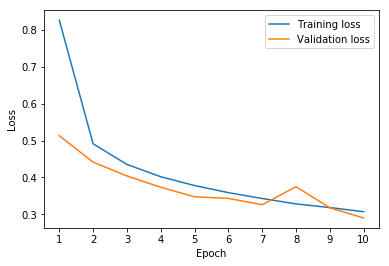

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

epoch_list = np.arange(1, num_epochs+1)
plt.xticks(epoch_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epoch_list, train_losses, label="Training loss")
plt.plot(epoch_list, test_losses, label="Validation loss")
plt.legend(loc='upper right')
plt.show()

## Classwise accuracy

Here we enumerate the `test_loader` again, recalculating the confusion matrix based on the predicted and true labels. Based on the following scores, the hardest class to predict seems to be class 6 (shirts)

In [20]:
num_classes = 10
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

classwise_accuracies = confusion_matrix.diag()/confusion_matrix.sum(1)
for i in range(len(classwise_accuracies)):
    print("Class {} accuracy: {}".format(i, classwise_accuracies[i]))

/home/joel/anaconda2/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Class 0 accuracy: 0.8345000147819519
Class 1 accuracy: 0.9786666631698608
Class 2 accuracy: 0.815833330154419
Class 3 accuracy: 0.9423333406448364
Class 4 accuracy: 0.8445000052452087
Class 5 accuracy: 0.9601666927337646
Class 6 accuracy: 0.6729999780654907
Class 7 accuracy: 0.9633333086967468
Class 8 accuracy: 0.9721666574478149
Class 9 accuracy: 0.9589999914169312


## Best accuracy over all classes

Best accuracy is calculated as the average of the classwise accuracies.

In [21]:
best_accuracy = np.average(classwise_accuracies)
print("Best accuracy: {}".format(best_accuracy))

Best accuracy: 0.8943499326705933


## Learning Points
* Use `transforms.ToTensor()` to convert a PIL image to `torch.tensor`. You can feed a list of transforms to the `DataLoader`.
* When building the model, for an input tensor with shape `(d1, ..., dn)`, you input a tensor of shape `(batch_size, d1, ..., dn)` by using `tensor.view()` to reshape the raw tensor, which might not be in this shape. You can do this either outside the model class, or as part of the `forward()` implementation, similar to `flatten` layers in Keras or Tensorflow.
 * In this case we had a `tensor` of shape `(16, 1, 28, 28)`. This was reshaped to `(16, 784)` using `tensor.view()` before it can be used as an input to layer `FCN.fc1` which maps from an input of `784` to an output of `300`.
